# 2020 빅콘테스트 챔피언리그_홈쇼핑 판매량 예측 및 편성 최적화

# 0. Business Understanding

일단 처음이니 서술형으로 이해해봅시다. 과제는 이렇습니다.

1. 홈쇼핑 판매 총액 예측
2. 예측을 통한 편성 최적화

입니다.

일단은 2번은 놔두고, 1번을 중점적으로 볼게요. 판매량 예측을 잘해야 최적화도 잘 될테니까. 그러면 과제를 자세히 살펴보죠.

1. 목표: 홈쇼핑 판매 총액 예측
2. 내부데이터: NS홈쇼핑의 판매량(2019년1월 ~ 2019년 12월)
3. 외부데이터: NS홈쇼핑의 시청률 데이터(동기간)
4. 테스트데이터: NS홈쇼핑의 판매량(2020년 6월)

보시면 아시겠지만, 트래인 데이터와 테스트 데이터 사이의 기간 차이가 매우 큽니다. 특히나 2019년 데이터로 포스트 코로나 데이터를 예측해야 합니다. 충격적이죠.

데이터를 한 번 들쑤셔 봅니다.

# 메모장

#### 200824
1. 마더코드는 브랜드+제품군 을 뜻한다. 예를 들면 LG TV =100148, LG에어컨 = 100149 이런 식으로. 아예 브랜드만 의미하는 건 아니다.
2. 상품코드는 브랜드+제품군+구성 을 듯한다. LG TV 55인치, LG TV 66인치 등등 이런 식으로. 구성이나 세부 제품이 바뀔 때 바뀐다.
3. 상품명에서 브랜드를 추출하기 위해서는 자연어 처리 품이 든다. 무지 든다.
4. 상품명의 패턴이 매우 다양하고 복잡하다. MD들이 각자 자기 고유의 표현 방식을 쓴다. 품이 많이 든다.

#### 200827
1. 아주 중요한 사실을 알아챘다. MAPE 의 핵심은, 낮은 값을 잘 예측해야 한다.<br>
왜냐고? 큰 값은 잘못 맞춰도 오차비율이 그렇게 크진 않을텐데, 낮은 값은 기하급수적으로 커진다. 가중치도 없고.<br>
그렇기 때문에 작은 값을 최대한 잘 맞추는 게 이 대회의 고득점을 올릴 수 있는 방법이다!

#### MAPE의 진실

In [159]:
np.mean(np.abs((200000000 - 2000000) / 200000000)) * 100

99.0

In [160]:
np.mean(np.abs((2000000 - 200000000) / 2000000)) * 100

9900.0

2억 짜리를 2백만원으로 예측하면 99.0, 2백만원 짜리를 2억으로 예측하면 9900.0, 이런 된장먹을

# 최적화 아이디어

1. 추천 시스템을 적용해서 그 시간에 맞는 상품군과 세부 카테고리를 추천해주는 것은 어떨까? 1,2,3위 까지
    - 결국 편성최적화라는 것은 그 편성 시간에 맞는 최적의 프로그램을 짜주라는 것인데
    - 그러면 결국 중요한 건 시간축이고, 그 시간축에 다른 축을 더해서 최적의 성과를 냈던 상품군과 세부 카테고리를 추천하는 것이 최적이지 않냐
    - 근데 그러면 계속 고정된 값만 제공하게 될 것 같은데? 너무 과대적합되는 느낌으로?
    - 추천시스템의 치명적인 단점인 다양성 말살이지.
    - 방송일시를 하나의 유저라고 보면, 상품을 콘텐츠, 가격대비 취급액을 레이팅이라고 보고. 협업필터링 기반으로 추천시스템을 구현해보면?

2. 요즘 유행하는 오토인코더 쓸 수 있지 않을까?
    - 그러니까, 음. 어떤 상품을 판매하고 싶은데, 어떤 편성 시간이 좋을까 라고 접근을 하면.
    - 편성시간대를 가운데 레이턴트 벡터로 두고, 제품과 목표 취급액을 넣었을 때 원하는 결과값을 추출해내는 거라면?!

# 1. Data Understanding

★참고사항 

1.  취급액 =판매단가 X  주문량(취소,반품제외) 

2. 판매가  0원(무형상품)은 추정 제외 

3. 매주 토요일  18:00~18:20은 정보방송시간으로 추정 제외(당사사정에 따라 ±20 편성 변경 있음)

4. 편성 듀레이션은  10분~60분내외 임 

5. 2020.06월 편성표는 월~토 6:20~2:20(익일), 일요일은 6:20~2:00로 구성 (심야시간대 제외)

단, raw data의 19.01.01~19.10.31은 6:00~2:00로 운영하였음 11.01부터 6:20~2:20운영

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
from pprint import pprint
import time
import re
import time
import datetime
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# 이거는 자꾸 맷플롯립 그래프에서 한글이 깨지는 문제로 폰트 설치해주는 코드

from matplotlib import font_manager, rc

font = r"C:\Users\thinp\fonts\NanumGothic.ttf"
font = font_manager.FontProperties(fname=font).get_name()
plt.style.use('seaborn-white')
rc('font', family=font)

In [402]:
train = pd.read_csv(r'C:\Users\thinp\python\Kaggle\bigcon\Data/train_new.csv')
test = pd.read_csv(r'C:\Users\thinp\python\Kaggle\bigcon\Data/test_new.csv')

In [152]:
train.shape, test.shape

((38309, 8), (2891, 8))

In [153]:
train.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 6:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","2,099,000"
1,2019-01-01 6:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","4,371,000"
2,2019-01-01 6:20,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","3,262,000"
3,2019-01-01 6:20,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","6,955,000"
4,2019-01-01 6:40,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","6,672,000"


In [154]:
test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 6:20,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
1,2020-06-01 6:40,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 7:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:20,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
4,2020-06-01 7:40,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN


In [155]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   방송일시    38309 non-null  object 
 1   노출(분)   21525 non-null  float64
 2   마더코드    38309 non-null  int64  
 3   상품코드    38309 non-null  int64  
 4   상품명     38309 non-null  object 
 5   상품군     38309 non-null  object 
 6   판매단가    38309 non-null  object 
 7    취급액    35379 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.3+ MB


In [159]:
train.isnull().sum()

방송일시         0
노출(분)    16784
마더코드         0
상품코드         0
상품명          0
상품군          0
판매단가         0
 취급액      2930
dtype: int64

In [167]:
# Train/Test-set의 고유한 마더코드와 상품코드를 살펴봅시다.
train_mcode = set(train['마더코드'])
test_mcode  = set(test['마더코드'])


# Train/Test-set 고유한 마더코드의 개수를 구함.
print(f"Train-set에 있는 고유한 마더코드 개수 : {len(train_mcode)}")
print(f"Test-set에 있는 고유한 마더코드 개수 : {len(test_mcode)}")

# Train/Test-set 모두에 포함되어있는 상품코드를 구함.
print('='* 80)
common_mcode = train_mcode.intersection(test_mcode)
print(f"Train/Test-set에 공통으로 포함되어 있는 마더코드 개수 : {len(common_mcode)}")
#print(f"Train/Test-set에 공통으로 포함되어 있는 마더코드 개수 : {sorted(common_mcode)}")

# Train-set에만 있는 마더코드를 구함.
print('='* 80)
train_only_mcode = train_mcode.difference(test_mcode)
print(f"Train-set에만 있는 마더코드는 총 {len(train_only_mcode)}개 입니다.")
#print(f"Train-set에만 있는 마더코드는 : {sorted(train_only_mcode)}")

# Test-set에만 있는 마더코드를 구함.
print('='* 80)
test_only_mcode = test_mcode.difference(train_mcode)
print(f"Test-set에만 있는 상품코드는 총 {len(test_only_mcode)}개 입니다.")
#print(f"Test-set에만 있는 상품코드는 : {sorted(test_only_mcode)}")

Train-set에 있는 고유한 마더코드 개수 : 716
Test-set에 있는 고유한 마더코드 개수 : 225
Train/Test-set에 공통으로 포함되어 있는 마더코드 개수 : 91
Train-set에만 있는 마더코드는 총 625개 입니다.
Test-set에만 있는 상품코드는 총 134개 입니다.


In [166]:
# Train/Test-set의 고유한 상품코드를 살펴봅시다.
train_pcode = set(train['상품코드'])
test_pcode  = set(test['상품코드'])


# Train/Test-set 고유한 상품코드의 개수를 구함.
print(f"Train-set에 있는 고유한 상품코드 개수 : {len(train_pcode)}")
print(f"Test-set에 있는 고유한 상품코드 개수 : {len(test_pcode)}")

# Train/Test-set 모두에 포함되어있는 상품코드를 구함.
print('='* 80)
common_pcode = train_pcode.intersection(test_pcode)
print(f"Train/Test-set에 공통으로 포함되어 있는 상품코드 개수 : {len(common_pcode)}")
#print(f"Train/Test-set에 공통으로 포함되어 있는 상품코드 : {sorted(common_pcode)}")

# Train-set에만 있는 상품코드를 구함.
print('='* 80)
train_only_pcode = train_pcode.difference(test_pcode)
print(f"Train-set에만 있는 상품코드는 총 {len(train_only_pcode)}개 입니다.")
#print(f"Train-set에만 있는 상품코드는 : {sorted(train_only_pcode)}")

# Test-set에만 있는 상품코드를 구함.
print('='* 80)
#test_only_pcode = test_pcode.difference(train_pcode)
print(f"Test-set에만 있는 상품코드는 총 {len(test_only_pcode)}개 입니다.")
#print(f"Test-set에만 있는 상품코드는 : {sorted(test_only_pcode)}")

Train-set에 있는 고유한 상품코드 개수 : 2124
Test-set에 있는 고유한 상품코드 개수 : 417
Train/Test-set에 공통으로 포함되어 있는 상품코드 개수 : 27
Train-set에만 있는 상품코드는 총 2097개 입니다.
Test-set에만 있는 상품코드는 총 390개 입니다.


In [258]:
train = train[train['취급액'] != 0]

In [386]:
train.head().columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', ' 취급액 ',
       '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh', '방송일시_mm', '방송일시_MMDD',
       '방송일시_DDhh', '방송일시_hhmm', '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2',
       '방송일시_mmmm_3', '방송일시_dow2'],
      dtype='object')

In [348]:
train.drop(['상품명_plan', '상품명_add', '상품명_maker', '상품명_set', '상품명_sex', 'new_상품명',
       '상품명_brand', 'fake_weight', 'fake_weight2', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh', '방송일시_mm',
       '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_MMDDhh', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2'],
          axis=1,
          inplace=True)

In [421]:
train[['방송일시', '노출(분)', '상품명', '상품군', '판매단가', '취급액']].describe()

,노출(분),판매단가,취급액
count,37372.000000,3.737200e+04,3.737200e+04
mean,20.381676,4.680006e+05,2.187039e+07
std,3.116840,7.314484e+05,2.019429e+07
min,2.000000,1.280000e+04,0.000000e+00
25%,20.000000,5.900000e+04,6.880750e+06
50%,20.000000,1.099000e+05,1.612950e+07
75%,20.000000,5.090000e+05,3.163125e+07
max,40.000000,7.930000e+06,3.220090e+08


# 2. Preprocessing & Feature Engineering

## 2.1 cast_time(누적방송시간), cast_count(누적방송횟수) 컬럼 만들기

In [403]:
def make_cast_time(train): # nan값이 있는 초기 데이터셋을 써야 하기 때문에 가장 먼저 돌려줍니다. 자세한 알고리즘은 창고에서 찾아보세요.

    # 일단 nan값을 노출(분)칼럼에만 남기기 위해서 나머지 nan값 전처리 미리 해버리겠습니다.
    train[' 취급액 '] = train[' 취급액 '].fillna('0')
    train = train[train.상품군 != '무형']

    # nan값 있는 애들을 따로 저장해둡니다.
    train_yes_nan = train[train['노출(분)'].isnull()]
    # nan값 없는 애들을 따로 저장해줍니다. 이놈들로 작업할겁니다.
    train_not_nan = train.dropna()

    # 인덱스 꼬여서 포문 안 돌아가기 때문에 인덱스 리셋하고 나중에 불러와주기 위해서 따로 저장해줍니다.
    train_not_nan_index = train_not_nan.index
    # 리셋 인덱스 해줍니다.
    train_not_nan_reset_index = train_not_nan.reset_index(drop=True)

    # 여기서부터 cast_time, cast_count 포문-----------------------------------------------------
    cast_time = []
    cast_count = []
    time = 0.
    count = 1

    for i in range(len(train_not_nan_reset_index)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            time = train_not_nan_reset_index['노출(분)'][i] # 더하지 않고, 자기 노출을 그대로 가져옵니다.
            count = 1 # count도 1로 초기화 합니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
        elif train_not_nan_reset_index['상품코드'][i] == train_not_nan_reset_index['상품코드'][i-1]: # 자기의 상품코드가 앞행의 상품코드와 같을 때
            time += train_not_nan_reset_index['노출(분)'][i] # 기존 누적된 노출에 자기 노출을 더한다.
            count += 1 # count도 1을 더해줍니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
        else: # 근데 자기 상품코드와 앞행의 상품코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            time = train_not_nan_reset_index['노출(분)'][i] # 더하지 않고, 자기 노출을 그대로 가져옵니다.
            count = 1 # count도 1로 초기화 합니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
    # 포문 끝------------------------------------------------------------  
    # 컬럼으로 박아줍니다.
    train_not_nan_reset_index['cast_time'] = cast_time
    train_not_nan_reset_index['cast_count'] = cast_count
    
    # 여기서부터 cast_time_sum, cast_count_sum 포문-------------------------------------------------
    cast_time_sum = []
    cast_count_sum = []

    for i in range(len(train_not_nan_reset_index)):
        if i == max(train_not_nan_reset_index.index): #마지막은 비교할 다음타자가 없으니 바로 넣기.
            cast_time_sum.append(train_not_nan_reset_index['cast_time'][i])
            cast_count_sum.append(train_not_nan_reset_index['cast_count'][i])
        elif train_not_nan_reset_index['상품코드'][i] == train_not_nan_reset_index['상품코드'][i+1]: # 자기와 다음타자의 상품코드가 같으면
            cast_time_sum.append(np.nan)
            cast_count_sum.append(np.nan)
        else: # 자기와 다음타자의 상품코드가 다르면
            cast_time_sum.append(train_not_nan_reset_index['cast_time'][i])
            cast_count_sum.append(train_not_nan_reset_index['cast_count'][i])
            
    # 포문 끝----------------------------------------------------------------------
    # 칼럼으로 박아줍니다.
    train_not_nan_reset_index['cast_time_sum'] = cast_time_sum
    train_not_nan_reset_index['cast_count_sum'] = cast_count_sum
    # 백필로 nan값 채워줍니다.
    train_not_nan_reset_index.fillna(method='bfill', inplace=True)
    

    # 원래 인덱스 다시 넣어줍니다.
    train_not_nan_reset_index.index = train_not_nan_index
    # 컨캣으로 밑으로 붙여주고,
    train_concat = pd.concat([train_not_nan_reset_index, train_yes_nan], axis=0)
    # 소트 인덱스 먼저 하고,
    train_concat_sort_index = train_concat.sort_index()
    # ffill 로 채워줍니다. 끝. 이거 너무 힘들었다 진짜 레알.
    train = train_concat_sort_index.fillna(method='ffill')
    
    # 누적 방송 시간 비율 칼럼을 만들어줍니다.
    train['cast_time_ratio'] = train.cast_time / train.cast_time_sum
    
    # 인덱스 리셋해줍니다.
    train = train.reset_index(drop=True)
    
    # 다이어트
    train['cast_count'] = train.cast_count.astype(np.int16)
    
    return train

In [404]:
train = make_cast_time(train)

## 2.2 '취급액', '판매단가' 형변환 및 컬럼 리네임

In [405]:
# 기본 전처리 함수
def preprocessing_1(df):
    
    # 취급액과 판매단가 수치형 변수로 바꾸기.
    df[' 취급액 '] = df[' 취급액 '].apply(lambda x: x.replace(',', ''))
    df['판매단가'] = df['판매단가'].apply(lambda x: x.replace(',', ''))
    df[' 취급액 '] = df[' 취급액 '].astype(np.int32)
    df['판매단가'] = df['판매단가'].astype(np.int32)
    
    # 칼럼명 너무 어려우니까 쪼금만 바꿔줍니다.
    df = df.rename(columns = {' 취급액 ':'취급액'})
    
    return df

In [406]:
train = preprocessing_1(train)

## 2.3 '상품명' 파생 변수 생성

### 2.3.1. 상품명 파생 변수 생성

In [407]:
# 상품명 전처리 함수
def preprocessing_3(train):
    # 1. 일시불/무이자/없음
    train.loc[train['상품명'].str.contains('일시불') == True, "상품명_plan"] = '일시불'
    train.loc[train['상품명'].str.contains('일\)') == True, "상품명_plan"] = '일시불'
    train.loc[train['상품명'].str.contains('무이자') == True, "상품명_plan"] = '무이자'
    train.loc[train['상품명'].str.contains('무\)') == True, "상품명_plan"] = '무이자'
    train['상품명_plan'] = train['상품명_plan'].fillna('그 외')

    # 2. 추가구성/단품구성
    train.loc[train['상품명'].str.contains('\+') == True, "상품명_add"] = '추가구성'
    train['상품명_add'] = train['상품명_add'].fillna('그 외')

    # 3. 기타/삼성/LG
    train.loc[train['상품명'].str.contains('삼성') == True, "상품명_maker"] = '삼성'
    train.loc[train['상품명'].str.contains('LG') == True, "상품명_maker"] = 'LG'
    train['상품명_maker'] = train['상품명_maker'].fillna('그 외')

    # 4. 세트구성/단품구성
    train.loc[train['상품명'].str.contains('세트') == True, "상품명_set"] = '세트구성'
    train['상품명_set'] = train['상품명_set'].fillna('단품구성')

    # 5. 여성/남성/없음
    train.loc[train['상품명'].str.contains('여성') == True, "상품명_sex"] = '여성'
    #train.loc[train['상품명'].str.contains('브라') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('란쥬') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('블라우스') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('밍크') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('남성') == True, "상품명_sex"] = '남성'
    #train.loc[train['상품명'].str.contains('드로즈') == True, "상품명_sex"] = '2'
    #train.loc[train['상품명'].str.contains('트렁크') == True, "상품명_sex"] = '2'
    train['상품명_sex'] = train['상품명_sex'].fillna('그 외')

    # category로 형변환해서 다이어트 시켜줍니다.
    train['상품명_plan'] = train['상품명_plan'].astype('category')
    train['상품명_add'] = train['상품명_add'].astype('category')
    train['상품명_maker'] = train['상품명_maker'].astype('category')
    train['상품명_set'] = train['상품명_set'].astype('category')
    train['상품명_sex'] = train['상품명_sex'].astype('category')
    
    return train

In [408]:
train = preprocessing_3(train)

### 2.3.2. 정규화를 통한 new_상품명, brand 추출

In [409]:
def pre_nlp(train):
    # 제품명에서 불필요한 요소를 전처리 해서 유사한 상품을 동일하게 만드는 코드입니다.
    new_product_name = []

    re_stop = re.compile("""\([가-힣]{1,5}\+[가-힣]{1,5}\)|\(?무이자\)?\s?|\(?일시불\)?\s?|\(?초특가\)?\s?|\(?무\)\s?|\(?유\)\s?|\(?일\)\s?|무료체험|
    |포함|국내[가-힣]+\s|무료설치|\s?신제품\s?|\s?패키지\s?|[0-9]+종|풀코디|set|SET|풀세트|[0-9]+세트|더블팩|싱글팩|[0-9]{1,2}\+[0-9]{1,2}|[0-9]{1,2}인용|[0-9]{1,2}박스|[0-9\.]{1,4}미터|[0-9\.]{1,4}kg|[0-9\.]{1,4}[kKgG]|[0-9]{1,3}[벌롤종단구대P개통병포미봉팩장gL매]|
    |\s[0-9\.]{1,4}[Mm]|\(.{1,10}\)$|^\(.?\)|^[0-9]{2,4}\s|\s+[0-9]{2,4}\s|[0-9]{2,4}년\s|[0-9]{2,4}년형\s|시즌[0-9]|[0-9]{1,3}\%|\(.{1,20}\)$|기본형|고급형|오리지널|[대중소大中小]형|.{1,10}by|,|\s?총[0-9\s]|^[가-힣a-zA-Z]{3,3}의|
    |S\/S|F\/W|f\/w|s\/s|[가-힣]+형\s|[슈퍼]{0,2}싱글|\s[SQK퀸킹]{1,2}\s|[SQK퀸킹]{1,2}$|[가-힣]{0,2}사이즈""")

    remnants = re.compile('[",g\+lL-]\s|ml|_|\sx|[\[\]\］!"#$%&\'()*+,./:;<=>?@\^_`{|}~-]|\s종$|\s[0-9]+\s|\s{2,}')

    for i in train.상품명:
        tmp = re_stop.sub(' ',i)
        tmp = tmp.strip()
        tmp = remnants.sub(' ',tmp)
        new_product_name.append(tmp.strip())
    
    train['new_상품명'] = new_product_name
    
    # 상품명에서 브랜드 추출
    train['상품명_brand'] = train['new_상품명'].apply(lambda x: x[:2])
    
    return train

In [410]:
train = pre_nlp(train)

## 2.4 동일 방송 이종 상품 '판매단가' 역가중치 변수 생성

### 2.4.1. 동일 방송 and 비슷한 상품 but 다른 단가 상품 역가중치 변수 생성

In [411]:
def make_fake_weight(train):
    fake_weight = []
    weight = 1

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            weight = 1 # count도 1로 초기화 합니다.
            fake_weight.append(weight) # 그리고 어펜드.
            
        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            if train['판매단가'][i] < train['판매단가'][i-1]: # 자기의 단가가 앞행의 것보다 작으면(같으면 안됨)
                weight +=1 # 가중치 1을 더하고,
                fake_weight.append(weight) # 그리고 어펜드
            else: # 자기의 단가가 앞행의 것과 같거나 더 크면(더 클 수는 없음.)
                weight = 1 # 가중치 1로 초기화
                fake_weight.append(weight)
                
        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            weight = 1 # 가중치 1로 초기화
            fake_weight.append(weight)
            
    train['fake_weight'] = fake_weight
    train['fake_weight'] = train.fake_weight.apply(lambda x: -(x*x))
    
    return train

In [412]:
train = make_fake_weight(train)

### 2.4.2. 동일 방송 and 동일 단가 but 다른 상품 역가중치 변수 생성

In [413]:
def make_train_fake(train):
    
    # 더 정확한 변수 생성을 위해 기계가 걸러내지 못하는 조건을 쳐내줍니다.
    train_fake = train[train.상품명_plan == '0'] # 할부플랜이 다른 애들 쳐내기
    train_fake = train_fake[train_fake.상품명_sex == '0'] # 성별이 다른 애들 쳐내기.
    
    # 포문 돌리기 위해 인덱스 리셋 해줍니다.
    train_fake.reset_index(drop=True, inplace=True)

    return train_fake

In [414]:
def make_fake_weight2(train):
    fake_weight = []
    weight = 0

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            weight = 0 # count도 1로 초기화 합니다.
            fake_weight.append(weight) # 그리고 어펜드.
            
        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            if train['판매단가'][i] == train['판매단가'][i-1]: # 자기의 단가가 앞행의 것과 같을 때
                if train['방송일시'][i] == train['방송일시'][i-1]:
                    if train['상품코드'][i] != train['상품코드'][i-1]: # 상품코드는 일치하지 않으면 조건 성립
                        weight -=1 # 가중치 1을 빼고,
                        fake_weight.append(weight) # 그리고 어펜드
                    else: # 상품코드까지 같으면 동일 상품.
                        weight = 0
                        fake_weight.append(weight)
                else: #방송일시가 다르면 새로운 방송 시작
                    weight = 0 # 가중치 0로 초기화
                    fake_weight.append(weight)
            else: # 판매단가가 다르면 다른 상품
                weight = 0 # 가중치 0로 초기화
                fake_weight.append(weight)
        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            weight = 0 # 가중치 1로 초기화
            fake_weight.append(weight)
            
    train['fake_weight2'] = fake_weight
    
    return train

In [415]:
train_fake = make_train_fake(train)
train_fake = make_fake_weight2(train_fake)

In [416]:
# 기존 데이터에 합쳐줍니다.
train = pd.merge(train, train_fake[['방송일시','마더코드','상품코드','상품명','판매단가', 'fake_weight2']],
                 on=['방송일시','마더코드','상품코드','상품명','판매단가'], how='left')

# 빈 값은 전부 0으로 채워줍니다.
train['fake_weight2'] = train['fake_weight2'].fillna(0)

## 2.5 '상품명' 카테고리(네이버 쇼핑 API 활용) 칼럼 merging

In [417]:
category = pd.read_csv(r'C:\Users\thinp\python\Kaggle\bigcon\Data/categorized_HJ2.csv') # 카테고리 추가되었습니다.

In [418]:
# 난 값 먼저 채워 줍니다.
category['cat3'] = category.apply(lambda x: x['cat2'] if x['cat3'] != x['cat3'] else x['cat3'], axis=1)

In [419]:
def preprocessing_to_merge(df):
    # merge를 위해 datetime으로 바꿔줍니다..
    df['방송일시'] = pd.to_datetime(df['방송일시'], errors='coerce')
    df['방송일시'] = df['방송일시'].astype(str)
    
    # key 칼럼을 만들어줍니다. 방송일시만으로는 안되니, 방송일시+상품명을 해줍니다.
    df['key'] = df['방송일시'] + df['상품명']
    
    return df

In [333]:
def preprocessing_merging(df1, df2):
    # df1이 왼쪽, df2가 오른쪽입니다.
    df3 = pd.merge(df1, df2[['key','cat1','cat2','cat3']], how='left', on=['key'])
    df3 = df3.drop('key', axis=1) # key 칼럼은 드랍.
    
    return df3

In [334]:
train = preprocessing_to_merge(train)
category = preprocessing_to_merge(category)
train = preprocessing_merging(train, category)

## 2.6 날씨 변수 추가(기상청)

기상청 서울 관측소 기준, 시간대별 기온을 넣어줍니다. 나머지는 유의미하지 않습니다.

In [335]:
# 기상청 통계 파일 읽기
weather = pd.read_csv(r'C:\Users\thinp\python\Kaggle\bigcon\Data/weather_train.csv', encoding='latin1')
columns = ['location_id','location','방송일시','temperature']
weather.columns = columns

In [336]:
def outside_feature_weather_key(train):
    # 날씨 변수를 합쳐주기 위한 전처리 작업니다.
    # datetime으로 바꾼 후, str로 바꿉니다.
    train['방송일시'] = pd.to_datetime(train['방송일시'], errors='coerce')
    train['방송일시'] = train.방송일시.astype(str)
    
    # key column 만들어주기.
    train['weather_key'] = (
        train['방송일시'].apply(lambda x: x[2:4]) + 
        train['방송일시'].apply(lambda x: x[5:7]) + 
        train['방송일시'].apply(lambda x: x[8:10]) + 
        train['방송일시'].apply(lambda x: x[11:13])
    )
    
    return train

In [337]:
# key 칼럼 만들어주고.
weather = outside_feature_weather_key(weather)
train = outside_feature_weather_key(train)

In [338]:
# 합쳐줍니다.
train = pd.merge(train, weather, on='weather_key', how='left')

In [339]:
# 필요없는 칼럼은 버려줍니다.
train.drop(['location_id', 'location', '방송일시_y', 'weather_key'], axis=1, inplace=True)

In [340]:
# 꼬여버린 컬럼명 바로잡기
train.rename(columns = {'방송일시_x':'방송일시'}, inplace=True)

## 2.7 '방송일시' 파생변수 생성

In [383]:
# 방송일시 쪼개기 전처리 함수
def preprocessing_4(train):
    # datetime으로 바꿔줍니다.
    train['방송일시'] = pd.to_datetime(train['방송일시'], errors='coerce')
   
    # 월일이 다음날로 넘어가는 것을 막기 위해서 3시간씩 앞으로 땡겨줍니다. 마지막에 다시 더해줘야 합니다.
    delta = datetime.timedelta(hours=3)
    train['방송일시'] = train.방송일시.apply(lambda x: x - delta)

    # dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
    # 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
    train["방송일시_dow"] = train["방송일시"].dt.dayofweek

    # 요일 외에 다른 정보를 가져오기 위해서 다시 string으로 바꿔줍니다.
    train['방송일시'] = train.방송일시.astype(str)

    # MMDDhhmm 정보를 가져옵니다.
    train['방송일시_MM'] = train['방송일시'].apply(lambda x: x[5:7])
    train['방송일시_DD'] = train['방송일시'].apply(lambda x: x[8:10])
    train['방송일시_hh'] = train['방송일시'].apply(lambda x: x[11:13])
    train['방송일시_mm'] = train['방송일시'].apply(lambda x: x[14:16])

    # schedule 관련 칼럼을 더 만들어보겠습니다. # MMDD # DDHH # HHMM # weekday/weekends
    train['방송일시_MMDD'] = train['방송일시_MM'] + train['방송일시_DD']
    train['방송일시_DDhh'] = train['방송일시_DD'] + train['방송일시_hh']
    train['방송일시_hhmm'] = train['방송일시_hh'] + train['방송일시_mm']
    train['방송일시_MMDDhh'] = train['방송일시_MM'] + train['방송일시_DD'] + train['방송일시_hh']

    # mmmm_1 은 1일 사이클로 분단위로 환산한 것
    # mmmm_2 는 1달 사이클로 분단위로 환산한 것
    # mmmm_3 는 1년 사이클로 분단위로 환산한 것
    train['방송일시_mmmm_1'] = train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60
    train['방송일시_mmmm_2'] = train['방송일시_DD'].astype(int) * train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60
    train['방송일시_mmmm_3'] = train['방송일시_MM'].astype(int) * train['방송일시_DD'].astype(int) * train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60

    # weekday = 1 / weekends = 0
    train.loc[train.방송일시_dow == 5, '방송일시_dow2'] = '0'
    train.loc[train.방송일시_dow == 6, '방송일시_dow2'] = '0'
    train['방송일시_dow2'] = train.방송일시_dow2.fillna('1')
    
    #다이어트 및 형변환
    train['방송일시_dow'] = train.방송일시_dow.astype('category')
    train['방송일시_MM'] = train.방송일시_MM.astype('category')
    train['방송일시_DD'] = train.방송일시_DD.astype('category')
    train['방송일시_hh'] = train.방송일시_hh.astype('category')
    train['방송일시_mm'] = train.방송일시_mm.astype('category')
    train['방송일시_MMDD'] = train.방송일시_MMDD.astype('category')
    train['방송일시_DDhh'] = train.방송일시_DDhh.astype('category')
    train['방송일시_hhmm'] = train.방송일시_hhmm.astype('category')
    train['방송일시_dow2'] = train.방송일시_dow2.astype('category')
    train['방송일시_mmmm_1'] = train.방송일시_mmmm_1.astype('category')
    train['방송일시_mmmm_2'] = train.방송일시_mmmm_2.astype('category')
    train['방송일시_mmmm_3'] = train.방송일시_mmmm_3.astype('category')
    
    return train

In [384]:
train = preprocessing_4(train)

## 2.8 외부 변수 추가

### 2.8.1. NAVER 크롤링을 통한 변수 추가

In [343]:
naver = pd.read_csv(r'C:\Users\thinp\python\Kaggle\bigcon\Data/naver_train.csv')

In [344]:
def outside_feature_naver(train, naver):
    # 네이버 크롤링 데이터를 합친 후 전처리 하는 코드입니다.
    # 먼저 합쳐줍니다.
    train = pd.merge(train, naver, on='상품명', how='left')
    
    # 전처리 해줍니다.
    train['review_counts'] = train['review_counts'].apply(lambda x: x.replace(',',''))
    train['internet_price'] = train['internet_price'].apply(lambda x: x.replace(',',''))
    train['internet_price'] = train['internet_price'].apply(lambda x: x.replace('원',''))
    train['review_counts'] = train['review_counts'].astype(int)
    train['internet_price'] = train['internet_price'].astype(int)

    # 오차를 컬럼으로 만들어줍니다.
    train['price_minus'] = train['판매단가'] - train['internet_price']

    # 네이버에 서칭이 되는지 여부를 알려줍니다.
    train['search_naver'] = train['internet_price'] + train['review_counts']
    train['search_naver'] = train['search_naver'].apply(lambda x: 0 if x == 0 else 1)
    
    return train

In [345]:
train = outside_feature_naver(train, naver)

In [346]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 37371
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   방송일시            37372 non-null  object  
 1   노출(분)           37372 non-null  float64 
 2   마더코드            37372 non-null  int64   
 3   상품코드            37372 non-null  int64   
 4   상품명             37372 non-null  object  
 5   상품군             37372 non-null  object  
 6   판매단가            37372 non-null  int32   
 7   취급액             37372 non-null  int32   
 8   상품명_plan        37372 non-null  category
 9   상품명_add         37372 non-null  category
 10  상품명_maker       37372 non-null  category
 11  상품명_set         37372 non-null  category
 12  상품명_sex         37372 non-null  category
 13  new_상품명         37372 non-null  object  
 14  상품명_brand       37372 non-null  object  
 15  fake_weight     37372 non-null  int64   
 16  fake_weight2    37372 non-null  float64 
 17  cat1        

# 3. EDA

## 3.0 기본

In [209]:
train['취급액'].describe()

count    3.737200e+04
mean     2.187039e+07
std      2.019429e+07
min      0.000000e+00
25%      6.880750e+06
50%      1.612950e+07
75%      3.163125e+07
max      3.220090e+08
Name: 취급액, dtype: float64

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


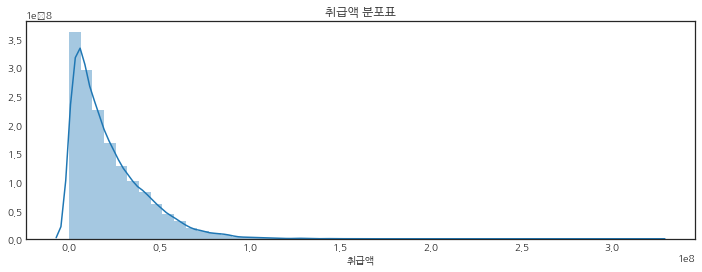

In [213]:
# 상품명_sex 취급액 비교
plt.figure(figsize=(12, 4))
plt.title('취급액 분포표')
sns.distplot(train['취급액'], bins=50)
plt.show()

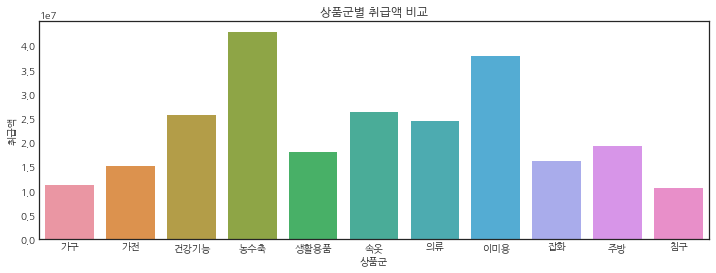

In [146]:
# 상품명_sex 취급액 비교
plt.figure(figsize=(12, 4))
plt.title('상품군별 취급액 비교')
sns.barplot(data=train.groupby('상품군')['취급액'].mean().reset_index(), x='상품군', y='취급액')
plt.show()

## 3.1 방송시간별 취급액 비교

In [38]:
train.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액',
       'cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum',
       'cast_time_ratio', '상품명_plan', '상품명_add', '상품명_maker', '상품명_set',
       '상품명_sex', 'new_상품명', '상품명_brand', 'fake_weight', 'fake_weight2',
       'cat1', 'cat2', 'cat3', 'temperature', '방송일시_dow', '방송일시_MM', '방송일시_DD',
       '방송일시_hh', '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm',
       '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2',
       'review_counts', 'internet_price', 'price_minus', 'search_naver'],
      dtype='object')

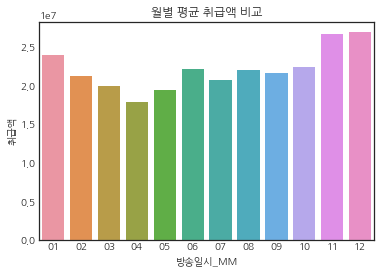

In [55]:
# 월별 취급액 비교
plt.title('월별 평균 취급액 비교')
sns.barplot(data=train.groupby('방송일시_MM')['취급액'].mean().reset_index(), x='방송일시_MM', y='취급액')
plt.show()

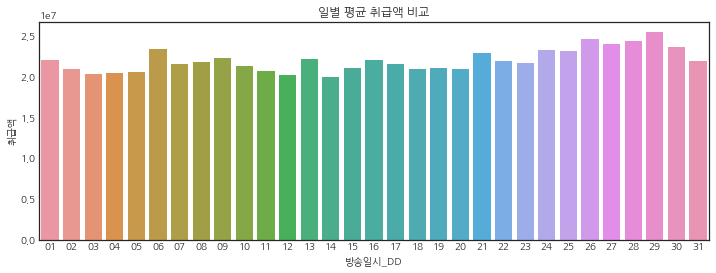

In [53]:
# 일별 취급액 비교
plt.figure(figsize=(12, 4))
plt.title('일별 평균 취급액 비교')
sns.barplot(data=train.groupby('방송일시_DD')['취급액'].mean().reset_index(), x='방송일시_DD', y='취급액')
plt.show()

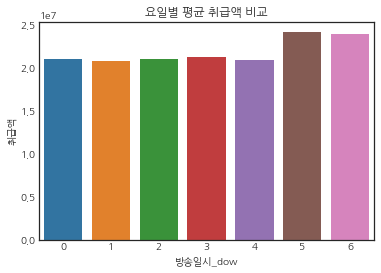

In [52]:
# 요일별 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('요일별 평균 취급액 비교')
sns.barplot(data=train.groupby('방송일시_dow')['취급액'].mean().reset_index(), x='방송일시_dow', y='취급액')
plt.show()

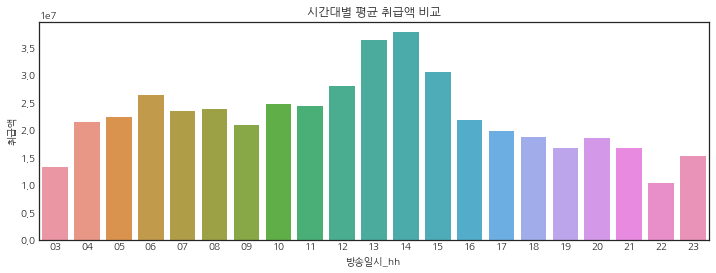

In [51]:
# 시간별 취급액 비교
plt.figure(figsize=(12, 4))
plt.title('시간대별 평균 취급액 비교')
sns.barplot(data=train.groupby('방송일시_hh')['취급액'].mean().reset_index(), x='방송일시_hh', y='취급액')
plt.show()

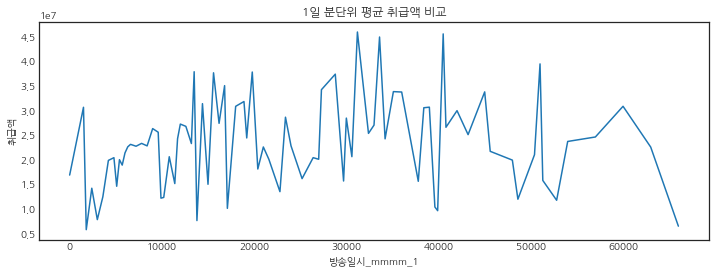

In [66]:
# 1일 분단위 취급액 비교
plt.figure(figsize=(12, 4))
plt.title('1일 분단위 평균 취급액 비교')
sns.lineplot(data=train.groupby('방송일시_mmmm_1')['취급액'].mean().reset_index(), x='방송일시_mmmm_1', y='취급액')
plt.show()

## 3.2 상품명별 취급액 비교

In [67]:
train.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액',
       'cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum',
       'cast_time_ratio', '상품명_plan', '상품명_add', '상품명_maker', '상품명_set',
       '상품명_sex', 'new_상품명', '상품명_brand', 'fake_weight', 'fake_weight2',
       'cat1', 'cat2', 'cat3', 'temperature', '방송일시_dow', '방송일시_MM', '방송일시_DD',
       '방송일시_hh', '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm',
       '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2',
       'review_counts', 'internet_price', 'price_minus', 'search_naver'],
      dtype='object')

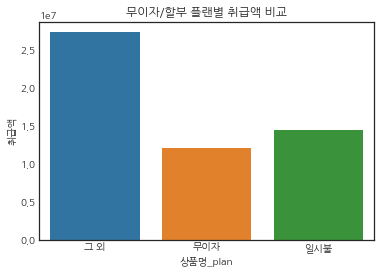

In [142]:
# 상품명_plan 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('무이자/할부 플랜별 취급액 비교')
sns.barplot(data=train.groupby('상품명_plan')['취급액'].mean().reset_index(), x='상품명_plan', y='취급액')
plt.show()

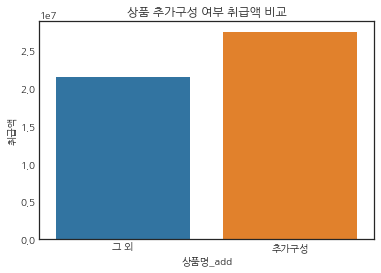

In [143]:
# 상품명_add 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('상품 추가구성 여부 취급액 비교')
sns.barplot(data=train.groupby('상품명_add')['취급액'].mean().reset_index(), x='상품명_add', y='취급액')
plt.show()

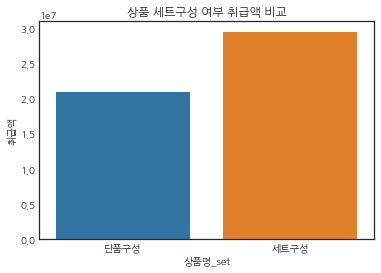

In [144]:
# 상품명_set 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('상품 세트구성 여부 취급액 비교')
sns.barplot(data=train.groupby('상품명_set')['취급액'].mean().reset_index(), x='상품명_set', y='취급액')
plt.show()

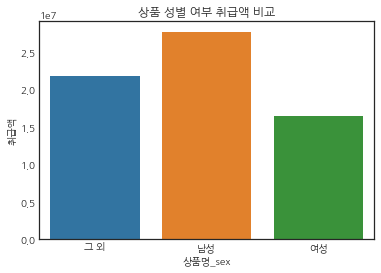

In [145]:
# 상품명_sex 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('상품 성별 여부 취급액 비교')
sns.barplot(data=train.groupby('상품명_sex')['취급액'].mean().reset_index(), x='상품명_sex', y='취급액')
plt.show()

## 3.3 동일방송내 상품별 취급액 비교

In [85]:
train.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액',
       'cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum',
       'cast_time_ratio', '상품명_plan', '상품명_add', '상품명_maker', '상품명_set',
       '상품명_sex', 'new_상품명', '상품명_brand', 'fake_weight', 'fake_weight2',
       'cat1', 'cat2', 'cat3', 'temperature', '방송일시_dow', '방송일시_MM', '방송일시_DD',
       '방송일시_hh', '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm',
       '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2',
       'review_counts', 'internet_price', 'price_minus', 'search_naver'],
      dtype='object')

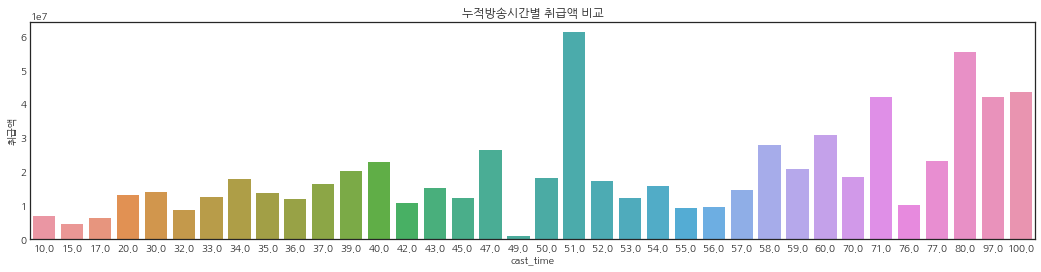

In [148]:
# cast_time 취급액 비교
plt.figure(figsize=(18, 4))
plt.title('누적방송시간별 취급액 비교')
sns.barplot(data=train.groupby('cast_time')['취급액'].mean().reset_index(), x='cast_time', y='취급액')
plt.show()

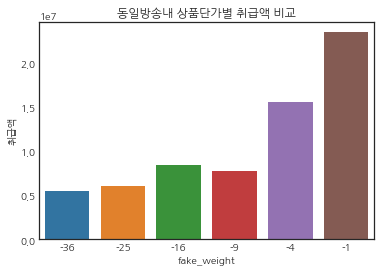

In [149]:
# 동일방송내 단가별 상품 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('동일방송내 상품단가별 취급액 비교')
sns.barplot(data=train.groupby('fake_weight')['취급액'].mean().reset_index(), x='fake_weight', y='취급액')
plt.show()

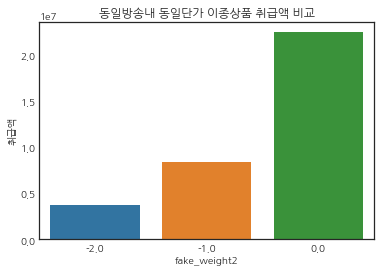

In [96]:
# 동일방송내 단가별 상품 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('동일방송내 동일단가 이종상품 취급액 비교')
sns.barplot(data=train.groupby('fake_weight2')['취급액'].mean().reset_index(), x='fake_weight2', y='취급액')
plt.show()

## 3.4 외부데이터

In [100]:
train.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액',
       'cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum',
       'cast_time_ratio', '상품명_plan', '상품명_add', '상품명_maker', '상품명_set',
       '상품명_sex', 'new_상품명', '상품명_brand', 'fake_weight', 'fake_weight2',
       'cat1', 'cat2', 'cat3', 'temperature', '방송일시_dow', '방송일시_MM', '방송일시_DD',
       '방송일시_hh', '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm',
       '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2',
       'review_counts', 'internet_price', 'price_minus', 'search_naver'],
      dtype='object')

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


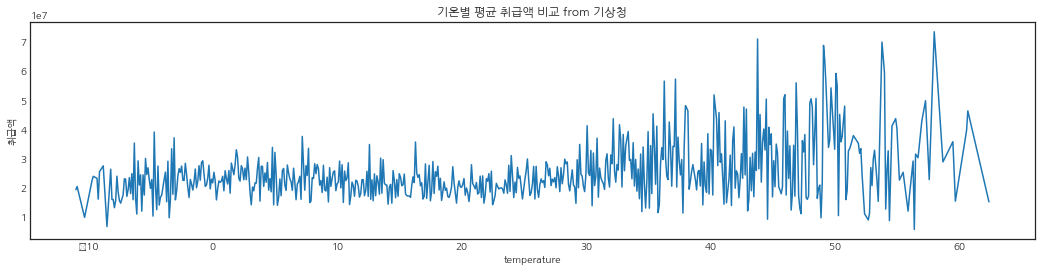

In [150]:
# 동일방송내 단가별 상품 취급액 비교
plt.figure(figsize=(18, 4))
plt.title('기온별 평균 취급액 비교 from 기상청')
sns.lineplot(data=train.groupby('temperature')['취급액'].mean().reset_index(), x='temperature', y='취급액')
plt.show()

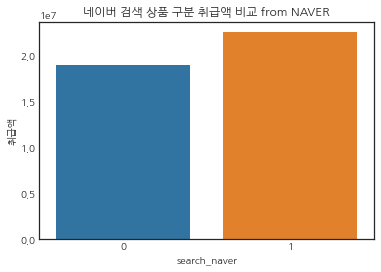

In [106]:
# 동일방송내 단가별 상품 취급액 비교
plt.figure(figsize=(6, 4))
plt.title('네이버 검색 상품 구분 취급액 비교 from NAVER')
sns.barplot(data=train.groupby('search_naver')['취급액'].mean().reset_index(), x='search_naver', y='취급액')
plt.show()

## 3.5 EDA_마더코드

## 추가로 피쳐를 만들어봅니다.

방영되는 제품들에 영향을 주는 외부 변수가 뭐가 있을까?

건강에 영향을 주는 뭔가가 있으려나?! 음...

아니면 제품 자체에 영향을 주는 뭔가가 있을 수도 있을 것 같은데<br>
예를 들면 농수산물이 너무 비싸거나 싸거나. 그래서 판매단가에 영향을 미치거나, 뉴스에 많이 언급이 되거나

홈쇼핑 매출 자체에 영향을 주는 요인은 뭐가 있을까. 사람이 밖으로 돌아다니는거?

# 4. Modeling

#### 학습세트 만들기

In [45]:
# 예측 값 추정이 불가능한 취급액 0원인 애들 제거해줍니다.

train = train[train.취급액 != 0]
train.shape

(35379, 43)

In [46]:
# 랜덤 샘플링
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

print(train_.shape)
print(test_.shape)

(28303, 43)
(7076, 43)


In [47]:
# 6월 데이터로 학습을 해서 val score 를 뽑아봅니다.
train_6 = train[train.방송일시_MM != '06']
test_6 = train[train.방송일시_MM == '06']

print(train_6.shape)
print(test_6.shape)

(32519, 43)
(2860, 43)


In [48]:
# train 셋의 아웃라이어를 제거해봅니다...1억 이상의 취급액을 가진 데이터가 약 1% 정도 있습니다.

train_ = train_[train_.취급액 < 100000000]
train_6 = train_6[train_6.취급액 < 100000000] # 6월 val 용
train_.shape, train_6.shape

((28150, 43), (32355, 43))

In [49]:
train_

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex,new_상품명,상품명_brand,fake_weight,fake_weight2,cat1,cat2,cat3,temperature,방송일시_dow,방송일시_MM,방송일시_DD,방송일시_hh,방송일시_mm,방송일시_MMDD,방송일시_DDhh,방송일시_hhmm,방송일시_MMDDhh,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,방송일시_dow2,review_counts,internet_price,price_minus,search_naver
19091,2019-07-02 14:40:00,20.0,100322,201479,국내산 손질갑오징어 8팩,농수축,49900,66880000,60.0,3,60.0,3.0,1.000000,0,0,0,0,0,손질갑오징어,손질,-1,0.0,식품,수산,해산물/어패류,41.6,1,07,02,14,40,0702,0214,1440,070214,33600,67200,470400,1,1747,17000,32900,1
36380,2019-12-20 07:00:00,20.0,100189,200633,코치 시그니처 레더 켈시 사첼백,잡화,229000,13077000,60.0,3,60.0,3.0,1.000000,0,0,0,0,0,코치 시그니처 레더 켈시 사첼백,코치,-1,0.0,패션잡화,여성가방,토트백,-0.8,4,12,20,07,00,1220,2007,0700,122007,0,0,0,1,182,157400,71600,1
925,2019-01-11 08:00:00,30.0,100336,201048,더블유베일 풀스킨 폭스카라 머스크랫 코트,의류,699000,28280000,30.0,1,60.0,2.0,0.500000,0,0,0,0,0,더블유베일 풀스킨 폭스카라 머스크랫 코트,더블,-1,0.0,패션의류,여성의류,레인코트,8.2,4,01,11,08,00,0111,1108,0800,011108,0,0,0,1,3,572490,126510,1
9934,2019-04-09 03:40:00,20.0,100266,200880,마리끌레르 파리컬렉션 리얼 하이드로 립스틱(2019리뉴얼),이미용,39900,29039000,60.0,3,60.0,3.0,1.000000,0,0,0,0,0,마리끌레르 파리컬렉션 리얼 하이드로 립스틱,마리,-1,0.0,화장품/미용,색조메이크업,립스틱,6.6,1,04,09,03,40,0409,0903,0340,040903,7200,64800,259200,1,0,0,39900,0
37051,2019-12-28 05:20:00,20.0,100264,200878,셀렉프로 뚝배기 전기밥솥(멀티쿠커),주방,79000,46738000,20.0,1,60.0,3.0,0.333333,0,0,0,0,0,셀렉프로 뚝배기 전기밥솥,셀렉,-1,0.0,디지털/가전,주방가전,전기밥솥,-3.0,5,12,28,05,20,1228,2805,0520,122805,6000,168000,2016000,0,10,79000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4162,2019-02-13 18:00:00,20.0,100155,200554,일시불 LG전자 매직스페이스 냉장고,가전,1409000,35192000,20.0,1,60.0,3.0,0.333333,1,0,2,0,0,LG전자 매직스페이스 냉장고,LG,-1,0.0,디지털/가전,주방가전,냉장고,-2.6,2,02,13,18,00,0213,1318,1800,021318,0,0,0,1,562,1493710,-84710,1
36205,2019-12-18 14:40:00,20.0,100673,202016,[세라맥스] 포터블 원적외선 전기렌인지,주방,99000,41069000,40.0,2,60.0,3.0,0.666667,0,0,0,0,0,세라맥스 포터블 원적외선 전기렌인지,세라,-1,0.0,디지털/가전,주방가전,하이라이트,3.9,2,12,18,14,40,1218,1814,1440,121814,33600,604800,7257600,1,282,98000,1000,1
37327,2019-12-31 14:20:00,20.0,100236,200806,벨라홈 스마트 멀티포트 1+1 세트,주방,39800,35005000,20.0,1,60.0,3.0,0.333333,0,1,0,1,0,벨라홈 스마트 멀티포트 세트,벨라,-1,0.0,디지털/가전,주방가전,전기포트,-1.3,1,12,31,14,20,1231,3114,1420,123114,16800,520800,6249600,1,15,31680,8120,1
21103,2019-07-20 18:20:00,20.0,100148,200525,일시불 LG 울트라HD TV 75UK6200KNB,가전,2700000,6139000,20.0,1,60.0,3.0,0.333333,1,0,2,0,0,LG 울트라HD TV 75UK NB,LG,-1,0.0,디지털/가전,영상가전,TV,27.2,5,07,20,18,20,0720,2018,1820,072018,21600,432000,3024000,0,23,1614990,1085010,1


In [42]:
# 라벨인코딩 숫자가 많아지니 함수로 만들어버립니다.

def label_encoding(train_, test_, columns, number):
    length = range(number)
    for c, i in zip(columns, length):
        # 라벨인코더 피팅
        globals()['encoder_{}:'.format(i)] = LabelEncoder()
        globals()['encoder_{}:'.format(i)].fit(train_[c].values)
        
        # 트레인셋에 트랜스폼
        train_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(train_[c])
        
        # 테스트셋에 트랜스폼
        for label in np.unique(test_[c]):
            if label not in globals()['encoder_{}:'.format(i)].classes_: # unseen label 데이터인 경우( )
                globals()['encoder_{}:'.format(i)].classes_ = np.append(globals()['encoder_{}:'.format(i)].classes_, label) # 미처리 시 ValueError발생
        test_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(test_[c])

In [43]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

# 함수로 바로 처리.
label_encoding(train_, test_, columns, number)
label_encoding(train_6, test_6, columns, number) # 6월 val 용

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
train_ = train_.drop(['방송일시', '상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명'], axis=1)

#### 학습시키기

In [206]:
features = ['노출(분)', '마더코드', '상품코드', '판매단가', 'cast_time', 'cast_count',
       'cast_time_sum', 'cast_count_sum', 'cast_time_ratio', '상품명_plan',
       '상품명_add', '상품명_maker', '상품명_set', '상품명_sex', 'fake_weight',
       'fake_weight2', 'temperature', '방송일시_dow', '방송일시_MM', '방송일시_DD',
       '방송일시_hh', '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm',
       '방송일시_MMDDhh', '방송일시_mmmm_1', '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2',
       'review_counts', 'price_minus', 'search_naver',
       'encoding_상품명:', 'encoding_상품군:',
       'encoding_상품명_brand:', 'encoding_cat1:', 'encoding_cat2:',
       'encoding_cat3:', 'encoding_new_상품명:'
           ]

label = '취급액'

In [267]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train = train_[features].values 
y_train = train_[label].values
X_test = test_[features].values 
y_test = test_[label].values

# 6월 학습용도 val 로 같이 봐줍니다.
X_train_6 = train_6[features].values 
y_train_6 = train_6[label].values
X_test_6 = test_6[features].values 
y_test_6 = test_6[label].values

KeyError: "['encoding_new_상품명:_72', 'encoding_상품명:_263', 'encoding_new_상품명:_1237', 'encoding_상품명:_227', '상품코드_200797', '마더코드_100346', 'encoding_상품명:_1415', 'encoding_상품명:_1609', '마더코드_100753', '상품코드_201227', 'encoding_new_상품명:_782', '방송일시_DDhh_0512', '마더코드_100281', 'encoding_상품명:_438', '상품코드_201309', 'encoding_상품명:_1616', '상품코드_200371', 'encoding_new_상품명:_399', '방송일시_DDhh_1407', 'encoding_new_상품명:_1185', '상품코드_202155', '방송일시_MMDD_0514', '방송일시_hhmm_2310', '상품코드_200744', 'encoding_상품명:_1529', 'encoding_상품명:_932', '상품코드_200738', '마더코드_100548', '방송일시_DD_07', '마더코드_100472', 'encoding_상품명:_372', '상품코드_202254', '상품코드_202169', 'encoding_상품명:_1258', 'encoding_상품명_brand:_77', 'encoding_상품명:_267', 'encoding_new_상품명:_978', '마더코드_100582', '상품코드_200570', 'encoding_상품명:_683', 'encoding_상품명:_80', 'encoding_cat2:_38', 'encoding_상품명:_910', 'encoding_상품명:_179', 'encoding_cat2:_22', '상품코드_200125', '상품코드_202044', 'encoding_상품명:_457', 'encoding_new_상품명:_965', 'encoding_new_상품명:_570', '상품코드_200171', '방송일시_MMDD_1115', '상품코드_200580', 'encoding_상품명:_166', '상품코드_200711', 'encoding_new_상품명:_73', '방송일시_mm_05', '방송일시_MMDD_0513', '상품코드_202342', '방송일시_DDhh_1217', 'encoding_상품명:_467', '상품코드_200275', 'encoding_상품명:_879', 'encoding_new_상품명:_747', 'encoding_cat3:_71', '상품코드_200261', 'encoding_상품명:_1144', 'encoding_new_상품명:_361', '방송일시_MM_06', 'encoding_cat2:_64', 'encoding_new_상품명:_320', '상품코드_201581', 'encoding_cat3:_129', '상품코드_200516', 'encoding_상품명:_1567', 'encoding_new_상품명:_669', '마더코드_100411', '상품코드_201541', '방송일시_hh_17', '상품코드_200643', 'encoding_cat3:_215', '상품코드_202033', '방송일시_MMDD_0307', 'encoding_상품명:_958', 'encoding_cat3:_95', 'encoding_new_상품명:_169', '상품코드_201061', 'encoding_상품명:_338', '상품코드_200249', '상품코드_201847', 'encoding_new_상품명:_86', 'encoding_new_상품명:_319', '방송일시_DDhh_0614', '마더코드_100010', '마더코드_100403', 'encoding_new_상품명:_599', '방송일시_DDhh_0806', '상품코드_201330', 'encoding_상품명:_1228', 'encoding_상품명:_308', 'encoding_상품명:_676', 'encoding_new_상품명:_284', '방송일시_MMDD_1014', 'encoding_상품명:_71', '상품코드_201214', 'encoding_상품명_brand:_84', '마더코드_100680', '마더코드_100569', '방송일시_MMDD_1223', '방송일시_MMDD_0527', '방송일시_DDhh_2703', 'encoding_상품명_brand:_315', '마더코드_100063', 'encoding_상품명:_473', '상품코드_201216', '상품코드_200073', 'encoding_new_상품명:_1235', 'encoding_new_상품명:_926', 'encoding_new_상품명:_838', '상품코드_202466', '상품코드_202060', '상품코드_201609', '방송일시_hhmm_2000', '상품코드_200739', '상품코드_201481', '방송일시_MMDD_0703', 'encoding_상품명:_268', '상품코드_201805', '방송일시_DDhh_0904', 'encoding_new_상품명:_975', '상품코드_200980', '상품코드_201469', '마더코드_100076', '방송일시_MMDD_0806', '상품코드_201839', 'encoding_상품명:_1073', 'encoding_new_상품명:_1108', '방송일시_DDhh_0405', 'encoding_new_상품명:_436', '방송일시_DDhh_2515', '상품코드_202345', 'encoding_상품명:_193', '상품코드_201633', '방송일시_MMDD_0224', 'encoding_new_상품명:_919', '마더코드_100157', '마더코드_100762', '방송일시_DDhh_1417', '방송일시_hh_20', '마더코드_100000', '상품코드_201236', '방송일시_DD_05', 'encoding_cat3:_175', 'encoding_상품명:_645', 'encoding_new_상품명:_977', 'encoding_new_상품명:_149', 'encoding_상품명:_1404', '상품코드_200442', 'encoding_new_상품명:_198', '방송일시_DDhh_0418', '상품코드_201003', '상품코드_202352', 'encoding_new_상품명:_836', '방송일시_MMDD_0324', 'encoding_상품명_brand:_48', 'encoding_상품명_brand:_229', '상품코드_202346', 'encoding_상품명:_729', '마더코드_100805', 'encoding_new_상품명:_1017', 'encoding_new_상품명:_421', '방송일시_DDhh_1509', 'encoding_상품명:_629', 'encoding_new_상품명:_764', 'encoding_new_상품명:_1242', '상품코드_201761', '방송일시_DDhh_1819', 'encoding_new_상품명:_586', '방송일시_MMDD_1103', 'encoding_new_상품명:_1195', '상품코드_200337', '방송일시_MMDD_0709', '방송일시_DDhh_2619', 'encoding_new_상품명:_1071', '방송일시_DDhh_2519', 'encoding_상품명:_1378', 'encoding_new_상품명:_304', '방송일시_DDhh_0613', 'encoding_new_상품명:_288', '마더코드_100594', 'encoding_상품명:_78', '마더코드_100481', 'encoding_상품명_brand:_31', 'encoding_상품명_brand:_382', 'encoding_cat3:_185', 'encoding_상품명_brand:_343', '방송일시_MMDD_0723', 'encoding_new_상품명:_148', '마더코드_100795', '마더코드_100165', '마더코드_100066', '상품코드_202020', 'encoding_new_상품명:_472', '방송일시_DDhh_1913', '방송일시_DDhh_2114', '방송일시_MMDD_1201', '방송일시_MMDD_0418', '상품코드_201232', '상품코드_202285', '방송일시_MMDD_0310', '상품코드_200653', '상품코드_200981', '방송일시_MMDD_1020', '상품코드_201703', 'encoding_상품명:_627', 'encoding_상품명_brand:_333', '상품코드_200826', '방송일시_DDhh_1219', '방송일시_DDhh_0310', 'encoding_new_상품명:_809', '상품코드_200511', 'encoding_new_상품명:_557', '상품코드_202016', 'encoding_상품명:_1167', 'encoding_new_상품명:_662', 'encoding_상품명:_1252', '방송일시_DDhh_3115', '상품코드_202456', 'encoding_new_상품명:_762', '방송일시_DDhh_2505', '마더코드_100468', '방송일시_DDhh_1403', '상품코드_201087', 'encoding_new_상품명:_321', 'encoding_new_상품명:_897', 'encoding_new_상품명:_848', '상품코드_200784', 'encoding_new_상품명:_1250', '상품코드_201787', '방송일시_MMDD_0322', '상품코드_200823', 'encoding_cat2:_37', 'encoding_상품명:_278', 'encoding_상품명:_781', 'encoding_cat3:_46', '상품코드_200652', '상품코드_201926', 'encoding_new_상품명:_287', '상품코드_201467', '방송일시_DDhh_2805', 'encoding_상품명:_1182', '상품코드_202093', '상품코드_202407', 'encoding_상품명:_1270', '방송일시_DDhh_1613', 'encoding_cat3:_119', '방송일시_DDhh_2215', 'encoding_상품명:_1493', '방송일시_hhmm_1615', 'encoding_new_상품명:_154', 'encoding_상품명:_1460', '상품코드_201413', 'encoding_상품명:_1040', 'encoding_new_상품명:_1021', '방송일시_hhmm_2020', 'encoding_상품명:_1491', '마더코드_100581', '상품코드_200977', 'encoding_new_상품명:_1000', 'encoding_상품명:_674', 'encoding_new_상품명:_735', 'encoding_new_상품명:_1206', 'encoding_cat3:_125', 'encoding_상품명_brand:_351', '마더코드_100418', 'encoding_cat2:_74', '상품코드_202015', '마더코드_100603', '방송일시_DDhh_0906', 'encoding_상품명:_1294', 'encoding_상품명:_442', '마더코드_100781', 'encoding_cat3:_231', '상품코드_201482', 'encoding_상품명:_1348', 'encoding_new_상품명:_867', '방송일시_DDhh_2022', 'encoding_상품명:_761', '마더코드_100628', '방송일시_DDhh_0116', '마더코드_100199', '방송일시_DDhh_1920', '방송일시_DDhh_1114', 'encoding_상품명:_735', '마더코드_100656', '방송일시_DDhh_0305', 'encoding_상품명:_302', '마더코드_100197', 'encoding_상품명_brand:_224', 'encoding_new_상품명:_406', '상품명_plan_1', 'encoding_new_상품명:_590', '방송일시_DDhh_1516', '상품코드_201855', 'encoding_상품명_brand:_361', 'encoding_new_상품명:_602', 'encoding_상품명:_1190', 'encoding_new_상품명:_730', '상품코드_200785', 'encoding_상품명:_1178', '마더코드_100479', '방송일시_DDhh_2021', '방송일시_DDhh_2811', 'encoding_상품명:_1627', 'encoding_상품명:_1006', '상품코드_200036', 'encoding_new_상품명:_232', 'encoding_new_상품명:_130', '방송일시_mm_45', '상품코드_202374', 'encoding_상품명:_281', '상품코드_202172', 'encoding_new_상품명:_405', 'encoding_상품명:_1003', 'encoding_상품명:_262', '상품코드_200829', '상품코드_202261', 'encoding_상품군:_3', '상품코드_201362', 'encoding_new_상품명:_209', '방송일시_DDhh_1123', 'encoding_new_상품명:_610', 'encoding_상품명:_659', '상품코드_201842', '마더코드_100564', '방송일시_DDhh_0818', 'encoding_new_상품명:_426', 'encoding_상품명:_1140', '상품코드_200893', '상품코드_201621', 'encoding_상품명:_594', '방송일시_MMDD_0406', 'encoding_상품명:_1564', '방송일시_hhmm_0720', '방송일시_DDhh_1009', '상품코드_202006', '방송일시_DDhh_0722', '방송일시_DDhh_1005', '상품코드_200091', 'encoding_상품명:_16', 'encoding_상품명:_554', 'encoding_new_상품명:_770', 'encoding_상품명:_397', '상품코드_200030', 'encoding_상품명:_215', '상품코드_200475', 'encoding_상품명:_299', '상품코드_200839', 'encoding_상품명:_1029', 'encoding_상품명:_1384', '마더코드_100211', 'encoding_상품명:_897', '마더코드_100061', '마더코드_100627', '상품코드_202091', 'encoding_상품명:_1389', 'encoding_new_상품명:_515', '방송일시_DD_08', 'encoding_상품명_brand:_75', 'encoding_상품명:_762', 'encoding_상품명:_1111', 'encoding_new_상품명:_303', '방송일시_DDhh_2222', 'encoding_new_상품명:_166', '상품코드_201932', '상품코드_201902', '방송일시_DDhh_1120', 'encoding_new_상품명:_942', 'encoding_상품명:_1079', 'encoding_상품명:_1380', '상품코드_200487', 'encoding_상품명:_1589', 'encoding_new_상품명:_424', '상품코드_200971', '마더코드_100320', '상품코드_200979', '마더코드_100782', '방송일시_MMDD_0503', 'encoding_상품명:_1058', 'encoding_new_상품명:_883', 'encoding_new_상품명:_705', '상품코드_200027', '상품코드_200247', 'encoding_상품명:_1597', 'encoding_new_상품명:_206', '상품코드_200686', '마더코드_100080', '상품코드_202180', '상품코드_202115', '상품코드_202171', 'encoding_new_상품명:_1091', '방송일시_DDhh_0210', '상품코드_201694', 'encoding_상품명:_923', 'encoding_new_상품명:_1097', '방송일시_DDhh_1405', '방송일시_DDhh_0914', '마더코드_100791', 'encoding_new_상품명:_344', '방송일시_DDhh_3106', 'encoding_상품명:_160', '마더코드_100019', '상품코드_200613', 'encoding_new_상품명:_1019', 'encoding_new_상품명:_614', 'encoding_new_상품명:_294', '방송일시_DDhh_1615', 'encoding_상품명:_99', '방송일시_DDhh_2908', 'encoding_new_상품명:_676', 'encoding_new_상품명:_496', 'encoding_cat3:_85', '방송일시_DD_11', 'encoding_상품명:_820', 'encoding_상품명:_961', 'encoding_상품명:_1552', 'encoding_new_상품명:_956', '방송일시_DDhh_2316', 'encoding_상품명:_1377', '상품코드_202030', 'encoding_상품명:_1275', 'encoding_상품명_brand:_279', '상품코드_201070', '상품코드_200084', '상품코드_201852', '마더코드_100675', '방송일시_MMDD_0209', '상품코드_200279', '상품코드_202493', '상품코드_202264', 'encoding_상품명:_846', 'encoding_new_상품명:_877', '상품코드_200897', '상품코드_200394', '상품코드_200075', 'encoding_상품명:_410', '상품코드_200583', 'encoding_상품명_brand:_176', '마더코드_100096', 'encoding_상품명:_483', 'encoding_상품명:_899', 'encoding_상품명:_521', 'encoding_상품명_brand:_162', 'encoding_상품명:_817', '방송일시_DDhh_2314', '상품코드_200197', '방송일시_DDhh_2910', '방송일시_hhmm_0415', '마더코드_100024', '마더코드_100115', '방송일시_DDhh_1912', 'encoding_new_상품명:_759', '상품코드_201489', 'encoding_상품명:_996', 'encoding_new_상품명:_219', '마더코드_100025', '상품코드_200042', 'encoding_상품명:_1624', 'encoding_상품명:_572', 'encoding_상품명_brand:_277', 'encoding_new_상품명:_269', 'encoding_상품명:_399', 'encoding_new_상품명:_717', 'encoding_상품명_brand:_275', 'encoding_new_상품명:_577', '상품코드_201947', 'encoding_new_상품명:_893', '방송일시_hhmm_0910', '상품코드_202281', '방송일시_MMDD_0706', 'encoding_new_상품명:_438', 'encoding_new_상품명:_390', 'encoding_상품명:_389', '방송일시_MMDD_0227', 'encoding_상품명:_597', '상품코드_201318', '방송일시_DDhh_2108', 'encoding_상품명:_1165', '상품코드_202184', 'encoding_상품명:_31', 'encoding_new_상품명:_58', '방송일시_DDhh_1620', '방송일시_DDhh_2014', '상품코드_202092', '상품코드_201288', 'encoding_상품명:_869', '상품코드_201921', '상품코드_202159', '방송일시_hhmm_0540', '마더코드_100747', 'encoding_new_상품명:_630', '상품코드_200808', 'encoding_상품명:_1443', '상품코드_200872', 'encoding_cat2:_19', 'encoding_상품명:_398', '방송일시_DDhh_1410', '방송일시_DDhh_1812', '상품코드_202445', '방송일시_DDhh_1504', 'encoding_상품명:_568', '방송일시_DDhh_1012', '상품코드_201509', 'encoding_상품명:_590', 'encoding_cat3:_198', 'encoding_상품명:_1522', 'encoding_new_상품명:_30', '상품코드_200796', 'encoding_cat3:_190', '방송일시_DDhh_0623', 'encoding_new_상품명:_847', 'encoding_new_상품명:_700', '상품코드_200311', '상품코드_201887', 'encoding_new_상품명:_642', '상품코드_202282', 'encoding_상품명:_1360', '방송일시_MMDD_0612', '상품코드_201264', '상품코드_201819', 'encoding_new_상품명:_1132', 'encoding_상품명_brand:_16', '상품코드_201967', '방송일시_DDhh_2005', 'encoding_상품명:_1599', '마더코드_100375', '상품코드_201200', '상품코드_200799', '상품코드_202373', '방송일시_DDhh_0807', 'encoding_상품명:_1020', '방송일시_DDhh_1113', 'encoding_상품명:_2', 'encoding_상품명:_992', 'encoding_new_상품명:_1128', '상품코드_200786', '방송일시_DDhh_1709', '마더코드_100221', '방송일시_hhmm_0750', '상품코드_202286', 'encoding_상품명_brand:_334', '방송일시_DDhh_0122', '마더코드_100114', '방송일시_DDhh_2903', 'encoding_상품명_brand:_307', 'encoding_상품명:_989', 'encoding_new_상품명:_910', '마더코드_100289', '마더코드_100053', 'encoding_cat3:_87', '상품코드_200954', '마더코드_100162', '방송일시_MMDD_0828', 'encoding_cat3:_209', 'encoding_상품명:_506', 'encoding_new_상품명:_265', 'encoding_상품명:_104', '상품코드_200388', '상품코드_201735', 'encoding_상품명:_1367', '마더코드_100150', '마더코드_100206', '마더코드_100539', 'encoding_new_상품명:_1225', 'encoding_cat3:_90', '마더코드_100683', 'encoding_new_상품명:_14', 'encoding_new_상품명:_917', '방송일시_hhmm_0530', '상품코드_200518', 'encoding_cat3:_93', 'encoding_상품명:_994', 'encoding_new_상품명:_1150', '마더코드_100224', '상품코드_201347', 'encoding_new_상품명:_1124', 'encoding_new_상품명:_1233', '상품코드_201479', 'encoding_new_상품명:_667', '상품코드_200978', 'encoding_cat3:_82', '방송일시_DDhh_1008', '상품코드_201358', 'encoding_new_상품명:_376', 'encoding_new_상품명:_663', '방송일시_hhmm_1200', 'encoding_상품명_brand:_188', 'encoding_new_상품명:_1172', 'encoding_상품명_brand:_110', 'encoding_상품명_brand:_105', '상품코드_200200', '방송일시_DDhh_0303', 'encoding_상품명:_1534', '마더코드_100478', '상품코드_200070', '방송일시_MMDD_1008', '마더코드_100093', 'encoding_cat3:_174', '상품코드_200847', 'encoding_상품명:_1602', '마더코드_100752', '상품코드_200461', '마더코드_100643', 'encoding_new_상품명:_856', '상품코드_201235', 'encoding_상품명:_81', 'encoding_상품명:_712', 'encoding_cat3:_235', '상품코드_200332', '상품코드_201213', 'encoding_상품명:_1172', 'encoding_상품명_brand:_281', 'encoding_상품명:_254', '마더코드_100565', 'encoding_상품명:_1169', '상품코드_202501', 'encoding_상품명:_68', 'encoding_상품명:_500', 'encoding_상품명:_581', 'encoding_new_상품명:_482', '상품코드_201031', '방송일시_MMDD_0403', 'encoding_상품명:_478', 'encoding_new_상품명:_740', '방송일시_MMDD_0918', 'encoding_cat3:_136', 'encoding_new_상품명:_210', 'encoding_new_상품명:_840', '마더코드_100387', 'encoding_new_상품명:_1117', '상품코드_201610', '방송일시_DDhh_2422', 'encoding_상품명:_1022', '마더코드_100107', '상품코드_201800', '마더코드_100163', '방송일시_MMDD_0728', '상품코드_201317', '상품코드_201702', 'encoding_new_상품명:_346', 'encoding_상품명_brand:_173', '상품코드_200298', 'encoding_상품명:_1461', '상품코드_201488', 'encoding_상품명:_1064', 'encoding_new_상품명:_755', '마더코드_100336', '방송일시_MMDD_0807', 'encoding_new_상품명:_564', 'encoding_new_상품명:_843', '방송일시_DDhh_1606', '마더코드_100744', 'encoding_new_상품명:_437', 'encoding_cat3:_159', 'encoding_new_상품명:_1219', '상품코드_200377', '방송일시_MMDD_0205', 'encoding_상품명:_1551', '상품코드_200604', 'encoding_new_상품명:_1047', 'encoding_new_상품명:_109', 'encoding_new_상품명:_955', 'encoding_상품명:_1587', '마더코드_100415', '상품코드_201630', '방송일시_DD_29', '방송일시_MMDD_0924', 'encoding_상품명:_1194', '마더코드_100191', 'encoding_cat3:_147', '상품코드_200307', '방송일시_DDhh_1222', 'encoding_상품명:_187', 'encoding_상품명:_103', 'encoding_상품명:_591', '상품코드_200719', 'encoding_상품명:_1099', 'encoding_new_상품명:_371', '상품코드_200842', 'encoding_new_상품명:_852', '방송일시_DDhh_1520', 'encoding_상품명:_1318', '방송일시_DDhh_0622', '상품코드_202408', '방송일시_DDhh_0313', '방송일시_DDhh_0809', '방송일시_hhmm_1635', 'encoding_new_상품명:_78', 'encoding_new_상품명:_272', '방송일시_hhmm_1630', '방송일시_DDhh_0708', 'encoding_상품명:_434', '상품코드_201470', '방송일시_DDhh_0307', '방송일시_DDhh_0118', 'encoding_new_상품명:_539', '상품코드_201801', '방송일시_MMDD_0119', '방송일시_MMDD_1112', '상품코드_200695', 'encoding_cat2:_47', '방송일시_DDhh_0913', 'encoding_상품명:_332', 'encoding_상품명_brand:_210', '상품코드_202197', 'encoding_cat3:_86', '상품코드_202025', 'encoding_new_상품명:_236', 'encoding_new_상품명:_960', 'encoding_new_상품명:_136', 'encoding_new_상품명:_413', 'encoding_상품명:_1048', '상품코드_200685', 'encoding_상품명:_535', '상품코드_200342', 'encoding_new_상품명:_477', '방송일시_MMDD_0805', '상품코드_201071', 'encoding_상품명:_941', '상품코드_200758', 'encoding_new_상품명:_222', '방송일시_DDhh_0709', 'encoding_new_상품명:_572', '상품코드_200032', '방송일시_MMDD_0102', 'encoding_상품명:_1181', 'encoding_new_상품명:_225', 'encoding_상품명:_938', 'encoding_상품명_brand:_179', 'encoding_new_상품명:_313', '방송일시_hhmm_2300', '마더코드_100734', '방송일시_hhmm_1120', '마더코드_100147', 'encoding_상품명:_378', 'encoding_상품명:_777', 'encoding_상품명:_1559', '상품코드_200804', 'encoding_상품명:_154', 'encoding_상품명_brand:_145', 'encoding_new_상품명:_138', 'encoding_new_상품명:_385', 'encoding_상품명:_649', 'encoding_상품명:_895', 'encoding_new_상품명:_290', 'encoding_new_상품명:_416', '마더코드_100536', 'encoding_상품명:_6', 'encoding_new_상품명:_273', '상품코드_201346', 'encoding_new_상품명:_598', '상품코드_200130', 'encoding_상품명:_1517', '방송일시_dow2_1', 'encoding_상품명:_1383', 'encoding_cat3:_246', '상품코드_200964', '방송일시_DDhh_1915', 'encoding_상품명:_1662', '마더코드_100831', '상품코드_201711', 'encoding_상품명:_87', '상품코드_201544', 'encoding_상품명:_101', 'encoding_new_상품명:_173', '마더코드_100318', '마더코드_100572', '방송일시_hhmm_1340', '상품코드_202414', '방송일시_dow2_0', 'encoding_new_상품명:_645', 'encoding_new_상품명:_1145', '방송일시_DDhh_1719', '마더코드_100342', 'encoding_상품명:_439', '상품코드_201579', 'encoding_상품명_brand:_68', 'encoding_상품명:_714', '방송일시_DDhh_2512', '상품코드_200972', 'encoding_상품명:_109', '방송일시_MMDD_0822', '상품코드_201192', '방송일시_MMDD_0727', '마더코드_100839', '상품코드_202116', 'encoding_new_상품명:_1113', 'encoding_new_상품명:_369', '방송일시_hhmm_1530', 'encoding_상품명:_1042', 'encoding_상품명:_164', 'encoding_cat3:_154', 'encoding_new_상품명:_194', 'encoding_상품명:_1189', '방송일시_MMDD_0820', '상품코드_201199', '상품코드_200731', 'encoding_상품명_brand:_227', '마더코드_100466', 'encoding_new_상품명:_308', 'encoding_new_상품명:_258', 'encoding_cat2:_73', '상품코드_200252', '마더코드_100292', '상품코드_201321', 'encoding_상품명:_985', '상품코드_200904', '상품코드_201983', '상품코드_200085', 'encoding_상품명:_236', '방송일시_mm_50', '방송일시_MMDD_0905', 'encoding_상품명:_1600', '상품코드_200448', 'encoding_상품명_brand:_112', 'encoding_상품명:_680', '방송일시_MMDD_0825', '상품코드_200541', '방송일시_MMDD_0318', '마더코드_100069', '방송일시_DDhh_1917', '마더코드_100102', 'encoding_new_상품명:_752', '상품코드_200869', '마더코드_100420', '방송일시_DDhh_2020', '상품코드_201080', 'encoding_상품명:_898', 'encoding_new_상품명:_984', 'encoding_new_상품명:_525', '방송일시_DDhh_0203', '마더코드_100328', 'encoding_상품명:_560', '상품코드_200135', '마더코드_100436', '상품코드_202377', '상품코드_201186', 'encoding_상품명:_1085', 'encoding_상품명:_177', '상품코드_201415', 'encoding_cat3:_197', 'encoding_상품명:_1558', '마더코드_100117', 'encoding_상품명:_18', '상품코드_200459', '방송일시_DDhh_1118', '방송일시_DDhh_2312', 'encoding_cat3:_36', '방송일시_DDhh_3114', '마더코드_100256', 'encoding_new_상품명:_967', '마더코드_100547', '방송일시_DDhh_2413', 'encoding_상품명:_206', '상품코드_201205', '상품코드_200220', 'encoding_new_상품명:_971', '방송일시_DDhh_2423', 'encoding_new_상품명:_465', '방송일시_DDhh_1020', '상품코드_201034', 'encoding_상품명_brand:_368', 'encoding_cat2:_27', '상품코드_200476', '상품코드_200038', '방송일시_MMDD_1107', 'encoding_new_상품명:_1135', '방송일시_hhmm_1040', 'encoding_cat2:_11', '상품코드_200454', 'encoding_new_상품명:_805', 'encoding_new_상품명:_504', '상품코드_201032', 'encoding_new_상품명:_1006', 'encoding_cat3:_54', '상품코드_202429', 'encoding_상품명:_837', 'encoding_상품명:_1117', '상품코드_202513', 'encoding_new_상품명:_553', '상품코드_200694', '상품코드_201496', 'encoding_상품명:_266', '방송일시_DDhh_1420', '방송일시_DDhh_2323', '상품코드_200812', 'encoding_상품명:_63', '상품코드_200061', 'encoding_상품명_brand:_99', '상품코드_202365', 'encoding_상품명:_861', 'encoding_new_상품명:_29', '상품코드_200664', 'encoding_상품명:_27', '방송일시_DDhh_0711', 'encoding_상품명:_939', 'encoding_상품명:_744', '상품코드_200095', 'encoding_new_상품명:_1114', 'encoding_상품명:_884', 'encoding_상품명:_331', 'encoding_cat3:_96', '상품코드_200828', 'encoding_상품명:_519', '상품코드_200172', 'encoding_new_상품명:_133', 'encoding_상품명:_1277', '방송일시_hhmm_1545', 'encoding_상품명_brand:_163', '상품코드_202458', 'encoding_new_상품명:_842', '상품코드_201135', 'encoding_상품명:_290', 'encoding_cat3:_62', '방송일시_DDhh_1723', 'encoding_cat3:_135', '마더코드_100124', 'encoding_new_상품명:_6', '상품코드_201046', '상품코드_200985', '상품코드_200951', 'encoding_상품명:_1556', '방송일시_DDhh_2103', 'encoding_상품명:_345', 'encoding_new_상품명:_896', '상품코드_200339', '상품코드_202179', 'encoding_상품명:_691', '방송일시_DDhh_0608', '상품코드_200944', '방송일시_DDhh_2615', '마더코드_100226', 'encoding_cat3:_94', '방송일시_MMDD_0808', 'encoding_상품명:_1225', '방송일시_MMDD_0604', '방송일시_MMDD_0926', '상품코드_202105', '상품코드_200836', '마더코드_100374', 'encoding_new_상품명:_187', 'encoding_상품명:_1345', 'encoding_상품명:_1127', 'encoding_상품명:_1120', '방송일시_DDhh_2012', 'encoding_new_상품명:_2', '마더코드_100176', 'encoding_상품명:_913', '상품코드_200576', '상품코드_200088', '마더코드_100792', '상품코드_200896', 'encoding_new_상품명:_1216', 'encoding_상품명:_1273', '마더코드_100720', '상품코드_200253', '마더코드_100841', 'encoding_new_상품명:_699', 'encoding_new_상품명:_511', 'encoding_new_상품명:_110', '상품코드_201245', '상품코드_202160', 'encoding_상품명:_221', '상품코드_202369', '방송일시_MMDD_0331', 'encoding_상품명:_427', 'encoding_상품명:_234', 'encoding_new_상품명:_285', '방송일시_MMDD_0606', '방송일시_MMDD_0521', 'encoding_new_상품명:_508', 'encoding_new_상품명:_88', '방송일시_MMDD_1125', '마더코드_100243', '상품코드_202316', 'encoding_상품명:_355', 'encoding_상품명:_325', '상품코드_201890', 'encoding_상품명:_1342', '방송일시_MMDD_0818', '방송일시_hhmm_1710', '상품코드_201683', '상품코드_200909', 'encoding_cat3:_58', '방송일시_MMDD_0131', '상품코드_200452', 'encoding_상품명:_529', 'encoding_new_상품명:_1166', '방송일시_DDhh_2013', 'encoding_상품명:_537', 'encoding_new_상품명:_691', '상품코드_202165', '마더코드_100315', '마더코드_100395', 'encoding_상품명:_400', 'encoding_new_상품명:_706', 'encoding_상품명:_169', '상품코드_201746', 'encoding_상품명:_574', 'encoding_상품명:_507', '마더코드_100682', 'encoding_new_상품명:_998', 'encoding_상품명:_1554', 'encoding_new_상품명:_63', 'encoding_new_상품명:_878', 'encoding_new_상품명:_315', '마더코드_100057', '상품코드_201853', 'encoding_상품명:_1518', '마더코드_100081', '상품코드_201514', 'encoding_상품명_brand:_213', 'encoding_상품명:_1056', '마더코드_100302', '상품코드_200391', '방송일시_MMDD_0601', '상품코드_202260', 'encoding_cat1:_5', '상품코드_201161', '방송일시_MMDD_1024', '방송일시_hhmm_0610', 'encoding_new_상품명:_458', 'encoding_상품명:_1062', '마더코드_100836', 'encoding_상품명_brand:_287', '마더코드_100232', 'encoding_new_상품명:_1034', '방송일시_MMDD_0405', 'encoding_상품명:_564', '마더코드_100549', 'encoding_상품명:_354', 'encoding_new_상품명:_36', '상품코드_200556', 'encoding_new_상품명:_678', 'encoding_상품명_brand:_21', '상품코드_200120', '상품코드_202353', '방송일시_MMDD_1121', '상품코드_201221', 'encoding_new_상품명:_595', '마더코드_100845', 'encoding_상품명:_11', '방송일시_MMDD_0519', 'encoding_상품명:_1002', 'encoding_new_상품명:_350', 'encoding_상품명:_1116', 'encoding_상품명:_1162', '상품코드_201748', '상품코드_201803', 'encoding_상품명:_1184', 'encoding_상품명:_1180', 'encoding_cat3:_4', '상품코드_201736', 'encoding_상품명_brand:_240', 'encoding_상품명:_1316', 'encoding_상품명:_890', '상품코드_202237', '상품코드_202081', 'encoding_상품명:_1647', 'encoding_cat3:_107', '방송일시_MMDD_0719', 'encoding_new_상품명:_864', '상품코드_200473', 'encoding_상품명:_320', '방송일시_DDhh_0812', '상품코드_200081', 'encoding_new_상품명:_280', '방송일시_DDhh_1015', '상품코드_201424', '방송일시_MMDD_1002', '방송일시_DDhh_1112', 'encoding_상품명:_1066', '상품코드_200352', 'encoding_상품명:_553', 'encoding_cat3:_201', '마더코드_100736', 'encoding_상품명:_583', 'encoding_상품명:_741', 'encoding_상품명:_1247', 'encoding_상품명:_1055', '상품코드_202161', '방송일시_DDhh_1209', 'encoding_cat3:_116', '방송일시_DDhh_1419', 'encoding_new_상품명:_333', '상품코드_202005', 'encoding_상품명:_152', '상품코드_201285', 'encoding_cat3:_227', 'encoding_new_상품명:_527', 'encoding_new_상품명:_1192', 'encoding_상품명:_1659', 'encoding_상품명_brand:_82', '마더코드_100583', 'encoding_상품명:_1218', '방송일시_MMDD_1123', 'encoding_상품명:_657', '상품코드_202416', 'encoding_상품명_brand:_61', '상품코드_201238', '상품코드_201483', 'encoding_cat3:_0', '상품코드_200278', 'encoding_new_상품명:_579', 'encoding_상품명:_413', 'encoding_상품명:_1119', 'encoding_new_상품명:_18', '상품코드_202168', '방송일시_MMDD_0220', 'encoding_상품명:_725', 'encoding_new_상품명:_641', 'encoding_cat3:_64', 'encoding_상품명_brand:_316', '상품코드_202403', '마더코드_100849', 'encoding_상품명:_1005', '방송일시_hhmm_1440', '상품코드_200333', 'encoding_new_상품명:_435', 'encoding_상품명:_1175', 'encoding_상품명:_1093', '방송일시_MMDD_0724', '상품코드_200133', 'encoding_상품명_brand:_323', 'encoding_상품명_brand:_104', '방송일시_DDhh_1019', 'encoding_cat3:_28', '상품코드_201484', 'encoding_new_상품명:_1035', '상품코드_202302', '마더코드_100239', '상품코드_200781', '상품코드_201209', 'encoding_상품명_brand:_126', '상품코드_202126', '상품코드_202250', '상품코드_200800', '상품코드_202130', 'encoding_상품명:_300', '방송일시_MMDD_0107', 'encoding_상품명:_1000', '방송일시_DDhh_2816', 'encoding_상품명:_1475', 'encoding_상품명_brand:_392', 'encoding_상품명:_107', '상품코드_200756', 'encoding_상품명:_1511', '방송일시_DDhh_2604', '상품코드_201217', '방송일시_MMDD_0515', '상품코드_202255', 'encoding_상품명:_230', '방송일시_DDhh_2112', '방송일시_DDhh_2207', 'encoding_상품명:_1464', 'encoding_new_상품명:_262', 'encoding_new_상품명:_1214', '상품코드_200933', '방송일시_hhmm_0440', 'encoding_상품명:_1424', '방송일시_DDhh_2917', 'encoding_new_상품명:_1093', '상품코드_201181', 'encoding_new_상품명:_174', '상품코드_200505', '상품코드_202163', 'encoding_상품명:_1025', 'encoding_상품명:_111', 'encoding_상품명:_562', '상품코드_201001', '상품코드_201448', '상품코드_200895', '상품코드_200219', '방송일시_MMDD_0203', 'encoding_new_상품명:_237', 'encoding_상품명:_1097', 'encoding_상품명:_800', '상품코드_202325', '상품코드_201688', '마더코드_100597', '방송일시_MMDD_0921', '상품코드_201306', 'encoding_cat2:_26', 'encoding_new_상품명:_40', '방송일시_DDhh_1211', 'encoding_new_상품명:_305', 'encoding_상품명_brand:_348', '상품코드_200244', '상품코드_200637', 'encoding_new_상품명:_213', '상품코드_200602', '상품코드_202467', 'encoding_cat3:_243', 'encoding_상품명:_770', '방송일시_MMDD_0124', '마더코드_100196', 'encoding_new_상품명:_948', '상품코드_201794', 'encoding_상품명:_1653', '상품코드_202089', 'encoding_상품명:_309', '상품코드_202208', 'encoding_new_상품명:_1180', 'encoding_new_상품명:_415', '상품코드_200494', 'encoding_상품명:_673', 'encoding_new_상품명:_145', 'encoding_상품명_brand:_72', '상품코드_201431', '상품코드_201587', '상품코드_200373', '방송일시_DD_01', '방송일시_MMDD_0912', 'encoding_상품명:_47', 'encoding_new_상품명:_1177', '상품코드_200176', '마더코드_100208', 'encoding_상품명:_151', 'encoding_상품명:_1088', '마더코드_100341', '방송일시_DDhh_2203', '방송일시_MMDD_0312', 'encoding_상품명_brand:_140', '상품코드_201325', 'encoding_상품명:_1284', '방송일시_MMDD_0501', '마더코드_100234', 'encoding_상품명_brand:_17', '방송일시_DDhh_0413', 'encoding_new_상품명:_603', '상품코드_200009', '방송일시_MMDD_0714', '상품코드_201796', 'encoding_상품명:_841', '방송일시_MMDD_0702', '상품코드_201182', '상품코드_201604', '방송일시_hhmm_1020', 'encoding_상품명:_1513', '마더코드_100677', 'encoding_new_상품명:_235', 'encoding_상품명_brand:_167', '상품코드_202026', '방송일시_DDhh_2216', 'encoding_cat3:_168', '마더코드_100031', '마더코드_100284', '상품코드_201773', '상품코드_201906', 'encoding_new_상품명:_769', 'encoding_상품명:_395', '방송일시_DDhh_3119', '상품코드_200031', 'encoding_상품명:_1639', 'encoding_상품명:_979', '마더코드_100786', '마더코드_100045', 'encoding_상품명:_143', 'encoding_상품명:_1432', 'encoding_상품명:_648', 'encoding_new_상품명:_1251', 'encoding_상품명:_518', '상품코드_202177', '마더코드_100604', '상품코드_201207', 'encoding_상품명_brand:_254', 'encoding_new_상품명:_548', '마더코드_100766', '마더코드_100704', '상품코드_200277', 'encoding_상품명:_794', 'encoding_new_상품명:_65', '상품코드_200413', '상품코드_200922', '상품코드_200256', '방송일시_MM_08', 'encoding_new_상품명:_1186', 'encoding_상품명_brand:_95', 'encoding_cat3:_146', '마더코드_100118', '상품코드_201425', '상품코드_200642', '방송일시_DDhh_0716', '마더코드_100178', 'encoding_상품명_brand:_311', 'encoding_cat3:_26', 'encoding_new_상품명:_1008', 'encoding_new_상품명:_743', 'encoding_상품명:_758', '상품코드_202475', '마더코드_100464', '마더코드_100269', '방송일시_MMDD_0424', 'encoding_상품명:_511', '마더코드_100086', 'encoding_new_상품명:_1057', '방송일시_MMDD_0111', '상품코드_201691', 'encoding_상품명_brand:_129', 'encoding_new_상품명:_433', '상품코드_201685', 'encoding_상품명_brand:_42', 'encoding_상품명:_219', 'encoding_상품명:_1023', '방송일시_MMDD_0522', 'encoding_new_상품명:_1033', 'encoding_cat2:_18', 'encoding_상품명:_337', '상품코드_201141', '마더코드_100254', '상품코드_201146', '상품코드_201388', '상품코드_201999', 'encoding_new_상품명:_15', 'encoding_상품명:_1263', '상품코드_200464', 'encoding_new_상품명:_1076', '방송일시_DDhh_2107', 'encoding_cat2:_0', 'encoding_상품명:_83', 'encoding_상품명:_1142', 'encoding_cat3:_48', '방송일시_DDhh_0611', '방송일시_DDhh_2813', 'encoding_cat3:_153', 'encoding_상품명:_805', '마더코드_100636', '상품코드_201142', '방송일시_DDhh_0619', 'encoding_상품명:_705', 'encoding_상품명_brand:_185', 'encoding_상품명_brand:_116', 'encoding_cat3:_74', '방송일시_DD_12', 'encoding_cat3:_68', 'encoding_상품명:_1201', '상품코드_200699', '상품코드_200427', '마더코드_100775', '상품코드_201260', 'encoding_상품명:_425', '방송일시_DDhh_1422', '마더코드_100586', '상품코드_200430', '상품코드_201211', 'encoding_상품명:_284', 'encoding_상품명:_352', 'encoding_new_상품명:_787', 'encoding_new_상품명:_1199', 'encoding_상품명:_1191', '상품코드_200884', '상품코드_200735', 'encoding_cat3:_210', '방송일시_DDhh_0415', '상품코드_201421', '방송일시_MMDD_0917', '상품코드_200618', '상품코드_200100', '방송일시_DDhh_0304', '상품코드_201348', '마더코드_100249', 'encoding_상품명:_492', '마더코드_100043', 'encoding_new_상품명:_264', '방송일시_hhmm_1220', 'encoding_new_상품명:_157', '방송일시_MMDD_0927', 'encoding_new_상품명:_454', 'encoding_cat3:_91', '상품코드_200700', 'encoding_상품명:_862', '상품코드_201883', '상품코드_200237', '방송일시_DD_10', '상품코드_201499', '마더코드_100103', '상품코드_200491', 'encoding_상품명:_592', 'encoding_상품명_brand:_193', 'encoding_상품명_brand:_55', 'encoding_상품명:_1581', '마더코드_100343', 'encoding_상품명:_904', '상품코드_200666', 'encoding_상품명:_351', '상품코드_201054', 'encoding_new_상품명:_1052', '상품코드_200207', '마더코드_100808', 'encoding_new_상품명:_1230', 'encoding_상품명:_1293', '방송일시_MMDD_1007', '마더코드_100585', 'encoding_cat3:_165', 'encoding_new_상품명:_1110', 'encoding_상품명:_633', 'encoding_cat3:_141', 'encoding_new_상품명:_559', 'encoding_상품명:_652', '방송일시_MMDD_0523', '상품코드_201799', 'encoding_상품명:_1408', '상품코드_200880', 'encoding_상품명:_711', '방송일시_hhmm_0830', '상품코드_201393', 'encoding_상품명:_1291', '상품코드_201590', '마더코드_100242', '상품코드_202401', '방송일시_MMDD_1011', 'encoding_상품명:_1395', 'encoding_상품명:_86', '방송일시_hhmm_0450', '상품코드_200082', '마더코드_100840', '상품코드_200366', 'encoding_상품명:_924', 'encoding_상품명:_1583', 'encoding_상품명:_1398', '상품코드_200859', 'encoding_상품명_brand:_237', '마더코드_100758', 'encoding_new_상품명:_1231', 'encoding_상품명_brand:_238', '마더코드_100803', 'encoding_상품명:_540', '상품코드_201903', 'encoding_상품명:_802', '상품코드_200033', 'encoding_상품명:_1288', '상품코드_201438', 'encoding_new_상품명:_293', '방송일시_DDhh_0416', '방송일시_MMDD_1128', 'encoding_상품명:_1310', 'encoding_new_상품명:_270', 'encoding_new_상품명:_1061', 'encoding_상품명:_644', 'encoding_cat2:_7', '상품코드_201195', 'encoding_상품명:_1210', '마더코드_100240', 'encoding_상품명:_1312', '상품코드_200348', '방송일시_MMDD_0216', '상품코드_200955', 'encoding_cat2:_23', '방송일시_DDhh_1304', '상품코드_200117', 'encoding_cat2:_6', '마더코드_100200', 'encoding_상품명_brand:_290', 'encoding_상품명:_1508', '상품코드_201877', 'encoding_cat2:_59', '마더코드_100697', 'encoding_상품명:_1471', '상품코드_202202', '방송일시_DDhh_2211', '방송일시_DDhh_0322', 'encoding_new_상품명:_461', '방송일시_MMDD_0219', '방송일시_DDhh_0408', 'encoding_상품명_brand:_293', '상품코드_200531', '방송일시_MMDD_0402', 'encoding_new_상품명:_1069', 'encoding_상품명:_1282', 'encoding_상품명_brand:_305', '상품코드_200138', 'encoding_상품명:_453', '상품코드_202272', '마더코드_100642', '상품코드_202308', 'encoding_상품명_brand:_87', '방송일시_DDhh_1312', '상품코드_200401', '상품코드_200512', '상품코드_202276', 'encoding_new_상품명:_1040', '방송일시_DDhh_0703', '상품코드_200581', 'encoding_상품명:_149', '방송일시_MMDD_0114', 'encoding_상품명:_1267', 'encoding_상품명:_557', '상품코드_201532', '상품코드_200989', '방송일시_DDhh_1108', 'encoding_상품명_brand:_191', 'encoding_new_상품명:_920', '상품코드_200128', 'encoding_new_상품명:_765', 'encoding_상품명:_165', 'encoding_상품명_brand:_211', 'encoding_new_상품명:_23', 'encoding_상품명:_504', 'encoding_상품명:_1122', 'encoding_new_상품명:_1086', '마더코드_100754', 'encoding_상품명:_878', '상품코드_201377', '상품코드_202383', '마더코드_100506', 'encoding_상품명:_1197', 'encoding_상품명:_1281', 'encoding_상품명:_816', 'encoding_상품명:_1387', '상품코드_200961', 'encoding_상품명:_1238', 'encoding_상품명:_1457', 'encoding_상품명:_558', 'encoding_상품명_brand:_223', '상품코드_200718', 'encoding_cat3:_49', 'encoding_new_상품명:_278', 'encoding_new_상품명:_901', '방송일시_DDhh_2814', '방송일시_DDhh_0219', 'encoding_new_상품명:_197', '방송일시_MMDD_1102', '상품코드_201897', '상품코드_200529', 'encoding_new_상품명:_1179', 'encoding_상품명_brand:_219', 'encoding_상품명:_1549', 'encoding_new_상품명:_912', 'encoding_cat2:_10', 'encoding_cat3:_73', '상품코드_200287', 'encoding_상품명_brand:_143', '상품코드_202372', '상품코드_202473', 'encoding_new_상품명:_1164', 'encoding_상품명_brand:_101', '상품코드_201547', '상품코드_200315', '상품코드_201137', '상품코드_200269', 'encoding_상품명_brand:_269', '방송일시_MMDD_0608', 'encoding_상품명:_760', 'encoding_new_상품명:_933', 'encoding_상품명_brand:_372', '상품코드_200054', '상품코드_200312', 'encoding_상품명:_1135', 'encoding_상품명:_1553', 'encoding_상품명:_1160', 'encoding_상품명:_967', 'encoding_상품명:_1033', 'encoding_상품명:_190', 'encoding_new_상품명:_295', 'encoding_상품명:_1618', '상품코드_200770', '방송일시_DDhh_3021', '상품코드_200047', '상품코드_200549', '마더코드_100467', '방송일시_DDhh_1316', 'encoding_상품군:_0', '상품코드_202076', '마더코드_100156', 'encoding_상품명:_65', 'encoding_cat3:_145', '마더코드_100774', '방송일시_DDhh_0508', 'encoding_new_상품명:_1156', 'encoding_new_상품명:_471', 'encoding_상품명:_1397', 'encoding_상품명:_896', '방송일시_DDhh_1214', '방송일시_DDhh_2311', 'encoding_new_상품명:_215', '마더코드_100618', '상품코드_201962', 'encoding_new_상품명:_821', '방송일시_DDhh_2404', 'encoding_상품명:_1242', '상품코드_200790', '방송일시_DDhh_0707', 'encoding_상품명:_58', '상품코드_201845', '방송일시_DDhh_2907', 'encoding_상품명:_827', '상품코드_201605', '마더코드_100134', 'encoding_cat3:_98', 'encoding_new_상품명:_1187', '상품코드_200546', 'encoding_상품명:_885', 'encoding_상품명:_1223', 'encoding_상품명:_1045', '방송일시_DDhh_2223', 'encoding_cat2:_34', '방송일시_MMDD_0121', '방송일시_DDhh_2719', '마더코드_100787', 'encoding_상품명:_778', 'encoding_new_상품명:_115', '상품코드_201486', 'encoding_new_상품명:_43', 'encoding_new_상품명:_137', '방송일시_hh_05', 'encoding_상품명_brand:_50', '상품코드_200540', '방송일시_MMDD_0330', 'encoding_new_상품명:_108', 'encoding_cat1:_8', '방송일시_MMDD_1205', 'encoding_상품명:_608', '상품코드_200499', '상품코드_201872', '방송일시_DDhh_1318', 'encoding_cat3:_24', '마더코드_100770', '방송일시_DDhh_0803', 'encoding_상품명_brand:_74', '방송일시_DDhh_2019', '마더코드_100334', 'encoding_상품명:_522', 'encoding_new_상품명:_1118', 'encoding_상품명_brand:_2', '상품코드_201793', 'encoding_상품명:_1139', '상품코드_201194', 'encoding_상품명:_579', '상품코드_202488', '마더코드_100295', 'encoding_cat3:_133', 'encoding_상품명:_200', 'encoding_상품명:_852', 'encoding_new_상품명:_1217', 'encoding_상품명:_305', 'encoding_new_상품명:_702', 'encoding_상품명:_471', '마더코드_100438', '방송일시_DDhh_2821', '상품코드_202045', 'encoding_new_상품명:_297', '마더코드_100314', 'encoding_상품명:_772', 'encoding_new_상품명:_407', 'encoding_상품명:_688', '상품코드_201060', '마더코드_100516', 'encoding_상품명_brand:_149', 'encoding_new_상품명:_512', '방송일시_DDhh_0205', 'encoding_cat3:_35', '상품코드_202385', '방송일시_DDhh_2209', 'encoding_new_상품명:_811', '상품코드_201561', '상품코드_200515', 'encoding_상품명:_1215', '상품코드_200821', '마더코드_100743', 'encoding_상품명:_49', '마더코드_100789', '상품코드_200732', 'encoding_상품명:_1186', '상품코드_201823', '상품코드_202235', 'encoding_new_상품명:_757', 'encoding_cat3:_138', '상품코드_202190', 'encoding_상품명:_699', '방송일시_hh_14', '마더코드_100126', '방송일시_MMDD_0319', 'encoding_new_상품명:_519', '상품코드_201411', 'encoding_상품명:_977', '상품코드_200365', '방송일시_MMDD_0914', '방송일시_hhmm_1300', 'encoding_상품명:_41', '상품코드_201079', '마더코드_100270', '마더코드_100764', 'encoding_상품명:_722', 'encoding_new_상품명:_451', '마더코드_100612', '상품코드_201439', '상품코드_200161', '마더코드_100136', '방송일시_DDhh_0704', 'encoding_new_상품명:_884', 'encoding_상품명:_545', '상품코드_202021', '마더코드_100205', 'encoding_new_상품명:_516', '상품코드_201516', 'encoding_new_상품명:_521', 'encoding_new_상품명:_93', '상품코드_201228', '방송일시_MMDD_0510', 'encoding_new_상품명:_70', '방송일시_MMDD_0910', 'encoding_상품명:_599', '상품코드_202431', 'encoding_상품명:_1245', '상품코드_201582', '상품코드_200793', 'encoding_상품명_brand:_380', '상품코드_200763', '상품코드_201998', 'encoding_new_상품명:_343', '상품코드_201379', 'encoding_상품명:_341', '방송일시_DDhh_1510', '방송일시_DDhh_3012', '마더코드_100083', 'encoding_상품명:_835', 'encoding_new_상품명:_1234', 'encoding_상품명_brand:_43', '방송일시_DDhh_2120', '상품코드_202290', 'encoding_new_상품명:_1092', '방송일시_DDhh_0620', '방송일시_DDhh_2409', '상품코드_200925', '방송일시_hh_18', 'encoding_new_상품명:_335', '상품코드_200746', '상품코드_201829', 'encoding_상품명:_1614', 'encoding_상품명:_776', 'encoding_new_상품명:_1159', '상품코드_202182', 'encoding_new_상품명:_790', '방송일시_DDhh_1521', 'encoding_상품명:_441', '상품코드_202063', 'encoding_new_상품명:_593', '방송일시_DDhh_0206', 'encoding_상품명:_541', '방송일시_DDhh_0805', '상품코드_200093', '상품코드_200765', 'encoding_new_상품명:_635', 'encoding_상품명:_95', 'encoding_new_상품명:_536', 'encoding_상품명:_288', '상품코드_201326', '방송일시_MMDD_0814', '상품코드_201977', '상품코드_200663', 'encoding_new_상품명:_923', 'encoding_상품명:_670', '상품코드_202103', 'encoding_new_상품명:_61', '상품코드_201249', '상품코드_202219', 'encoding_new_상품명:_862', 'encoding_상품명_brand:_295', 'encoding_상품명:_1298', 'encoding_상품명:_313', '상품코드_200043', 'encoding_new_상품명:_563', '방송일시_MMDD_0426', '상품코드_201428', 'encoding_상품명:_167', 'encoding_new_상품명:_175', 'encoding_상품명:_512', 'encoding_상품명:_1472', 'encoding_상품명:_855', '마더코드_100250', '방송일시_DDhh_0112', '마더코드_100562', 'encoding_cat2:_48', '상품코드_201712', 'encoding_new_상품명:_393', '상품코드_202279', '상품코드_200845', 'encoding_new_상품명:_565', 'encoding_상품명:_381', '방송일시_DDhh_1505', '상품코드_201395', 'encoding_new_상품명:_37', '방송일시_DDhh_0510', '마더코드_100711', 'encoding_상품명:_418', 'encoding_상품명:_1448', 'encoding_상품명:_348', '상품코드_201471', '방송일시_DDhh_1813', '방송일시_MMDD_1215', 'encoding_new_상품명:_104', 'encoding_상품명:_1153', '상품코드_200500', '상품코드_200201', '방송일시_hh_15', '마더코드_100309', 'encoding_new_상품명:_1190', 'encoding_new_상품명:_1066', '방송일시_DDhh_1717', 'encoding_상품명:_1314', '상품코드_200906', '방송일시_DDhh_2808', 'encoding_상품명:_1577', 'encoding_상품명:_1501', '방송일시_DDhh_2922', '방송일시_hh_06', '상품코드_200283', 'encoding_new_상품명:_442', 'encoding_new_상품명:_779', '상품코드_202303', 'encoding_상품명:_623', '방송일시_MMDD_0528', 'encoding_상품명:_1401', '상품코드_200439', '마더코드_100492', 'encoding_상품명_brand:_52', 'encoding_상품명:_90', '상품코드_202002', 'encoding_cat3:_172', 'encoding_상품명:_1248', 'encoding_상품명:_1535', 'encoding_상품명_brand:_96', '마더코드_100382', 'encoding_상품명:_606', '방송일시_DDhh_2313', 'encoding_상품명:_534', 'encoding_new_상품명:_1099', '상품코드_201369', 'encoding_상품명:_1292', 'encoding_new_상품명:_620', '마더코드_100051', '상품코드_201210', '방송일시_DDhh_2317', 'encoding_new_상품명:_714', '상품코드_201913', '방송일시_DDhh_0615', '상품코드_201435', '마더코드_100238', 'encoding_상품명:_868', '상품코드_201313', '상품코드_200701', '상품코드_201443', '상품코드_202315', '마더코드_100844', '방송일시_DDhh_2911', 'encoding_new_상품명:_311', '상품코드_201018', 'encoding_상품명:_5', '방송일시_hhmm_1750', 'encoding_상품명:_779', 'encoding_상품명:_1519', '상품코드_200508', 'encoding_상품명:_491', '상품코드_201183', 'encoding_상품명:_686', 'encoding_cat3:_222', 'encoding_상품명:_1031', '상품코드_201675', 'encoding_상품명:_689', 'encoding_new_상품명:_987', 'encoding_new_상품명:_529', '상품코드_201391', '상품코드_201661', 'encoding_상품명:_919', '방송일시_MMDD_1104', '상품코드_200255', '상품코드_202193', '방송일시_DDhh_1621', '상품코드_200562', 'encoding_상품명_brand:_252', '마더코드_100390', 'encoding_상품명:_613', '방송일시_DDhh_0705', '마더코드_100204', '방송일시_DDhh_2518', '상품코드_202090', '마더코드_100496', '방송일시_DD_27', 'encoding_상품명:_1152', 'encoding_new_상품명:_854', 'encoding_new_상품명:_850', '상품코드_200568', '상품코드_201740', '방송일시_DDhh_2307', '방송일시_MMDD_0622', 'encoding_new_상품명:_1003', 'encoding_상품명_brand:_177', 'encoding_상품명_brand:_322', 'encoding_cat3:_189', 'encoding_new_상품명:_1228', '방송일시_hhmm_1335', 'encoding_new_상품명:_677', 'encoding_cat3:_188', 'encoding_상품명:_1203', 'encoding_상품명:_326', '마더코드_100397', '상품코드_201502', '상품코드_201008', '방송일시_DDhh_0815', '마더코드_100185', '상품코드_201533', '상품코드_201021', '상품코드_200953', '마더코드_100824', 'encoding_new_상품명:_1036', '상품코드_201917', 'encoding_상품명:_21', '방송일시_MMDD_1001', '마더코드_100151', '상품코드_200528', '방송일시_DDhh_1910', '방송일시_DDhh_2017', 'encoding_상품명_brand:_194', '마더코드_100512', '상품코드_200714', 'encoding_cat3:_205', 'encoding_new_상품명:_552', 'encoding_상품명:_1211', '상품코드_202054', '방송일시_MMDD_0409', 'encoding_상품명:_780', 'encoding_new_상품명:_1083', '방송일시_DDhh_1815', 'encoding_new_상품명:_952', 'encoding_new_상품명:_656', '상품코드_201077', 'encoding_상품명:_1591', 'encoding_상품명:_1526', '방송일시_MMDD_0617', '상품코드_202304', 'encoding_cat3:_88', '상품코드_200673', 'encoding_상품명:_510', 'encoding_new_상품명:_422', '방송일시_DDhh_1907', 'encoding_cat2:_50', 'encoding_new_상품명:_450', '상품코드_201575', 'encoding_상품명:_654', 'encoding_상품명:_1243', 'encoding_상품명:_259', '상품코드_200404', '상품코드_201607', '방송일시_MMDD_0710', 'encoding_상품명:_280', '방송일시_DDhh_1816', 'encoding_상품명_brand:_154', '상품코드_201367', 'encoding_cat3:_241', '방송일시_DDhh_0604', 'encoding_cat3:_78', '상품코드_202204', 'encoding_상품명:_202', '마더코드_100032', 'encoding_상품명:_1086', '상품코드_201931', 'encoding_상품명:_873', 'encoding_상품명:_1227', 'encoding_상품명:_244', '방송일시_DDhh_0717', 'encoding_상품명:_130', 'encoding_new_상품명:_160', '상품코드_201552', '상품코드_200690', 'encoding_상품명:_851', '상품코드_200506', 'encoding_상품명:_1490', '방송일시_MMDD_0928', '상품코드_200934', 'encoding_상품명:_496', 'encoding_상품명:_464', '마더코드_100271', 'encoding_상품명:_1382', '상품코드_202398', 'encoding_cat3:_99', 'encoding_new_상품명:_841', 'encoding_cat3:_208', '상품코드_201856', '방송일시_DDhh_0822', '마더코드_100695', '방송일시_DDhh_2408', '방송일시_hhmm_2210', '상품코드_202127', 'encoding_new_상품명:_824', 'encoding_new_상품명:_938', 'encoding_new_상품명:_483', 'encoding_new_상품명:_580', '상품코드_200372', 'encoding_cat1:_3', '마더코드_100665', '상품코드_200050', 'encoding_new_상품명:_377', '상품코드_200865', '상품코드_201939', 'encoding_상품명:_1347', '상품코드_200757', 'encoding_new_상품명:_518', '상품코드_202086', '상품코드_202351', '상품코드_200623', '마더코드_100684', 'encoding_cat3:_44', 'encoding_new_상품명:_806', '상품코드_201201', 'encoding_상품명:_60', 'encoding_상품명_brand:_391', 'encoding_상품명:_1297', 'encoding_new_상품명:_395', '상품코드_200593', '마더코드_100694', '방송일시_DDhh_0214', '방송일시_DDhh_1023', '방송일시_DDhh_3004', 'encoding_상품명:_426', 'encoding_cat3:_102', '방송일시_DDhh_1308', 'encoding_new_상품명:_440', 'encoding_new_상품명:_327', 'encoding_상품명:_746', '상품코드_202496', 'encoding_new_상품명:_354', '방송일시_DDhh_0407', 'encoding_상품명_brand:_283', 'encoding_new_상품명:_600', '마더코드_100352', '방송일시_MMDD_0505', '상품코드_201436', 'encoding_new_상품명:_1011', '상품코드_200463', '상품코드_200962', '마더코드_100408', '마더코드_100477', '상품코드_202194', '방송일시_MMDD_1004', 'encoding_new_상품명:_443', '상품코드_202087', 'encoding_new_상품명:_648', 'encoding_상품명:_731', 'encoding_new_상품명:_1119', 'encoding_new_상품명:_846', 'encoding_상품명:_1655', 'encoding_상품명:_883', '상품코드_200122', '상품코드_200170', 'encoding_cat3:_32', '상품코드_201291', 'encoding_new_상품명:_549', '마더코드_100144', '상품코드_200641', 'encoding_상품명:_1361', '방송일시_hhmm_1820', 'encoding_상품명:_1411', '상품코드_202143', '방송일시_DDhh_0215', 'encoding_상품명:_915', '마더코드_100499', 'encoding_new_상품명:_671', '상품코드_200405', '방송일시_DD_15', 'encoding_new_상품명:_566', '방송일시_hhmm_2250', '상품코드_200276', 'encoding_상품명:_598', '방송일시_DDhh_2115', 'encoding_상품명:_929', 'encoding_상품명:_402', '방송일시_DDhh_0719', 'encoding_new_상품명:_646', '방송일시_hhmm_2050', '상품코드_202388', 'encoding_상품명:_1450', '상품코드_201215', '상품코드_201869', '상품코드_201134', 'encoding_상품명:_964', '상품코드_200818', '상품코드_200858', '상품코드_201669', 'encoding_cat2:_36', '마더코드_100036', '마더코드_100139', '마더코드_100794', 'encoding_new_상품명:_459', '상품코드_200625', 'encoding_상품명:_1261', 'encoding_상품명:_1473', 'encoding_상품명:_1536', 'encoding_상품명:_282', '방송일시_mm_00', '마더코드_100094', 'encoding_상품명:_943', 'encoding_상품명:_957', 'encoding_상품명:_38', '방송일시_DDhh_2822', 'encoding_new_상품명:_874', 'encoding_상품명:_1449', '방송일시_DDhh_1506', '상품코드_200318', '방송일시_MMDD_1009', '방송일시_hhmm_1935', 'encoding_상품명_brand:_273', '상품코드_202300', 'encoding_상품명_brand:_318', 'encoding_상품명:_1306', '마더코드_100729', 'encoding_상품명:_682', '마더코드_100028', '상품코드_201160', '상품코드_201836', 'encoding_상품명:_990', '상품코드_200488', '상품코드_202077', '상품코드_202277', '상품코드_200149', '상품코드_201281', '마더코드_100172', 'encoding_상품명:_1392', 'encoding_new_상품명:_1004', '상품코드_202265', '상품코드_200575', 'encoding_상품명:_1063', '상품코드_202395', '마더코드_100026', '방송일시_DDhh_0404', '마더코드_100801', 'encoding_상품명:_628', '상품코드_201620', '마더코드_100095', '상품코드_200566', 'encoding_상품명_brand:_40', '방송일시_MMDD_0930', 'encoding_상품명_brand:_268', '방송일시_MMDD_0212', '상품코드_202421', '상품코드_200097', 'encoding_상품명:_1434', '상품코드_200853', 'encoding_new_상품명:_1151', '상품코드_201168', 'encoding_상품명:_713', '방송일시_MMDD_0130', 'encoding_상품명:_433', 'encoding_상품명:_1423', 'encoding_상품명:_1259', 'encoding_상품명:_1335', 'encoding_cat3:_150', '마더코드_100588', '마더코드_100793', '마더코드_100826', '방송일시_DDhh_2113', 'encoding_new_상품명:_1122', 'encoding_상품명_brand:_9', 'encoding_상품명:_194', '상품코드_202291', 'encoding_new_상품명:_819', '상품코드_201387', 'encoding_new_상품명:_314', '방송일시_DDhh_2718', '상품코드_201821', 'encoding_상품명:_860', '상품코드_200912', '방송일시_DDhh_1317', '방송일시_DDhh_1307', '마더코드_100260', 'encoding_new_상품명:_1209', '마더코드_100215', '방송일시_MMDD_0830', 'encoding_cat2:_12', '마더코드_100815', 'encoding_상품명:_14', '상품코드_200662', 'encoding_상품명:_1134', 'encoding_new_상품명:_623', '상품코드_202344', 'encoding_상품명:_436', '상품코드_200720', 'encoding_new_상품명:_698', 'encoding_new_상품명:_419', '방송일시_DDhh_1411', '상품코드_200428', '상품코드_200013', 'encoding_new_상품명:_826', 'encoding_new_상품명:_1078', '상품코드_201662', 'encoding_cat2:_45', '상품코드_202119', '상품코드_202231', 'encoding_상품명:_22', '상품코드_200935', '상품코드_202411', 'encoding_new_상품명:_34', 'encoding_상품명:_1425', 'encoding_상품명:_385', 'encoding_상품명:_1354', '상품코드_200053', '방송일시_DDhh_2513', 'encoding_상품명:_1100', 'encoding_상품명:_945', '상품코드_200555', 'encoding_new_상품명:_476', '방송일시_DDhh_2711', '방송일시_MMDD_1022', 'encoding_new_상품명:_1198', 'encoding_new_상품명:_849', '마더코드_100052', '마더코드_100297', '방송일시_DDhh_0919', 'encoding_상품명:_1632', 'encoding_상품명:_17', '상품코드_200635', '마더코드_100152', '방송일시_DDhh_0516', 'encoding_상품명:_162', 'encoding_new_상품명:_1138', 'encoding_상품명:_369', '방송일시_hhmm_0300', '마더코드_100193', 'encoding_new_상품명:_744', '상품코드_201164', '마더코드_100433', 'encoding_상품명_brand:_47', '상품코드_202210', 'encoding_상품명:_1204', 'encoding_상품명:_1547', '상품코드_200052', '상품코드_200607', '방송일시_MMDD_0218', 'encoding_상품군:_5', '상품코드_201876', '마더코드_100620', 'encoding_상품명:_947', 'encoding_cat2:_25', 'encoding_상품명:_1375', '상품코드_201586', 'encoding_cat2:_54', 'encoding_new_상품명:_31', 'encoding_new_상품명:_818', 'encoding_상품명:_1016', '상품코드_200855', 'encoding_상품명:_1620', 'encoding_상품명:_1596', 'encoding_상품명:_684', '방송일시_DDhh_1622', '마더코드_100802', '상품코드_201598', 'encoding_new_상품명:_970', '마더코드_100190', 'encoding_상품명:_465', '상품코드_201357', '방송일시_DDhh_2003', '상품코드_202390', 'encoding_상품명:_726', 'encoding_cat3:_59', '방송일시_mm_15', '방송일시_DDhh_1413', 'encoding_상품명:_1150', '방송일시_MMDD_0401', 'encoding_new_상품명:_69', '마더코드_100460', '상품코드_201474', 'encoding_상품명:_678', '상품코드_201328', 'encoding_상품명:_1108', '상품코드_200152', 'encoding_상품명:_75', '상품코드_200882', 'encoding_상품명:_1399', 'encoding_new_상품명:_388', 'encoding_상품명:_1113', 'encoding_상품명:_1343', '방송일시_hhmm_0550', '방송일시_DDhh_3013', '상품코드_201901', '상품코드_202139', 'encoding_상품명:_804', 'encoding_new_상품명:_54', '마더코드_100265', '방송일시_DDhh_3014', 'encoding_상품명:_791', '상품코드_201585', '방송일시_DDhh_1905', 'encoding_상품명:_115', '상품코드_201576', 'encoding_new_상품명:_1173', '방송일시_DD_31', 'encoding_상품명_brand:_175', 'encoding_new_상품명:_591', 'encoding_상품명:_798', '마더코드_100209', '상품코드_201138', '마더코드_100039', 'encoding_new_상품명:_127', 'encoding_new_상품명:_828', '상품코드_201828', '상품코드_202484', 'encoding_new_상품명:_745', '방송일시_MMDD_0116', '상품코드_200539', '마더코드_100723', '상품코드_200392', 'encoding_new_상품명:_832', '상품코드_201476', '상품코드_201222', '마더코드_100529', 'encoding_new_상품명:_609', '상품코드_200349', 'encoding_cat3:_76', 'encoding_cat3:_166', '상품코드_201176', '상품코드_201910', '마더코드_100227', 'encoding_new_상품명:_966', '마더코드_100748', '상품코드_201566', '상품코드_202293', 'encoding_상품명:_993', 'encoding_new_상품명:_898', 'encoding_상품명:_614', '상품코드_202043', 'encoding_상품명:_1611', 'encoding_상품명:_719', '마더코드_100813', 'encoding_상품명:_710', 'encoding_new_상품명:_1176', '방송일시_hh_07', '방송일시_hhmm_0410', 'encoding_new_상품명:_153', '상품코드_200302', 'encoding_상품명:_632', 'encoding_상품명:_988', '마더코드_100405', 'encoding_상품명:_759', '상품코드_200224', 'encoding_상품명_brand:_27', '상품코드_201920', 'encoding_new_상품명:_1222', 'encoding_상품명:_377', 'encoding_상품명:_854', '방송일시_MMDD_0616', '상품코드_201028', '마더코드_100829', 'encoding_상품명:_1533', '마더코드_100447', 'encoding_상품명:_1428', '마더코드_100038', 'encoding_cat3:_183', '상품코드_201830', '상품코드_200519', '상품코드_201831', 'encoding_new_상품명:_1200', '상품코드_201631', 'encoding_상품명:_1594', '방송일시_DDhh_2321', '마더코드_100194', '방송일시_DDhh_0706', '상품코드_200740', 'encoding_new_상품명:_1191', '상품코드_202462', 'encoding_상품명_brand:_233', 'encoding_상품명_brand:_231', 'encoding_상품명:_701', 'encoding_new_상품명:_881', '방송일시_MMDD_0922', 'encoding_상품명:_1156', 'encoding_상품명:_1296', 'encoding_상품명:_1326', 'encoding_상품명:_857', '방송일시_DDhh_2807', 'encoding_new_상품명:_773', 'encoding_new_상품명:_83', 'encoding_new_상품명:_363', '마더코드_100676', 'encoding_new_상품명:_378', 'encoding_상품명:_757', '상품코드_202218', '방송일시_MMDD_0610', 'encoding_상품명_brand:_200', '방송일시_DDhh_2218', 'encoding_상품명:_615', 'encoding_상품명:_787', 'encoding_상품명:_619', 'encoding_cat2:_85', 'encoding_cat3:_191', '방송일시_DDhh_0616', '상품코드_200974', '방송일시_DDhh_1207', '방송일시_hhmm_0340', 'encoding_상품명:_390', 'encoding_cat2:_69', 'encoding_상품명:_544', '상품코드_201768', '상품코드_202454', '상품코드_201745', 'encoding_new_상품명:_469', '상품코드_200303', 'encoding_cat2:_78', 'encoding_상품명:_117', 'encoding_new_상품명:_754', 'encoding_new_상품명:_370', '방송일시_DDhh_1013', '상품코드_200148', 'encoding_상품명:_454', 'encoding_cat3:_84', 'encoding_상품명_brand:_18', '방송일시_MMDD_0524', '상품코드_201045', 'encoding_new_상품명:_1102', '마더코드_100737', 'encoding_상품명:_157', 'encoding_상품명:_356', '방송일시_DDhh_0320', '방송일시_DDhh_2920', '마더코드_100075', '상품코드_200271', '상품코드_201051', '방송일시_DDhh_1022', '상품코드_200610', '방송일시_MMDD_0416', 'encoding_상품명:_1623', 'encoding_new_상품명:_550', '방송일시_DDhh_3003', 'encoding_new_상품명:_778', 'encoding_new_상품명:_1241', '방송일시_DDhh_0819', '상품코드_202151', 'encoding_상품명:_859', '상품코드_202000', '방송일시_MMDD_0508', '방송일시_MMDD_0619', '방송일시_DDhh_1704', 'encoding_상품명:_663', 'encoding_상품명_brand:_232', '상품코드_201480', '방송일시_DDhh_0504', '마더코드_100212', 'encoding_상품명:_569', '방송일시_DDhh_2716', 'encoding_상품명_brand:_346', '상품코드_201500', '방송일시_DDhh_0909', '마더코드_100018', '상품코드_201223', '상품코드_201363', 'encoding_상품명:_1427', '상품코드_201025', '방송일시_DDhh_0817', '상품코드_201143', 'encoding_new_상품명:_679', '방송일시_DDhh_0714', '상품코드_200921', '상품코드_200453', '방송일시_DDhh_1014', '상품코드_200813', '상품코드_202079', '마더코드_100245', 'encoding_상품명:_1467', 'encoding_new_상품명:_1058', 'encoding_상품명:_253', '방송일시_hhmm_1430', 'encoding_new_상품명:_968', 'encoding_new_상품명:_1016', '방송일시_DDhh_0318', '마더코드_100262', 'encoding_상품명:_261', 'encoding_cat3:_2', 'encoding_상품명:_1128', 'encoding_상품명:_636', '상품코드_202100', '마더코드_100182', 'encoding_new_상품명:_940', '상품코드_201684', '상품코드_202334', '마더코드_100391', 'encoding_상품명:_168', 'encoding_상품명:_350', 'encoding_new_상품명:_868', 'encoding_new_상품명:_239', '마더코드_100142', '방송일시_DDhh_1512', 'encoding_상품명:_1476', '상품코드_200679', 'encoding_상품명:_225', '상품코드_202448', '상품코드_201364', 'encoding_cat3:_149', 'encoding_new_상품명:_1229', 'encoding_상품명:_1634', '상품코드_201373', 'encoding_상품명:_948', 'encoding_new_상품명:_79', 'encoding_new_상품명:_668', 'encoding_cat2:_17', '상품코드_200913', 'encoding_new_상품명:_205', 'encoding_new_상품명:_636', '상품코드_200223', '방송일시_MMDD_0810', 'encoding_new_상품명:_674', 'encoding_상품명:_1439', 'encoding_상품명:_1279', '상품코드_202209', '마더코드_100267', '마더코드_100483', 'encoding_상품명_brand:_345', '상품코드_201980', '방송일시_hhmm_1500', '방송일시_DDhh_1408', '방송일시_DDhh_2616', '상품코드_201389', '상품코드_201257', 'encoding_상품명_brand:_90', '상품코드_200254', '방송일시_MMDD_1120', '방송일시_DDhh_1515', 'encoding_상품명_brand:_241', '상품코드_200590', 'encoding_new_상품명:_833', '상품코드_200363', 'encoding_new_상품명:_56', 'encoding_cat3:_29', '방송일시_DDhh_2510', 'encoding_new_상품명:_812', '방송일시_DDhh_0921', '마더코드_100065', '상품코드_201964', '상품코드_201894', '상품코드_200949', '방송일시_MMDD_1216', 'encoding_상품명:_1650', '마더코드_100669', '방송일시_DD_17', 'encoding_상품명:_1080', 'encoding_상품명_brand:_106', '마더코드_100131', 'encoding_상품명:_920', 'encoding_new_상품명:_325', '방송일시_MMDD_0511', 'encoding_new_상품명:_74', '방송일시_DDhh_0119', '상품코드_201713', 'encoding_new_상품명:_709', 'encoding_상품명:_1488', '상품코드_201144', '상품코드_202196', 'encoding_new_상품명:_180', '상품코드_201709', 'encoding_상품명:_1183', '상품코드_201422', 'encoding_상품명:_277', 'encoding_new_상품명:_562', '방송일시_MMDD_0603', 'encoding_new_상품명:_1253', '상품코드_201666', '상품코드_200002', 'encoding_new_상품명:_1174', '마더코드_100029', 'encoding_상품명:_1515', 'encoding_상품명:_1489', 'encoding_상품명:_1209', 'encoding_new_상품명:_1181', '방송일시_MMDD_0625', '상품코드_200661', '마더코드_100702', 'encoding_상품명_brand:_45', 'encoding_상품명_brand:_378', 'encoding_상품명:_894', 'encoding_상품명_brand:_66', 'encoding_상품명_brand:_256', 'encoding_new_상품명:_858', 'encoding_new_상품명:_10', 'encoding_상품명:_482', 'encoding_상품명:_531', '상품코드_201226', 'encoding_new_상품명:_944', '상품코드_200832', '방송일시_hhmm_1815', '방송일시_MMDD_0104', '마더코드_100623', '방송일시_hh_11', '방송일시_DDhh_0223', '상품코드_201230', 'encoding_상품명:_748', 'encoding_상품명:_207', '마더코드_100517', 'encoding_new_상품명:_218', '방송일시_DDhh_1208', 'encoding_상품명_brand:_151', '방송일시_DDhh_2722', 'encoding_new_상품명:_356', '상품코드_202010', '상품코드_200870', '상품코드_201406', '상품코드_201322', '상품코드_200767', 'encoding_new_상품명:_784', '상품코드_200817', '상품코드_201089', '상품코드_201022', '상품코드_200361', 'encoding_new_상품명:_639', 'encoding_상품명_brand:_386', '상품코드_202158', 'encoding_상품명:_1470', 'encoding_new_상품명:_1001', '방송일시_DDhh_0419', 'encoding_상품명:_1050', '상품코드_200748', 'encoding_new_상품명:_135', 'encoding_new_상품명:_589', '방송일시_DDhh_0309', '방송일시_MMDD_0919', 'encoding_상품명:_197', 'encoding_new_상품명:_32', 'encoding_상품명:_375', 'encoding_상품명:_514', 'encoding_cat2:_53', '상품코드_201356', 'encoding_상품명:_293', '방송일시_DDhh_1415', '상품코드_201682', 'encoding_cat3:_203', '방송일시_DDhh_0308', '방송일시_MMDD_1231', 'encoding_new_상품명:_954', '방송일시_DDhh_1823', '상품코드_202317', 'encoding_상품명:_1105', '마더코드_100001', 'encoding_cat3:_151', 'encoding_상품명:_328', '방송일시_DDhh_0720', '마더코드_100528', 'encoding_cat3:_79', '방송일시_DDhh_2607', '방송일시_DDhh_1507', 'encoding_상품명:_1418', 'encoding_new_상품명:_190', 'encoding_상품명:_474', '상품코드_201392', 'encoding_new_상품명:_140', '마더코드_100709', 'encoding_new_상품명:_1227', '상품코드_201622', '마더코드_100469', '방송일시_MMDD_0214', 'encoding_상품명:_1555', 'encoding_new_상품명:_1101', '상품코드_200173', '상품코드_201074', '상품코드_201191', '상품코드_201063', '방송일시_DDhh_2116', 'encoding_상품명:_795', '상품코드_202366', 'encoding_new_상품명:_1013', 'encoding_상품명:_222', '방송일시_MMDD_0609', 'encoding_new_상품명:_592', '방송일시_MMDD_1108', '마더코드_100523', 'encoding_new_상품명:_291', '상품코드_201860', 'encoding_new_상품명:_945', '상품코드_200211', '상품코드_201452', '방송일시_DDhh_1906', 'encoding_상품명:_687', 'encoding_new_상품명:_257', '상품코드_200990', 'encoding_상품명:_1603', 'encoding_new_상품명:_640', 'encoding_new_상품명:_712', 'encoding_상품명:_1089', '상품코드_202137', '상품코드_202331', 'encoding_상품명_brand:_171', 'encoding_new_상품명:_396', '마더코드_100353', 'encoding_new_상품명:_791', '상품코드_201122', '방송일시_DDhh_3010', 'encoding_상품명_brand:_33', 'encoding_new_상품명:_701', '상품코드_201868', '상품코드_201376', '마더코드_100574', '방송일시_MMDD_0531', '마더코드_100304', '마더코드_100362', '방송일시_DDhh_3105', 'encoding_상품명:_1641', '상품코드_202378', '마더코드_100637', '방송일시_hhmm_1920', 'encoding_상품명_brand:_289', 'encoding_new_상품명:_859', 'encoding_new_상품명:_670', '마더코드_100465', '방송일시_hhmm_2230', 'encoding_상품명:_1391', 'encoding_new_상품명:_453', 'encoding_new_상품명:_1096', 'encoding_상품명_brand:_381', '방송일시_MMDD_0215', '상품코드_201446', 'encoding_cat3:_101', '상품코드_200992', '마더코드_100589', 'encoding_new_상품명:_633', '상품코드_201767', 'encoding_상품명:_1137', 'encoding_상품명:_662', 'encoding_new_상품명:_39', '상품코드_200647', '마더코드_100252', 'encoding_상품명:_1480', 'encoding_상품명:_552', '상품코드_201068', '방송일시_DDhh_1006', 'encoding_new_상품명:_986', 'encoding_new_상품명:_1043', 'encoding_상품명:_199', 'encoding_상품명_brand:_133', 'encoding_new_상품명:_168', '상품코드_201865', '마더코드_100337', 'encoding_cat3:_122', 'encoding_cat3:_240', 'encoding_상품명:_937', '상품코드_200396', '상품코드_200795', '상품코드_200631', '마더코드_100634', '상품코드_200472', 'encoding_상품명:_1305', '상품코드_201912', 'encoding_상품명_brand:_258', 'encoding_new_상품명:_957', 'encoding_상품명:_54', '상품코드_200907', '상품코드_202216', 'encoding_상품명:_359', 'encoding_상품명:_386', '방송일시_hhmm_1240', 'encoding_cat3:_242', '방송일시_hhmm_1515', '방송일시_DDhh_1109', 'encoding_상품명_brand:_131', 'encoding_new_상품명:_629', '방송일시_DDhh_0813', 'encoding_상품명:_749', 'encoding_new_상품명:_256', '방송일시_DDhh_0810', '방송일시_DDhh_0612', 'encoding_상품명:_1615', 'encoding_상품군:_2', '방송일시_DDhh_1406', '방송일시_DDhh_1821', '상품코드_200852', '상품코드_201849', '상품코드_201005', '상품코드_200025', 'encoding_new_상품명:_266', '상품코드_201506', 'encoding_상품명:_57', 'encoding_new_상품명:_561', 'encoding_상품명:_1083', 'encoding_상품명:_158', '방송일시_DDhh_0723', '방송일시_DDhh_2921', 'encoding_상품명:_917', 'encoding_상품명:_252', '상품코드_202220', '방송일시_DDhh_3017', '마더코드_100577', '상품코드_200140', '상품코드_201760', '방송일시_MMDD_0411', '방송일시_hhmm_1150', '상품코드_201062', 'encoding_new_상품명:_48', '상품코드_201867', '상품코드_201521', '상품코드_201870', '방송일시_DDhh_2506', '마더코드_100456', '방송일시_DDhh_2415', '상품코드_200542', 'encoding_상품명:_1648', 'encoding_new_상품명:_631', 'encoding_상품명:_488', '방송일시_DDhh_1204', 'encoding_상품명:_1226', 'encoding_상품명:_59', '상품코드_201846', '상품코드_201298', '방송일시_DDhh_2410', 'encoding_상품명_brand:_53', '상품코드_201936', 'encoding_new_상품명:_625', 'encoding_new_상품명:_147', '상품코드_202504', 'encoding_상품명:_1359', '마더코드_100712', '마더코드_100750', 'encoding_상품명_brand:_387', '마더코드_100184', 'encoding_상품명:_56', 'encoding_new_상품명:_1142', '방송일시_MMDD_1111', '상품코드_200557', 'encoding_상품명:_1505', 'encoding_상품명:_203', 'encoding_상품명:_411', 'encoding_상품명:_53', '마더코드_100168', '마더코드_100379', '마더코드_100356', 'encoding_상품명:_1268', '상품코드_200354', '상품코드_202402', 'encoding_new_상품명:_75', '방송일시_MMDD_0425', 'encoding_cat2:_84', 'encoding_상품명_brand:_58', 'encoding_상품명:_1492', '방송일시_DDhh_1220', 'encoding_상품명:_93', 'encoding_상품명:_66', 'encoding_new_상품명:_722', '방송일시_MMDD_1226', '방송일시_DDhh_1612', 'encoding_상품명:_486', 'encoding_상품명:_956', 'encoding_상품명:_1440', 'encoding_상품명:_1381', 'encoding_상품명:_296', 'encoding_상품명_brand:_164', '상품코드_200627', '방송일시_DDhh_3007', '상품코드_200945', '상품코드_201924', '방송일시_DDhh_0306', '상품코드_201390', '방송일시_DD_14', '방송일시_DDhh_2205', 'encoding_상품명:_833', 'encoding_cat3:_3', '방송일시_DDhh_2723', '마더코드_100340', '방송일시_hhmm_1910', 'encoding_상품명:_1433', '상품코드_201508', 'encoding_상품명:_23', 'encoding_new_상품명:_1027', 'encoding_상품명:_651', '방송일시_DDhh_1310', 'encoding_new_상품명:_976', '상품코드_201742', '방송일시_hhmm_1940', 'encoding_상품명:_1253', 'encoding_상품명_brand:_367', '마더코드_100573', 'encoding_상품명_brand:_23', '마더코드_100615', '방송일시_hhmm_0500', '방송일시_hhmm_0330', 'encoding_new_상품명:_211', '마더코드_100216', 'encoding_상품명:_1235', '상품코드_200150', '마더코드_100127', 'encoding_상품명:_1249', '상품코드_201366', 'encoding_상품명:_256', 'encoding_new_상품명:_830', '방송일시_hhmm_1640', 'encoding_new_상품명:_1256', '상품코드_200802', '상품코드_200885', 'encoding_new_상품명:_619', 'encoding_new_상품명:_24', '상품코드_201166', 'encoding_상품명_brand:_257', '마더코드_100606', 'encoding_상품명:_481', 'encoding_상품명:_416', '상품코드_201296', 'encoding_new_상품명:_958', 'encoding_cat2:_81', '상품코드_202307', '방송일시_DDhh_2916', '상품코드_201340', 'encoding_cat3:_63', 'encoding_new_상품명:_176', 'encoding_상품명:_1386', '상품코드_200028', '방송일시_DDhh_0521', '상품코드_200374', '상품코드_200910', '마더코드_100158', 'encoding_cat3:_218', '방송일시_MMDD_0221', '상품코드_201058', 'encoding_상품명:_1574', 'encoding_상품명_brand:_357', 'encoding_new_상품명:_950', '상품코드_201981', '상품코드_201701', 'encoding_상품명:_1569', '방송일시_hhmm_0435', '방송일시_MMDD_0429', 'encoding_new_상품명:_1220', 'encoding_new_상품명:_766', 'encoding_상품명:_763', '상품코드_200496', 'encoding_상품명:_373', 'encoding_상품명:_1308', '상품코드_200552', 'encoding_상품명:_196', '마더코드_100832', '상품코드_201879', 'encoding_cat3:_51', 'encoding_cat3:_216', 'encoding_상품명:_530', 'encoding_상품명:_33', 'encoding_상품명:_161', 'encoding_new_상품명:_807', 'encoding_new_상품명:_28', 'encoding_상품명:_1557', '상품코드_200684', 'encoding_new_상품명:_880', '상품코드_202144', '방송일시_DDhh_0315', 'encoding_new_상품명:_33', 'encoding_상품명:_1283', '상품코드_201349', 'encoding_new_상품명:_494', 'encoding_상품명:_1482', '방송일시_DDhh_2603', '방송일시_MMDD_1213', '상품코드_201129', 'encoding_상품명:_769', 'encoding_상품명_brand:_304', '마더코드_100735', '마더코드_100146', 'encoding_상품명:_1158', '상품코드_202162', 'encoding_상품명:_1170', 'encoding_상품명:_273', '상품코드_200240', '상품코드_200385', '상품코드_201915', '방송일시_DD_26', 'encoding_new_상품명:_7', '상품코드_201584', 'encoding_new_상품명:_429', '방송일시_DDhh_2412', 'encoding_상품명:_1221', 'encoding_상품명:_287', '상품코드_201820', '방송일시_DDhh_2918', '상품코드_202301', '방송일시_DDhh_2418', '마더코드_100453', 'encoding_상품명:_575', '방송일시_DDhh_0114', 'encoding_상품명:_1357', 'encoding_new_상품명:_888', 'encoding_상품군:_8', 'encoding_cat3:_97', 'encoding_상품명:_907', 'encoding_new_상품명:_186', '방송일시_hhmm_1830', 'encoding_new_상품명:_1215', '상품코드_200398', '상품코드_200667', 'encoding_상품명:_13', 'encoding_상품명:_1466', '상품코드_200948', 'encoding_new_상품명:_693', 'encoding_new_상품명:_601', 'encoding_상품명:_183', '방송일시_MMDD_0925', '마더코드_100708', 'encoding_cat3:_202', 'encoding_상품명:_1143', '상품코드_202022', 'encoding_new_상품명:_1041', '마더코드_100444', '방송일시_DDhh_1714', 'encoding_new_상품명:_524', 'encoding_상품명:_1350', 'encoding_상품명:_826', '방송일시_DDhh_0417', 'encoding_상품명:_1514', 'encoding_상품명:_617', 'encoding_상품명:_547', 'encoding_new_상품명:_71', '마더코드_100306', 'encoding_new_상품명:_1182', '방송일시_DDhh_2405', '상품코드_200819', 'encoding_상품명:_1598', 'encoding_new_상품명:_930', 'encoding_new_상품명:_99', '마더코드_100367', 'encoding_new_상품명:_283', 'encoding_상품명:_926', '마더코드_100409', '마더코드_100797', 'encoding_상품명:_235', '방송일시_DDhh_2119', 'encoding_new_상품명:_1223', 'encoding_상품명:_1321', '마더코드_100696', '방송일시_DDhh_2219', 'encoding_상품명:_1332', '상품코드_202361', 'encoding_cat3:_204', '방송일시_hhmm_1310', 'encoding_상품명_brand:_337', 'encoding_new_상품명:_1197', 'encoding_상품명_brand:_180', '상품코드_201302', 'encoding_new_상품명:_808', '상품코드_200561', '방송일시_DDhh_2705', '마더코드_100520', 'encoding_상품명:_40', 'encoding_상품명:_986', '상품코드_201035', 'encoding_상품명_brand:_374', '방송일시_MMDD_1224', 'encoding_상품명:_1402', '방송일시_MMDD_0831', 'encoding_new_상품명:_746', 'encoding_new_상품명:_554', '방송일시_DDhh_2206', 'encoding_상품명:_1059', 'encoding_cat3:_17', '방송일시_MMDD_1018', 'encoding_상품명:_20', '방송일시_hhmm_0930', '마더코드_100532', '상품코드_200174', 'encoding_상품명_brand:_152', '방송일시_DD_16', 'encoding_상품명:_118', 'encoding_상품명:_195', '상품코드_201485', 'encoding_new_상품명:_359', '상품코드_201550', '상품코드_200920', '마더코드_100473', '상품코드_201899', '상품코드_200844', 'encoding_상품명_brand:_377', '상품코드_201792', 'encoding_new_상품명:_922', 'encoding_상품명:_707', 'encoding_상품명:_727', '방송일시_DD_06', 'encoding_상품명_brand:_355', '방송일시_hhmm_1450', 'encoding_상품명_brand:_250', '상품코드_201312', '마더코드_100187', 'encoding_상품명:_344', '상품코드_202146', 'encoding_상품명:_796', 'encoding_상품명_brand:_125', 'encoding_new_상품명:_1239', 'encoding_cat2:_16', 'encoding_상품명:_269', 'encoding_new_상품명:_1105', 'encoding_상품명:_1431', '상품코드_201371', 'encoding_new_상품명:_1014', '상품코드_200024', '상품코드_201355', 'encoding_new_상품명:_829', '상품코드_202228', 'encoding_new_상품명:_364', '상품코드_200001', 'encoding_상품명:_1566', '마더코드_100671', '상품코드_200878', '마더코드_100701', '상품코드_200734', 'encoding_new_상품명:_688', '마더코드_100440', '방송일시_DDhh_2721', '상품코드_201597', '방송일시_MMDD_0417', '마더코드_100751', '마더코드_100470', 'encoding_상품명:_1084', 'encoding_상품명:_113', '상품코드_200162', '상품코드_201442', 'encoding_new_상품명:_90', '방송일시_DDhh_0209', 'encoding_new_상품명:_750', '상품코드_202337', 'encoding_cat3:_199', '상품코드_200412', 'encoding_상품명:_549', 'encoding_상품명:_788', '마더코드_100716', 'encoding_상품명:_1037', '마더코드_100724', 'encoding_new_상품명:_814', 'encoding_new_상품명:_974', '상품코드_200056', '방송일시_MMDD_0316', '상품코드_201178', 'encoding_new_상품명:_162', '마더코드_100608', '상품코드_201403', '상품코드_200436', '상품코드_202167', '상품코드_201409', 'encoding_상품명_brand:_4', 'encoding_상품명:_1370', 'encoding_상품명:_914', 'encoding_new_상품명:_486', '방송일시_DDhh_2416', 'encoding_상품명:_587', 'encoding_상품명:_1317', 'encoding_cat3:_162', '상품코드_200094', 'encoding_new_상품명:_1139', '마더코드_100041', '마더코드_100050', '마더코드_100843', '방송일시_DDhh_3107', 'encoding_new_상품명:_729', '상품코드_200109', '상품코드_202023', '방송일시_hhmm_1645', 'encoding_상품명:_43', '마더코드_100354', 'encoding_cat3:_179', 'encoding_상품명:_1239', '마더코드_100422', '상품코드_201778', 'encoding_상품명_brand:_280', 'encoding_상품명_brand:_98', 'encoding_cat3:_134', '상품코드_201314', 'encoding_cat3:_18', 'encoding_new_상품명:_306', '상품코드_202066', '방송일시_DDhh_1319', 'encoding_new_상품명:_1246', '방송일시_DDhh_0910', '상품코드_200698', 'encoding_cat3:_226', 'encoding_상품명:_223', '상품코드_202112', 'encoding_new_상품명:_117', '방송일시_DDhh_1513', '상품코드_200584', '상품코드_200928', '상품코드_200039', 'encoding_cat3:_132', 'encoding_new_상품명:_0', 'encoding_상품명:_388', 'encoding_상품명:_156', 'encoding_상품명_brand:_389', '방송일시_DDhh_0610', 'encoding_상품명:_246', '상품코드_201069', 'encoding_상품명:_251', 'encoding_상품명:_1644', 'encoding_상품명:_110', '방송일시_DDhh_2613', '방송일시_MMDD_0206', '상품코드_200861', 'encoding_상품명:_1015', '상품코드_202453', '방송일시_DDhh_2303', 'encoding_new_상품명:_151', '방송일시_DDhh_1614', '마더코드_100451', '방송일시_DDhh_2720', 'encoding_상품명:_668', '방송일시_MMDD_0717', 'encoding_상품명:_265', '상품코드_200645', 'encoding_상품명:_968', 'encoding_상품명_brand:_376', '상품코드_201789', 'encoding_상품명:_723', 'encoding_상품명:_755', '상품코드_200522', 'encoding_상품명:_1403', 'encoding_상품명:_1520', 'encoding_new_상품명:_1149', 'encoding_new_상품명:_921', 'encoding_상품명:_1286', '방송일시_DDhh_0208', '상품코드_201716', '상품코드_202080', '방송일시_MMDD_0419', 'encoding_상품명_brand:_199', '상품코드_200167', '방송일시_DDhh_2217', '상품코드_200080', '상품코드_201441', 'encoding_상품명_brand:_1', '상품코드_201692', 'encoding_상품명_brand:_286', 'encoding_new_상품명:_179', 'encoding_상품명:_1543', '마더코드_100130', 'encoding_상품명:_406', '방송일시_DDhh_0916', 'encoding_상품명_brand:_342', '상품코드_201229', '방송일시_hhmm_1905', '마더코드_100497', 'encoding_cat3:_5', '상품코드_200789', '상품코드_200445', 'encoding_상품명:_1009', 'encoding_new_상품명:_718', '상품코드_202028', 'encoding_new_상품명:_523', '마더코드_100476', '마더코드_100463', '상품코드_200191', 'encoding_상품명:_212', 'encoding_new_상품명:_299', '방송일시_DDhh_0319', 'encoding_상품명:_459', '상품코드_200958', 'encoding_상품명_brand:_327', '마더코드_100101', 'encoding_new_상품명:_250', 'encoding_상품명:_650', '상품코드_200166', '상품코드_202404', '상품코드_201399', 'encoding_상품명:_1421', '방송일시_DDhh_1904', '상품코드_200599', '상품코드_200364', 'encoding_상품명:_1451', 'encoding_상품명:_240', '마더코드_100755', '마더코드_100217', 'encoding_new_상품명:_887', '방송일시_DDhh_1311', '상품코드_201065', '방송일시_hhmm_0640', 'encoding_new_상품명:_212', '방송일시_DDhh_2622', '방송일시_MMDD_0109', 'encoding_new_상품명:_417', 'encoding_상품명:_736', '마더코드_100140', 'encoding_new_상품명:_914', '마더코드_100307', 'encoding_상품명:_306', 'encoding_상품명:_1546', '상품코드_200609', '상품코드_202386', 'encoding_상품명:_327', '마더코드_100278', 'encoding_상품명_brand:_127', 'encoding_상품명:_1038', 'encoding_new_상품명:_141', '방송일시_DD_22', 'encoding_상품명_brand:_165', '상품코드_200938', '방송일시_DDhh_1004', '상품코드_201534', '마더코드_100357', 'encoding_상품명:_812', '방송일시_DDhh_1508', 'encoding_상품명:_1041', '마더코드_100132', '상품코드_200914', '마더코드_100725', 'encoding_new_상품명:_87', '마더코드_100286', '상품코드_200769', '마더코드_100161', '상품코드_202004', 'encoding_new_상품명:_382', '방송일시_DDhh_1811', '방송일시_DDhh_2612', '상품코드_201515', 'encoding_상품명:_209', 'encoding_new_상품명:_682', '방송일시_MMDD_1114', '방송일시_DDhh_2322', 'encoding_new_상품명:_546', '방송일시_MMDD_1021', 'encoding_상품명:_517', '방송일시_DDhh_2118', 'encoding_new_상품명:_772', 'encoding_상품명:_1101', '마더코드_100201', '방송일시_DDhh_3104', 'encoding_상품명_brand:_338', '방송일시_MMDD_0204', '방송일시_DDhh_0204', '방송일시_MMDD_0408', 'encoding_상품명:_515', 'encoding_cat3:_152', '상품코드_202098', '상품코드_202271', 'encoding_상품명_brand:_178', 'encoding_상품명:_927', '방송일시_hhmm_2120', 'encoding_상품명:_1266', '상품코드_201765', '상품코드_200942', '상품코드_200876', '상품코드_202056', 'encoding_new_상품명:_567', '상품코드_202343', '상품코드_200384', '상품코드_201975', '상품코드_202494', 'encoding_new_상품명:_66', 'encoding_상품명:_1561', '방송일시_DDhh_2306', 'encoding_new_상품명:_485', '방송일시_DDhh_2620', '방송일시_hhmm_0620', 'encoding_new_상품명:_799', '방송일시_MMDD_0502', '방송일시_MMDD_1221', 'encoding_new_상품명:_980', 'encoding_new_상품명:_97', '상품코드_202446', '상품코드_200503', '방송일시_MMDD_0704', 'encoding_상품명:_533', 'encoding_cat3:_113', '상품코드_201015', '상품코드_202031', '상품코드_201634', '상품코드_201771', '방송일시_DDhh_1522', '상품코드_200163', 'encoding_new_상품명:_3', 'encoding_상품명:_283', 'encoding_상품명:_174', 'encoding_상품명:_1155', '상품코드_200049', '상품코드_202032', '상품코드_201898', '방송일시_DDhh_2906', 'encoding_new_상품명:_480', 'encoding_상품명:_129', '마더코드_100300', 'encoding_상품명:_232', '상품코드_200466', '방송일시_MMDD_1025', 'encoding_cat2:_77', 'encoding_상품명_brand:_344', '방송일시_DDhh_0123', 'encoding_new_상품명:_52', 'encoding_상품명_brand:_362', '마더코드_100067', 'encoding_new_상품명:_932', '방송일시_DDhh_2421', '상품코드_200423', '방송일시_DDhh_3121', 'encoding_상품명:_1512', '상품코드_200877', '상품코드_201038', 'encoding_new_상품명:_1221', 'encoding_new_상품명:_860', 'encoding_상품명:_1290', '상품코드_201189', '마더코드_100449', '마더코드_100763', '상품코드_200208', 'encoding_상품명:_1479', 'encoding_cat2:_63', 'encoding_상품명:_1649', '상품코드_200672', '상품코드_200601', 'encoding_new_상품명:_1089', 'encoding_new_상품명:_498', '상품코드_201000', 'encoding_상품명:_462', '상품코드_202491', 'encoding_상품명:_1164', '상품코드_201345', 'encoding_new_상품명:_46', '마더코드_100443', '상품코드_202176', 'encoding_new_상품명:_713', '방송일시_MMDD_0313', 'encoding_상품명:_185', 'encoding_new_상품명:_1084', '방송일시_DDhh_2109', '마더코드_100022', 'encoding_new_상품명:_665', 'encoding_상품명:_1271', 'encoding_상품명:_301', 'encoding_new_상품명:_468', 'encoding_new_상품명:_689', '상품코드_202082', '방송일시_MMDD_0108', '방송일시_DDhh_2006', 'encoding_상품군:_1', 'encoding_상품명:_849', 'encoding_상품명:_1363', 'encoding_상품명:_696', '상품코드_202268', 'encoding_상품명:_563', '상품코드_201044', '방송일시_MMDD_0311', 'encoding_new_상품명:_652', '상품코드_200034', 'encoding_new_상품명:_606', 'encoding_상품명:_55', 'encoding_상품명_brand:_356', 'encoding_상품명:_1132', 'encoding_상품명:_887', 'encoding_cat3:_105', 'encoding_상품명_brand:_78', 'encoding_상품명:_1478', 'encoding_상품명:_245', '마더코드_100400', '상품코드_201707', '방송일시_DDhh_3120', 'encoding_new_상품명:_307', 'encoding_new_상품명:_929', '마더코드_100779', 'encoding_new_상품명:_571', '상품코드_201667', 'encoding_상품명:_1388', 'encoding_new_상품명:_142', '상품코드_200984', '상품코드_200159', 'encoding_상품명:_1126', 'encoding_상품명:_466', 'encoding_상품명:_1154', '방송일시_MMDD_1208', '상품코드_200987', 'encoding_상품명:_784', '상품코드_201177', '상품코드_201535', '상품코드_201382', '방송일시_DDhh_0917', 'encoding_new_상품명:_412', 'encoding_new_상품명:_68', 'encoding_new_상품명:_1074', '방송일시_DDhh_0523', '방송일시_DDhh_2315', 'encoding_상품명_brand:_271', 'encoding_new_상품명:_597', '마더코드_100347', '방송일시_DDhh_0505', 'encoding_상품명:_528', 'encoding_상품명_brand:_364', 'encoding_new_상품명:_1184', '마더코드_100017', '상품코드_200356', '상품코드_200780', 'encoding_상품명_brand:_300', 'encoding_cat3:_221', '상품코드_201131', '상품코드_201270', 'encoding_상품명_brand:_89', 'encoding_cat3:_39', '상품코드_200086', 'encoding_new_상품명:_492', '상품코드_201231', '상품코드_201293', '상품코드_200485', '상품코드_202185', '방송일시_mm_35', '방송일시_MMDD_0611', 'encoding_cat2:_70', 'encoding_new_상품명:_427', 'encoding_상품명_brand:_100', 'encoding_상품명:_616', '방송일시_hhmm_1230', '상품코드_202457', 'encoding_상품명_brand:_80', '방송일시_MMDD_1206', '상품코드_200760', '상품코드_200513', 'encoding_상품명:_667', 'encoding_new_상품명:_660', 'encoding_상품명:_1214', '상품코드_202187', '상품코드_200151', 'encoding_상품군:_7', '마더코드_100598', 'encoding_상품명:_1011', 'encoding_상품명_brand:_272', '상품코드_200805', '상품코드_200850', 'encoding_cat3:_128', 'encoding_new_상품명:_962', 'encoding_new_상품명:_727', '상품코드_200532', 'encoding_상품명:_1161', '상품코드_202503', '방송일시_DDhh_2803', '마더코드_100378', 'encoding_new_상품명:_615', '상품코드_200717', '상품코드_202410', '상품코드_201427', 'encoding_상품명:_580', '마더코드_100819', 'encoding_상품명:_809', 'encoding_상품명:_1528', '방송일시_DDhh_1107', 'encoding_상품명:_1118', 'encoding_new_상품명:_1205', 'encoding_new_상품명:_391', '상품코드_201398', '방송일시_hhmm_0320', '상품코드_201417', '상품코드_201972', '방송일시_DDhh_1122', 'encoding_상품명:_799', 'encoding_상품명_brand:_41', '마더코드_100369', '방송일시_MMDD_0626', '방송일시_DDhh_1818', '상품코드_200336', '방송일시_MMDD_0530', '방송일시_DDhh_2117', 'encoding_상품명:_888', 'encoding_new_상품명:_742', '상품코드_200881', '마더코드_100430', '방송일시_DDhh_0421', '상품코드_202106', '상품코드_200008', '방송일시_DDhh_0606', 'encoding_cat3:_14', 'encoding_new_상품명:_199', '마더코드_100833', 'encoding_상품명:_909', 'encoding_new_상품명:_292', 'encoding_new_상품명:_687', '마더코드_100171', 'encoding_new_상품명:_866', '마더코드_100646', '상품코드_201064', '방송일시_DDhh_0420', '방송일시_MMDD_1016', '방송일시_MMDD_0614', 'encoding_cat2:_79', '상품코드_200514', '마더코드_100219', '상품코드_201202', 'encoding_상품명:_585', '마더코드_100294', '마더코드_100610', 'encoding_상품명:_1444', '상품코드_201858', '방송일시_MMDD_0113', '상품코드_201048', 'encoding_상품명:_600', 'encoding_상품명:_392', 'encoding_상품명_brand:_5', '방송일시_hhmm_0820', '상품코드_200520', 'encoding_new_상품명:_392', '상품코드_201498', 'encoding_new_상품명:_1031', '상품코드_200199', 'encoding_상품명:_1188', '상품코드_202483', 'encoding_상품명:_1538', '상품코드_202305', '상품코드_201862', 'encoding_new_상품명:_716', '상품코드_200918', '상품코드_200538', 'encoding_new_상품명:_462', 'encoding_cat3:_1', 'encoding_cat3:_142', 'encoding_상품명_brand:_124', '마더코드_100822', '방송일시_hhmm_1350', '방송일시_DDhh_1919', 'encoding_상품명:_935', 'encoding_cat3:_47', 'encoding_상품명_brand:_359', 'encoding_new_상품명:_342', 'encoding_상품명:_982', '방송일시_MMDD_1019', '상품코드_201754', '상품코드_201825', '마더코드_100169', 'encoding_상품명:_690', 'encoding_상품명:_1324', 'encoding_상품명:_192', 'encoding_상품명_brand:_319', 'encoding_상품명:_793', 'encoding_cat3:_52', 'encoding_상품명:_589', 'encoding_상품명:_1621', 'encoding_상품명_brand:_20', '상품코드_201167', '상품코드_200930', 'encoding_상품명:_460', '상품코드_201881', '상품코드_200213', '방송일시_MMDD_0819', '마더코드_100276', '상품코드_200137', '마더코드_100013', 'encoding_상품명:_840', 'encoding_new_상품명:_192', '마더코드_100769', '방송일시_MMDD_0123', '상품코드_200766', '상품코드_201218', '상품코드_201262', 'encoding_상품명:_1159', 'encoding_상품명:_270', '방송일시_MM_04', '상품코드_200355', 'encoding_new_상품명:_969', '상품코드_201457', 'encoding_상품명_brand:_201', 'encoding_상품명_brand:_169', 'encoding_상품명:_19', '상품코드_201460', '상품코드_201741', '상품코드_202327', '상품코드_201180', '방송일시_DDhh_0115', '마더코드_100605', 'encoding_상품명:_472', '상품코드_200550', '방송일시_MMDD_0412', 'encoding_new_상품명:_146', '상품코드_200014', '상품코드_200457', '마더코드_100741', 'encoding_상품명_brand:_93', '방송일시_hhmm_2240', '마더코드_100335', '상품명_plan_2', '마더코드_100616', '마더코드_100745', 'encoding_상품명:_1269', 'encoding_상품명:_1333', '방송일시_DDhh_1918', '상품코드_200089', '상품코드_201468', 'encoding_cat3:_140', 'encoding_상품명:_1604', '상품코드_201904', '상품코드_201004', 'encoding_상품명:_647', '방송일시_MMDD_1026', '상품코드_201073', '상품코드_200523', '방송일시_MMDD_0304', '마더코드_100811', '방송일시_DDhh_1121', 'encoding_상품명_brand:_121', 'encoding_new_상품명:_132', 'encoding_cat3:_110', '상품명_maker_0', '방송일시_DDhh_0515', '방송일시_DDhh_0522', 'encoding_상품명:_1646', 'encoding_new_상품명:_943', 'encoding_상품명:_1593', 'encoding_new_상품명:_387', '상품코드_201263', '상품코드_201203', 'encoding_상품명:_182', '상품코드_200268', '상품코드_201664', '상품코드_201159', '방송일시_DDhh_1105', '상품코드_200644', '상품코드_202509', '상품코드_201757', '상품코드_200068', '상품코드_202310', '상품코드_200988', 'encoding_상품명:_1311', '방송일시_DDhh_0712', 'encoding_상품명:_716', '상품코드_200301', 'encoding_상품명:_186', '방송일시_DDhh_2018', 'encoding_상품명:_97', '방송일시_DDhh_0607', 'encoding_new_상품명:_551', '방송일시_hhmm_0800', 'encoding_상품명:_865', 'encoding_상품명:_1595', 'encoding_new_상품명:_103', '방송일시_DDhh_0520', '방송일시_DDhh_2106', 'encoding_상품명:_448', '상품코드_200204', 'encoding_상품명:_513', 'encoding_cat3:_75', 'encoding_new_상품명:_582', 'encoding_new_상품명:_200', '방송일시_MMDD_0115', '상품코드_200308', '방송일시_DDhh_1820', '상품코드_202003', 'encoding_new_상품명:_1240', 'encoding_상품명:_1373', '상품코드_202434', 'encoding_cat3:_42', 'encoding_상품명:_745', 'encoding_new_상품명:_183', 'encoding_new_상품명:_230', 'encoding_상품명_brand:_85', 'encoding_상품명:_556', 'encoding_new_상품명:_249', '방송일시_DDhh_1711', 'encoding_상품명:_842', 'encoding_상품명:_838', 'encoding_상품명:_77', '상품코드_200155', '상품코드_202141', '마더코드_100319', '마더코드_100722', 'encoding_상품군:_4', 'encoding_new_상품명:_331', '방송일시_MMDD_0731', 'encoding_cat3:_144', '상품코드_200957', 'encoding_상품명:_520', 'encoding_new_상품명:_875', 'encoding_cat3:_126', '마더코드_100816', 'encoding_new_상품명:_1146', 'encoding_상품명_brand:_309', 'encoding_상품명:_1192', '상품코드_201359', '마더코드_100780', '방송일시_MMDD_1211', '방송일시_DDhh_2614', '마더코드_100049', '상품코드_201426', 'encoding_cat2:_72', 'encoding_상품명_brand:_226', 'encoding_new_상품명:_439', 'encoding_new_상품명:_895', '상품코드_200535', 'encoding_new_상품명:_119', '상품코드_202206', '마더코드_100128', '상품코드_200687', 'encoding_상품명_brand:_91', 'encoding_상품명:_456', '상품코드_201714', '상품코드_200257', 'encoding_상품명:_310', 'encoding_상품명:_1014', 'encoding_상품명:_959', 'encoding_new_상품명:_816', 'encoding_상품명:_264', 'encoding_cat3:_33', 'encoding_cat2:_75', 'encoding_new_상품명:_655', '상품코드_200932', '마더코드_100571', 'encoding_new_상품명:_753', '상품코드_202461', 'encoding_상품명_brand:_383', 'encoding_new_상품명:_123', '방송일시_MMDD_0404', '상품코드_200841', 'encoding_new_상품명:_1133', 'encoding_상품명:_1260', 'encoding_new_상품명:_1213', '마더코드_100635', '상품코드_200946', 'encoding_상품명:_214', '상품코드_202140', 'encoding_상품명:_172', '상품코드_202455', 'encoding_상품명_brand:_135', 'encoding_new_상품명:_520', 'encoding_상품명:_1257', 'encoding_new_상품명:_441', '마더코드_100777', '마더코드_100652', '상품코드_200345', '상품코드_200544', '상품코드_201670', '마더코드_100027', '상품코드_200890', 'encoding_상품명:_371', '상품코드_201843', 'encoding_상품명:_1039', 'encoding_new_상품명:_1073', '방송일시_DDhh_0411', '상품코드_200578', 'encoding_상품명_brand:_242', 'encoding_new_상품명:_144', 'encoding_상품명:_1024', 'encoding_상품명:_1065', '방송일시_hhmm_1110', '상품코드_201659', '방송일시_DD_18', '상품코드_201878', 'encoding_new_상품명:_1144', '상품코드_201850', 'encoding_상품명:_1560', 'encoding_new_상품명:_38', '방송일시_hhmm_2010', '방송일시_DDhh_1922', 'encoding_상품명:_620', 'encoding_상품명:_497', 'encoding_상품명:_64', 'encoding_상품명:_1246', 'encoding_new_상품명:_578', '마더코드_100423', 'encoding_상품명:_1008', 'encoding_상품명:_1323', 'encoding_new_상품명:_243', '마더코드_100448', '상품코드_201305', 'encoding_상품명:_870', 'encoding_new_상품명:_1038', 'encoding_new_상품명:_105', 'encoding_상품명:_546', '상품코드_200123', 'encoding_new_상품명:_1155', 'encoding_상품명:_271', '방송일시_hhmm_0840', 'encoding_상품명:_1071', 'encoding_new_상품명:_98', '방송일시_MMDD_0826', '마더코드_100705', 'encoding_cat3:_239', '상품코드_202350', 'encoding_new_상품명:_804', 'encoding_new_상품명:_801', 'encoding_상품명:_334', '방송일시_DDhh_1806', 'encoding_new_상품명:_533', '상품코드_202138', '방송일시_hhmm_1705', '상품코드_200924', '방송일시_MMDD_0329', '상품코드_201165', 'encoding_new_상품명:_64', '상품코드_201050', '방송일시_hhmm_1550', 'encoding_상품명_brand:_122', 'encoding_cat1:_4', '방송일시_DDhh_1321', 'encoding_상품명_brand:_216', 'encoding_상품명:_876', 'encoding_cat3:_173', '상품코드_201788', 'encoding_new_상품명:_621', '상품코드_201082', '상품코드_200478', '상품코드_200127', '방송일시_DDhh_2710', '마더코드_100412', 'encoding_상품명:_1630', '마더코드_100784', '방송일시_hh_03', '마더코드_100631', 'encoding_상품명:_1355', 'encoding_new_상품명:_53', '방송일시_DDhh_0905', 'encoding_new_상품명:_1170', '상품코드_202472', 'encoding_상품명_brand:_267', '마더코드_100527', 'encoding_상품명:_984', 'encoding_new_상품명:_1064', 'encoding_new_상품명:_1077', 'encoding_상품명:_224', '상품코드_200156', '마더코드_100016', '방송일시_DDhh_0918', '방송일시_MMDD_0816', 'encoding_상품명:_88', '마더코드_100558', 'encoding_상품명:_1435', '방송일시_DDhh_2912', '상품코드_202432', '방송일시_MMDD_1109', 'encoding_상품명:_1103', '마더코드_100015', '마더코드_100471', 'encoding_상품명:_715', 'encoding_new_상품명:_574', '상품코드_202203', '상품코드_201905', 'encoding_cat3:_127', 'encoding_상품명:_276', 'encoding_new_상품명:_255', 'encoding_상품명_brand:_244', '방송일시_MMDD_0705', '방송일시_MMDD_0713', 'encoding_new_상품명:_775', 'encoding_상품명:_766', '마더코드_100380', '방송일시_hhmm_0650', '상품코드_201241', 'encoding_상품군:_9', 'encoding_new_상품명:_513', '상품코드_201546', 'encoding_new_상품명:_341', 'encoding_new_상품명:_85', '방송일시_MMDD_0623', 'encoding_상품명:_603', '방송일시_hhmm_1345', '마더코드_100174', '상품코드_200504', 'encoding_상품명:_1622', 'encoding_상품명_brand:_274', '상품코드_202101', 'encoding_cat3:_23', 'encoding_상품명:_952', '마더코드_100241', 'encoding_cat3:_196', 'encoding_상품명:_37', 'encoding_상품명:_1096', '상품코드_200131', '상품코드_202156', '상품코드_200755', 'encoding_new_상품명:_1024', '상품코드_201635', 'encoding_상품명:_1208', '상품코드_201790', '방송일시_MMDD_0315', 'encoding_상품명:_238', '마더코드_100475', 'encoding_new_상품명:_1140', '상품코드_202214', '상품코드_201832', 'encoding_상품명:_658', 'encoding_상품명:_901', 'encoding_상품명:_1545', 'encoding_상품명:_274', '상품코드_201638', 'encoding_new_상품명:_1178', '방송일시_MMDD_1219', '방송일시_MMDD_1202', '마더코드_100482', 'encoding_new_상품명:_1009', 'encoding_상품명:_440', 'encoding_new_상품명:_736', '마더코드_100566', 'encoding_상품명:_67', '상품코드_200824', 'encoding_상품명:_250', '상품코드_201569', 'encoding_cat2:_76', 'encoding_상품명_brand:_285', '상품코드_201292', '마더코드_100345', '상품코드_200451', 'encoding_상품명:_963', '상품코드_202095', 'encoding_new_상품명:_1050', '방송일시_DDhh_2104', '방송일시_DDhh_1814', '상품코드_202147', '방송일시_DDhh_1609', 'encoding_상품명:_279', '방송일시_DDhh_1617', 'encoding_상품명:_484', 'encoding_상품명_brand:_141', '마더코드_100275', '방송일시_hhmm_1700', 'encoding_new_상품명:_1203', '상품코드_201308', '상품코드_200051', '방송일시_DDhh_3023', 'encoding_cat2:_13', '상품코드_202070', '방송일시_DDhh_1610', 'encoding_new_상품명:_114', '마더코드_100280', '상품코드_200864', '상품코드_202073', '상품코드_202019', '마더코드_100188', '상품코드_202096', '상품코드_200470', '방송일시_DD_19', '마더코드_100085', '마더코드_100530', '상품코드_201408', 'encoding_new_상품명:_1254', '상품코드_201602', 'encoding_상품명:_1196', '상품코드_201267', '상품코드_200835', 'encoding_new_상품명:_543', '상품코드_201749', '마더코드_100827', '방송일시_MMDD_1106', '상품코드_202474', 'encoding_상품명:_303', 'encoding_상품명:_1516', 'encoding_상품명_brand:_44', 'encoding_new_상품명:_365', 'encoding_new_상품명:_1211', 'encoding_cat3:_170', 'encoding_new_상품명:_1053', 'encoding_상품명_brand:_225', 'encoding_cat2:_24', 'encoding_상품명:_1498', '상품코드_200952', 'encoding_new_상품명:_195', '상품코드_202450', 'encoding_상품명:_1336', '방송일시_DDhh_1518', 'encoding_new_상품명:_129', '상품코드_200447', 'encoding_상품명:_415', 'encoding_new_상품명:_328', 'encoding_new_상품명:_163', '상품코드_200103', 'encoding_상품명:_806', '마더코드_100344', '방송일시_DDhh_2123', 'encoding_상품명:_1187', 'encoding_new_상품명:_164', '마더코드_100389', 'encoding_상품명:_1124', 'encoding_상품명:_133', '상품코드_201127', 'encoding_상품명:_76', 'encoding_cat3:_186', '마더코드_100237', '방송일시_hhmm_2030', 'encoding_new_상품명:_1167', 'encoding_상품명:_1265', '방송일시_hhmm_1740', 'encoding_new_상품명:_1018', '상품코드_202009', 'encoding_cat3:_15', '마더코드_100310', '상품코드_201973', 'encoding_상품명:_469', '방송일시_hhmm_2220', 'encoding_new_상품명:_786', '방송일시_MMDD_0517', '상품코드_201764', '상품코드_202449', '마더코드_100414', '상품코드_201589', '방송일시_MMDD_0327', '상품코드_201133', '상품코드_200683', '방송일시_DDhh_2521', '상품코드_200078', 'encoding_new_상품명:_389', 'encoding_상품명:_1527', '방송일시_hhmm_1130', 'encoding_new_상품명:_616', 'encoding_상품명:_1442', '상품코드_201412', '방송일시_DDhh_2611', 'encoding_상품명_brand:_373', '방송일시_DDhh_0317', 'encoding_상품명_brand:_264', '상품코드_201158', 'encoding_new_상품명:_227', 'encoding_new_상품명:_547', '방송일시_DDhh_2522', '마더코드_100644', '상품코드_200975', 'encoding_상품명_brand:_332', '상품코드_201503', 'encoding_상품명_brand:_168', 'encoding_상품명:_1046', '상품코드_200407', 'encoding_cat3:_37', '방송일시_hhmm_1145', '방송일시_hhmm_1650', '상품코드_200353', 'encoding_상품명:_818', 'encoding_new_상품명:_500', 'encoding_new_상품명:_1025', 'encoding_상품명_brand:_108', '마더코드_100377', 'encoding_상품명:_1459', 'encoding_new_상품명:_263', 'encoding_new_상품명:_50', 'encoding_cat3:_16', 'encoding_상품명:_764', '상품코드_200205', '상품코드_200801', '상품코드_202008', 'encoding_상품명:_928', 'encoding_상품명:_1629', 'encoding_상품명:_1320', 'encoding_new_상품명:_763', '상품코드_202358', 'encoding_상품명:_96', '상품코드_201184', '방송일시_DDhh_3015', 'encoding_상품명:_1043', 'encoding_상품명:_987', 'encoding_상품명_brand:_230', 'encoding_new_상품명:_802', '상품코드_200764', 'encoding_상품명_brand:_317', 'encoding_상품명:_409', '상품코드_201563', '방송일시_MMDD_1227', 'encoding_new_상품명:_915', 'encoding_cat2:_71', '방송일시_hhmm_0700', '상품코드_201475', 'encoding_new_상품명:_191', '상품코드_200469', '상품코드_201530', 'encoding_new_상품명:_1081', 'encoding_상품명:_7', '방송일시_hhmm_1030', '상품코드_202034', '방송일시_DDhh_1715', 'encoding_상품명:_15', '상품코드_200943', 'encoding_cat1:_0', '마더코드_100355', 'encoding_상품명:_432', '상품코드_200840', '방송일시_hhmm_1930', '상품코드_201524', '방송일시_DDhh_0912', '상품코드_201220', '상품코드_202468', '방송일시_MMDD_1005', '방송일시_DDhh_0715', '방송일시_MMDD_1229', '방송일시_DD_13', '상품코드_200707', 'encoding_상품명:_1353', 'encoding_상품명:_184', 'encoding_new_상품명:_953', '상품코드_201875', 'encoding_상품명:_671', '방송일시_MMDD_1015', 'encoding_상품명_brand:_128', '방송일시_MMDD_0602', 'encoding_상품명:_69', 'encoding_new_상품명:_252', 'encoding_new_상품명:_431', '상품코드_200620', '상품코드_200939', 'encoding_상품명:_697', 'encoding_상품명:_962', '상품코드_201545', '마더코드_100498', '방송일시_DDhh_1106', 'encoding_상품명:_452', 'encoding_new_상품명:_455', '상품코드_201512', '마더코드_100040', 'encoding_new_상품명:_217', '상품코드_201791', 'encoding_상품명:_808', '방송일시_MMDD_0201', '상품코드_201156', 'encoding_상품명:_646', '상품코드_202191', '상품코드_202287', '마더코드_100533', '상품코드_202470', '방송일시_hh_21', 'encoding_상품명:_1349', '방송일시_DDhh_1519', 'encoding_상품명_brand:_35', '방송일시_DDhh_1718', 'encoding_상품명:_1446', '방송일시_mm_10', '상품코드_200809', '방송일시_DDhh_3011', 'encoding_상품명:_595', '마더코드_100236', '상품코드_200230', 'encoding_new_상품명:_89', '방송일시_MMDD_1214', '마더코드_100175', 'encoding_new_상품명:_126', 'encoding_상품명:_501', '마더코드_100658', '마더코드_100181', 'encoding_상품명:_422', '상품코드_201351', 'encoding_상품명:_380', 'encoding_new_상품명:_372', '방송일시_MMDD_1124', '상품코드_200919', '방송일시_MMDD_0909', '상품코드_200399', '상품코드_200040', '방송일시_MMDD_0801', '상품코드_202420', '방송일시_DDhh_1213', 'encoding_상품명:_1341', 'encoding_cat2:_80', 'encoding_상품명:_1390', 'encoding_new_상품명:_260', '마더코드_100540', 'encoding_상품명_brand:_56', 'encoding_cat3:_56', '상품코드_201006', 'encoding_cat2:_30', '상품코드_201674', '상품코드_201057', 'encoding_cat3:_130', '방송일시_DDhh_0507', '방송일시_MMDD_0722', '상품코드_202498', '상품코드_200830', '상품코드_200509', '마더코드_100148', 'encoding_상품명:_872', '방송일시_MMDD_0217', '상품코드_200402', '상품코드_200572', 'encoding_new_상품명:_1055', '상품코드_201539', 'encoding_cat3:_207', 'encoding_상품명:_1497', '방송일시_MMDD_0624', 'encoding_상품명:_1289', '방송일시_DDhh_0314', '상품코드_201987', '마더코드_100046', 'encoding_상품명:_1582', '방송일시_hhmm_1915', '상품코드_201687', '상품코드_202046', '마더코드_100622', 'encoding_상품명_brand:_208', '마더코드_100446', '방송일시_hhmm_0600', 'encoding_new_상품명:_835', 'encoding_new_상품명:_817', '방송일시_DDhh_0111', 'encoding_new_상품명:_982', '상품코드_200741', '상품코드_202074', 'encoding_new_상품명:_403', '방송일시_DDhh_1716', '상품명_maker_2', 'encoding_new_상품명:_605', 'encoding_new_상품명:_161', '상품코드_201851', 'encoding_상품명:_370', 'encoding_상품명:_974', 'encoding_new_상품명:_1218', '방송일시_DDhh_0908', '방송일시_MMDD_0125', '상품코드_200665', '상품코드_200807', 'encoding_cat3:_229', 'encoding_cat3:_148', '상품코드_200055', 'encoding_new_상품명:_696', 'encoding_상품명:_1407', 'encoding_new_상품명:_13', 'encoding_new_상품명:_899', 'encoding_new_상품명:_1063', 'encoding_상품명_brand:_83', 'encoding_new_상품명:_1010', 'encoding_상품명:_618', '마더코드_100326', 'encoding_cat3:_21', 'encoding_상품명:_550', 'encoding_상품명:_1327', 'encoding_new_상품명:_1154', 'encoding_new_상품명:_150', '상품코드_201660', '상품코드_200716', '상품코드_200779', '방송일시_hhmm_1950', '방송일시_MMDD_0110', 'encoding_상품명_brand:_59', 'encoding_new_상품명:_673', '상품코드_200996', '상품코드_200772', '상품코드_202451', 'encoding_new_상품명:_324', '마더코드_100087', 'encoding_new_상품명:_556', '방송일시_MMDD_0420', '방송일시_hhmm_1405', 'encoding_상품명_brand:_313', 'encoding_new_상품명:_1171', 'encoding_new_상품명:_425', 'encoding_상품명:_44', 'encoding_new_상품명:_238', '방송일시_MMDD_0509', '방송일시_DDhh_2517', 'encoding_상품명_brand:_354', 'encoding_상품명:_1465', '상품코드_202221', 'encoding_new_상품명:_1094', 'encoding_상품명:_1299', 'encoding_상품명:_1241', '상품코드_200868', 'encoding_new_상품명:_1082', '방송일시_DDhh_0403', 'encoding_상품명:_1429', '방송일시_MMDD_0827', '방송일시_DDhh_3117', '방송일시_DD_02', '상품코드_202118', '마더코드_100153', '방송일시_DDhh_2514', 'encoding_new_상품명:_537', '상품코드_200243', '마더코드_100505', '방송일시_MMDD_1217', 'encoding_상품명_brand:_228', '상품코드_201295', '상품코드_202222', 'encoding_상품명:_905', 'encoding_상품명:_625', 'encoding_new_상품명:_1121', 'encoding_상품명:_724', '상품코드_200586', 'encoding_상품명:_135', 'encoding_new_상품명:_185', '마더코드_100109', '상품코드_201190', '마더코드_100225', '상품코드_200389', '상품코드_202150', '상품코드_200343', '방송일시_MMDD_0410', 'encoding_cat3:_247', '상품코드_202481', '방송일시_DDhh_1822', 'encoding_상품명_brand:_310', '상품코드_201719', '마더코드_100251', 'encoding_상품명_brand:_166', 'encoding_new_상품명:_113', 'encoding_상품명:_1438', 'encoding_new_상품명:_100', 'encoding_상품명_brand:_302', 'encoding_new_상품명:_82', 'encoding_상품명:_1163', '마더코드_100445', '상품코드_201978', 'encoding_상품명_brand:_119', 'encoding_new_상품명:_872', 'encoding_new_상품명:_594', 'encoding_상품명:_551', '방송일시_hhmm_2110', 'encoding_상품명_brand:_291', 'encoding_new_상품명:_726', 'encoding_상품명:_171', 'encoding_상품명:_260', '상품코드_202133', '상품코드_200843', 'encoding_상품명:_972', 'encoding_new_상품명:_771', '상품코드_200632', 'encoding_상품명:_664', '상품명_set_0', 'encoding_cat3:_72', '상품코드_201090', '방송일시_DDhh_2210', 'encoding_상품명:_393', '상품코드_201704', '방송일시_MMDD_1113', 'encoding_상품명:_975', 'encoding_상품명_brand:_207', '상품명_add_0', 'encoding_상품명:_1462', '상품코드_201072', 'encoding_상품명:_1174', 'encoding_new_상품명:_741', 'encoding_상품명:_324', '방송일시_DDhh_0108', '방송일시_MMDD_0607', 'encoding_cat3:_70', '상품코드_200238', '상품코드_200638', '마더코드_100474', '방송일시_MM_07', 'encoding_cat3:_143', '방송일시_DDhh_1010', '상품코드_201871', 'encoding_상품명:_218', '방송일시_DDhh_2111', 'encoding_상품명_brand:_97', '방송일시_DD_24', 'encoding_new_상품명:_96', 'encoding_상품명_brand:_36', 'encoding_상품명:_1352', '방송일시_DDhh_3110', 'encoding_new_상품명:_1194', 'encoding_상품명:_98', 'encoding_상품명_brand:_341', 'encoding_cat3:_22', '상품코드_200737', 'encoding_상품명:_863', '상품코드_200246', '상품코드_201310', 'encoding_new_상품명:_358', '상품코드_201733', 'encoding_new_상품명:_585', 'encoding_new_상품명:_274', 'encoding_상품명:_954', 'encoding_상품명:_311', 'encoding_상품명:_829', '상품코드_202297', '마더코드_100731', 'encoding_cat3:_164', 'encoding_상품명:_304', '방송일시_MMDD_0809', 'encoding_상품명:_1651', '방송일시_DDhh_2706', 'encoding_상품명:_604', 'encoding_상품명_brand:_144', '상품코드_200956', 'encoding_상품명:_449', 'encoding_new_상품명:_1193', 'encoding_상품명:_242', 'encoding_상품명:_1572', '방송일시_MMDD_0117', 'encoding_상품명:_42', 'encoding_new_상품명:_1046', '상품코드_200595', '상품코드_201755', '방송일시_MMDD_0529', '상품코드_200090', 'encoding_new_상품명:_780', 'encoding_new_상품명:_795', 'encoding_상품명:_1638', 'encoding_new_상품명:_810', 'encoding_상품명:_155', 'encoding_new_상품명:_510', 'encoding_new_상품명:_1087', '마더코드_100366', 'encoding_상품명:_607', 'encoding_상품명:_1409', 'encoding_cat3:_238', '상품코드_202348', 'encoding_상품명:_1274', 'encoding_상품명_brand:_172', '마더코드_100359', 'encoding_상품명:_721', 'encoding_상품명:_342', '마더코드_100417', 'encoding_cat3:_67', '방송일시_DDhh_2213', '상품코드_201212', '방송일시_DDhh_1206', '상품코드_200351', 'encoding_상품명:_858', '마더코드_100834', 'encoding_상품명_brand:_209', '방송일시_DDhh_2812', '마더코드_100023', 'encoding_new_상품명:_993', '방송일시_MMDD_0106', '상품명_sex_1', 'encoding_new_상품명:_1106', '상품코드_202298', '마더코드_100266', 'encoding_상품명:_1229', 'encoding_cat3:_224', '방송일시_MMDD_0226', 'encoding_cat3:_182', 'encoding_new_상품명:_776', 'encoding_상품명:_346', 'encoding_상품명:_642', 'encoding_상품명:_1007', '상품코드_202362', 'encoding_new_상품명:_708', 'encoding_new_상품명:_509', '방송일시_MMDD_0902', 'encoding_new_상품명:_296', 'encoding_new_상품명:_720', '방송일시_DDhh_2420', '마더코드_100693', 'encoding_상품명_brand:_88', 'encoding_cat3:_61', 'encoding_상품명_brand:_299', '마더코드_100434', '상품코드_200367', 'encoding_상품명:_786', 'encoding_상품명:_742', 'encoding_상품명_brand:_325', '마더코드_100398', '상품코드_202355', '마더코드_100703', 'encoding_상품명:_570', '마더코드_100386', '상품코드_200210', '상품코드_201844', 'encoding_new_상품명:_444', '상품코드_200288', '상품코드_201861', 'encoding_상품명:_450', '상품코드_201934', 'encoding_상품명_brand:_292', '상품코드_202108', 'encoding_new_상품명:_501', '방송일시_MMDD_0309', 'encoding_cat3:_100', '상품코드_201523', 'encoding_new_상품명:_796', '방송일시_DDhh_2815', '마더코드_100607', 'encoding_상품명_brand:_253', '방송일시_DDhh_1604', 'encoding_상품명:_1645', 'encoding_상품명:_1338', 'encoding_상품명:_1643', 'encoding_new_상품명:_470', 'encoding_상품명:_1548', 'encoding_상품명_brand:_385', '마더코드_100037', 'encoding_상품명:_1372', 'encoding_new_상품명:_228', '상품코드_200658', '상품코드_202443', 'encoding_new_상품명:_1249', 'encoding_상품명_brand:_215', 'encoding_new_상품명:_768', '마더코드_100135', 'encoding_상품명:_983', 'encoding_상품명_brand:_187', '방송일시_DDhh_0821', '상품코드_202269', 'encoding_new_상품명:_223', '상품코드_200965', '상품코드_201918', 'encoding_상품명:_362', 'encoding_new_상품명:_491', '상품코드_200126', '방송일시_MMDD_0715', '마더코드_100613', 'encoding_상품명:_639', '상품코드_200630', 'encoding_new_상품명:_820', '마더코드_100719', '상품코드_201946', 'encoding_상품명:_1576', 'encoding_상품명:_1013', 'encoding_상품명:_437', '상품코드_202409', '상품코드_200471', '방송일시_MMDD_0112', '상품코드_202335', 'encoding_new_상품명:_672', 'encoding_new_상품명:_189', '방송일시_DDhh_2804', '방송일시_MMDD_0305', 'encoding_상품명:_539', '상품코드_200206', 'encoding_cat2:_28', 'encoding_상품명:_1222', 'encoding_상품명:_1640', 'encoding_cat3:_121', '상품코드_200721', '마더코드_100818', '상품코드_200916', '방송일시_DDhh_2122', '상품코드_201824', '상품코드_201297', 'encoding_상품명_brand:_360', 'encoding_new_상품명:_347', '상품코드_200105', '상품코드_201665', 'encoding_new_상품명:_825', 'encoding_상품명:_495', 'encoding_new_상품명:_170', '상품코드_200226', '상품코드_201518', 'encoding_상품명:_532', 'encoding_상품명:_1477', 'encoding_상품명:_634', '방송일시_MMDD_1105', '상품코드_201155', '상품코드_200164', '상품코드_201239', '상품코드_200387', '마더코드_100595', '방송일시_DDhh_3109', 'encoding_상품명_brand:_29', 'encoding_상품명:_1027', '방송일시_DDhh_1914', '방송일시_DDhh_1503', 'encoding_상품명:_382', 'encoding_상품명:_211', 'encoding_new_상품명:_49', '상품코드_200139', '상품코드_200768', '방송일시_DDhh_0414', 'encoding_상품명_brand:_147', '방송일시_DDhh_2819', 'encoding_상품명_brand:_214', '상품코드_201718', 'encoding_상품명:_561', 'encoding_new_상품명:_452', 'encoding_상품명_brand:_260', '방송일시_DDhh_1608', '상품코드_202447', 'encoding_상품명:_1098', 'encoding_상품명:_700', 'encoding_상품명_brand:_297', 'encoding_new_상품명:_879', 'encoding_new_상품명:_963', '상품코드_202249', '방송일시_MMDD_0301', '마더코드_100814', 'encoding_new_상품명:_560', 'encoding_상품명_brand:_134', 'encoding_상품명:_853', '방송일시_DDhh_1707', 'encoding_new_상품명:_60', '상품코드_200563', 'encoding_new_상품명:_497', 'encoding_new_상품명:_651', 'encoding_상품명:_124', '상품코드_201067', '방송일시_DDhh_2504', 'encoding_상품명:_775', 'encoding_new_상품명:_302', '상품코드_200400', 'encoding_상품명:_1185', 'encoding_상품명:_1542', '상품코드_201696', '상품코드_201864', '상품코드_200577', '상품코드_200286', '방송일시_DDhh_1514', 'encoding_new_상품명:_839', 'encoding_cat2:_44', 'encoding_상품명_brand:_30', '마더코드_100047', 'encoding_상품명:_1036', 'encoding_cat2:_83', 'encoding_cat2:_66', '상품코드_201450', '마더코드_100299', '상품코드_202370', 'encoding_상품명:_536', '방송일시_DDhh_0811', 'encoding_상품명_brand:_15', 'encoding_상품명:_330', 'encoding_상품명_brand:_156', '상품코드_200715', 'encoding_상품명:_1445', 'encoding_new_상품명:_627', '상품코드_200657', '방송일시_DDhh_0915', '상품코드_200041', '상품코드_201681', 'encoding_상품명:_1136', 'encoding_상품명:_429', 'encoding_상품명_brand:_347', 'encoding_new_상품명:_617', '상품코드_200773', '방송일시_DDhh_2110', 'encoding_cat2:_41', 'encoding_new_상품명:_680', '상품코드_201963', '상품코드_202164', 'encoding_new_상품명:_478', 'encoding_new_상품명:_690', '방송일시_DDhh_1805', '상품코드_200587', '상품코드_201997', 'encoding_cat3:_34', 'encoding_상품명:_476', 'encoding_new_상품명:_568', 'encoding_cat3:_6', 'encoding_new_상품명:_823', '방송일시_MMDD_1127', '방송일시_MMDD_1203', 'encoding_상품명:_1544', 'encoding_상품명_brand:_221', '방송일시_DDhh_3008', '상품코드_201329', '마더코드_100666', 'encoding_상품명:_950', 'encoding_new_상품명:_11', 'encoding_new_상품명:_902', '마더코드_100783', '마더코드_100229', 'encoding_상품명:_189', 'encoding_상품명_brand:_263', 'encoding_상품명:_848', 'encoding_new_상품명:_216', 'encoding_상품명:_813', 'encoding_상품명:_239', 'encoding_상품명:_843', '마더코드_100406', '상품코드_200245', '상품코드_200810', 'encoding_new_상품명:_789', '상품코드_200548', '방송일시_hhmm_0845', '상품코드_201504', 'encoding_상품명:_445', 'encoding_상품명_brand:_81', '방송일시_DDhh_0103', '상품코드_201775', '상품코드_202154', 'encoding_new_상품명:_532', '상품코드_200314', 'encoding_상품명:_1570', '방송일시_DDhh_1605', '방송일시_MMDD_0716', 'encoding_상품명:_100', 'encoding_상품명:_1565', 'encoding_상품명:_1657', 'encoding_상품명_brand:_296', '마더코드_100220', 'encoding_상품명:_660', 'encoding_new_상품명:_330', 'encoding_상품명:_349', 'encoding_상품명_brand:_14', '방송일시_DDhh_1210', '상품코드_201961', 'encoding_상품명:_1568', 'encoding_상품명:_307', 'encoding_상품명:_1195', '방송일시_MMDD_1212', 'encoding_상품명_brand:_183', '방송일시_DDhh_2007', 'encoding_new_상품명:_1130', '마더코드_100664', 'encoding_cat2:_55', 'encoding_상품명:_1510', '마더코드_100427', '상품코드_201885', 'encoding_상품명:_527', 'encoding_cat3:_163', '상품코드_201023', 'encoding_new_상품명:_588', '방송일시_hhmm_1620', '마더코드_100488', '방송일시_DDhh_3113', '방송일시_hhmm_2100', '상품코드_200360', '방송일시_hhmm_0430', '상품코드_202294', 'encoding_상품명:_538', 'encoding_cat3:_20', 'encoding_new_상품명:_394', 'encoding_상품명:_72', '방송일시_MM_03', 'encoding_new_상품명:_251', '상품코드_200706', 'encoding_상품명:_1410', 'encoding_상품명:_108', 'encoding_상품명:_1339', 'encoding_new_상품명:_1107', 'encoding_상품명:_815', 'encoding_상품명:_1605', '방송일시_hhmm_1250', '상품코드_202078', 'encoding_new_상품명:_751', '방송일시_hhmm_0740', '상품코드_201756', 'encoding_new_상품명:_268', '방송일시_DDhh_2905', '상품코드_201758', 'encoding_cat2:_3', 'encoding_cat3:_89', '마더코드_100327', '상품코드_202178', 'encoding_상품명:_419', 'encoding_new_상품명:_1248', 'encoding_상품명:_1077', 'encoding_new_상품명:_514', '상품코드_202397', 'encoding_상품명:_844', '상품코드_201668', 'encoding_상품명:_1420', '방송일시_DDhh_1619', 'encoding_상품명:_384', 'encoding_new_상품명:_77', '방송일시_MMDD_0803', '상품코드_200838', '상품코드_200306', 'encoding_new_상품명:_1147', '상품코드_200903', '상품코드_200502', 'encoding_상품명:_298', '상품코드_200104', '상품코드_200309', 'encoding_상품명:_170', 'encoding_new_상품명:_584', '상품코드_200571', 'encoding_cat2:_15', '방송일시_hh_13', '상품코드_200116', '방송일시_DDhh_2909', '상품코드_200467', 'encoding_상품명:_73', '방송일시_hh_19', '상품코드_201136', '방송일시_MMDD_1030', '상품코드_202142', '방송일시_DD_20', '방송일시_DDhh_2621', '마더코드_100338', 'encoding_상품명:_1661', 'encoding_new_상품명:_522', 'encoding_상품명:_830', 'encoding_상품명:_1157', '상품코드_201287', '방송일시_MMDD_0211', 'encoding_new_상품명:_927', 'encoding_cat3:_7', 'encoding_new_상품명:_457', '마더코드_100316', 'encoding_new_상품명:_711', 'encoding_상품명:_82', '방송일시_hhmm_1320', 'encoding_상품명_brand:_365', 'encoding_상품명:_1578', '마더코드_100044', '방송일시_DDhh_1115', '상품코드_201196', '상품코드_202452', '방송일시_DDhh_2714', 'encoding_상품명_brand:_379', 'encoding_상품명:_272', '마더코드_100272', '상품코드_201353', 'encoding_new_상품명:_644', 'encoding_new_상품명:_1032', 'encoding_new_상품명:_122', '방송일시_DDhh_1810', '상품코드_202232', '방송일시_DDhh_2503', '상품코드_200622', 'encoding_상품명:_106', 'encoding_상품명:_121', 'encoding_상품명:_248', 'encoding_상품명:_1441', 'encoding_new_상품명:_12', '마더코드_100551', '상품코드_200346', 'encoding_new_상품명:_889', '상품코드_201282', 'encoding_new_상품명:_95', '방송일시_hhmm_2150', 'encoding_상품명:_785', '방송일시_hhmm_1845', 'encoding_상품명:_494', 'encoding_new_상품명:_1244', '방송일시_MM_11', 'encoding_상품명:_621', '상품코드_200857', '방송일시_MMDD_0708', '상품코드_202262', '상품코드_200465', 'encoding_상품명:_936', '상품코드_200854', '상품코드_200558', '마더코드_100732', 'encoding_상품명:_489', 'encoding_new_상품명:_188', 'encoding_상품명:_1151', '상품코드_200443', 'encoding_상품명:_289', 'encoding_상품명:_1076', 'encoding_상품명:_912', '방송일시_MMDD_1017', 'encoding_new_상품명:_661', '상품코드_201706', 'encoding_new_상품명:_1090', '상품코드_200915', '상품코드_200429', '상품코드_201914', '마더코드_100502', 'encoding_new_상품명:_35', 'encoding_상품명_brand:_11', '상품코드_201009', 'encoding_상품명:_864', 'encoding_new_상품명:_220', 'encoding_상품명:_1396', '마더코드_100611', 'encoding_new_상품명:_1236', 'encoding_상품명:_1385', 'encoding_new_상품명:_634', 'encoding_상품명_brand:_117', 'encoding_cat2:_39', '방송일시_DDhh_1817', 'encoding_상품명:_717', 'encoding_상품명_brand:_69', 'encoding_상품명:_1525', '방송일시_MMDD_1119', '상품코드_202400', '상품코드_200886', '방송일시_DDhh_1809', '상품코드_200585', 'encoding_상품명:_1300', 'encoding_상품명:_1272', 'encoding_상품명:_1413', '상품코드_201571', 'encoding_상품명:_153', '방송일시_DDhh_2023', 'encoding_상품명:_1280', 'encoding_상품명:_470', 'encoding_new_상품명:_792', '방송일시_MMDD_0507', 'encoding_상품명:_401', 'encoding_new_상품명:_576', '상품코드_202181', 'encoding_cat2:_4', '상품코드_201444', '상품코드_200871', '상품코드_201414', '마더코드_100279', '방송일시_MMDD_1116', '상품코드_201401', '방송일시_DDhh_2511', '상품코드_200023', 'encoding_상품명:_1400', '방송일시_MMDD_0326', 'encoding_상품명:_1626', 'encoding_상품명:_856', '방송일시_MMDD_0729', 'encoding_new_상품명:_947', '방송일시_DDhh_2008', 'encoding_상품명:_1017', 'encoding_cat3:_169', '상품코드_201529', '상품코드_200545', '마더코드_100322', 'encoding_상품명:_1133', '상품코드_201047', 'encoding_상품명_brand:_363', 'encoding_상품명:_1149', 'encoding_cat3:_161', '상품코드_201909', 'encoding_new_상품명:_1201', '상품코드_201350', 'encoding_상품명:_1530', 'encoding_상품명_brand:_10', 'encoding_new_상품명:_276', '상품코드_200589', '상품코드_200498', 'encoding_상품명_brand:_298', '방송일시_DDhh_1305', '방송일시_DDhh_1618', '마더코드_100519', 'encoding_상품명:_653', 'encoding_상품명:_1004', 'encoding_상품명:_1371', '상품코드_200831', '상품코드_201307', 'encoding_new_상품명:_924', 'encoding_new_상품명:_317', '마더코드_100441', '방송일시_hhmm_1600', 'encoding_new_상품명:_380', '상품코드_202038', '방송일시_DDhh_1921', 'encoding_상품명_brand:_102', 'encoding_상품명_brand:_157', '마더코드_100214', '마더코드_100508', '마더코드_100629', 'encoding_상품명:_1485', '상품코드_200591', '상품코드_200524', 'encoding_new_상품명:_80', 'encoding_상품명:_965', '상품코드_202356', '방송일시_DDhh_0409', 'encoding_상품명_brand:_146', '마더코드_100104', 'encoding_상품명:_1131', '상품코드_201935', '방송일시_MMDD_1210', 'encoding_상품명_brand:_62', 'encoding_상품명:_1141', '마더코드_100416', '상품코드_201573', '방송일시_MMDD_0911', '상품코드_202200', 'encoding_상품명_brand:_142', 'encoding_상품명_brand:_19', '상품코드_200456', 'encoding_cat3:_111', 'encoding_상품명:_8', '상품코드_201985', 'encoding_new_상품명:_996', 'encoding_상품명:_694', '상품코드_202270', 'encoding_상품명_brand:_182', '방송일시_DDhh_1119', 'encoding_상품명:_1301', 'encoding_new_상품명:_657', 'encoding_상품명:_321', 'encoding_new_상품명:_1134', '방송일시_DDhh_3118', 'encoding_상품명_brand:_366', 'encoding_new_상품명:_1030', 'encoding_new_상품명:_1015', 'encoding_new_상품명:_489', '상품코드_201689', 'encoding_상품명:_220', '상품코드_202075', '상품코드_200108', 'encoding_new_상품명:_59', '상품코드_202068', '상품코드_202295', 'encoding_상품명:_1550', 'encoding_상품명:_783', '상품코드_200710', '상품코드_202102', '마더코드_100189', '방송일시_DDhh_2010', '상품코드_200963', '방송일시_hhmm_0445', '방송일시_hhmm_1945', '상품코드_201010', '마더코드_100231', '상품코드_200359', 'encoding_new_상품명:_397', '방송일시_DDhh_2221', '상품코드_200579', '상품코드_200605', '상품코드_201059', '방송일시_DDhh_1315', 'encoding_cat3:_57', 'encoding_상품명:_1278', 'encoding_상품명:_1422', '마더코드_100099', '마더코드_100230', 'encoding_new_상품명:_531', 'encoding_상품명:_790', '상품코드_200970', 'encoding_상품명:_374', '상품코드_201407', '방송일시_MMDD_0620', '상품코드_200856', '마더코드_100614', '상품코드_200026', '상품코드_200527', 'encoding_new_상품명:_208', '마더코드_100330', 'encoding_new_상품명:_1224', 'encoding_new_상품명:_983', '상품코드_200982', '마더코드_100600', '방송일시_hhmm_0350', 'encoding_new_상품명:_1232', '상품코드_201517', 'encoding_상품명:_423', 'encoding_new_상품명:_229', '상품코드_202444', '방송일시_MMDD_0202', '마더코드_100308', '방송일시_DDhh_2523', 'encoding_new_상품명:_84', 'encoding_상품명_brand:_113', 'encoding_cat3:_157', '방송일시_MMDD_0103', 'encoding_상품명:_1234', '상품코드_201548', '마더코드_100228', 'encoding_상품명:_1499', 'encoding_상품명:_39', 'encoding_상품명:_335', 'encoding_상품명:_357', '방송일시_MMDD_0726', '방송일시_MMDD_0613', 'encoding_new_상품명:_891', '상품코드_201700', '방송일시_DDhh_2915', '방송일시_MMDD_0302', 'encoding_cat2:_32', '마더코드_100233', '상품코드_200759', 'encoding_상품명:_810', 'encoding_cat3:_217', '마더코드_100360', 'encoding_상품명_brand:_0', 'encoding_상품명_brand:_94', 'encoding_상품명:_1366', 'encoding_상품명:_1340', 'encoding_상품명:_1109', 'encoding_cat3:_193', 'encoding_new_상품명:_502', 'encoding_new_상품명:_703', '상품코드_201986', '마더코드_100718', '상품코드_202099', 'encoding_상품명_brand:_130', '마더코드_100699', '상품코드_200435', '방송일시_MMDD_0804', 'encoding_new_상품명:_1210', 'encoding_상품명_brand:_265', 'encoding_상품명_brand:_249', 'encoding_new_상품명:_177', '마더코드_100062', 'encoding_new_상품명:_165', '방송일시_DDhh_0220', 'encoding_new_상품명:_748', '방송일시_DDhh_1103', 'encoding_cat2:_33', '상품코드_202029', '마더코드_100097', '상품코드_201246', 'encoding_new_상품명:_890', 'encoding_상품명:_640', '방송일시_DDhh_0518', '방송일시_DDhh_1916', '마더코드_100617', '상품코드_201922', 'encoding_상품명:_479', '마더코드_100348', 'encoding_상품명:_1524', '방송일시_MMDD_1027', '방송일시_hhmm_0505', '방송일시_MMDD_0520', '상품코드_201084', 'encoding_상품명:_490', 'encoding_cat3:_139', 'encoding_상품명_brand:_198', 'encoding_상품명_brand:_203', '상품코드_200145', 'encoding_new_상품명:_171', 'encoding_new_상품명:_1120', '마더코드_100578', 'encoding_cat3:_10', 'encoding_new_상품명:_710', 'encoding_new_상품명:_16', 'encoding_new_상품명:_420', '방송일시_MMDD_1110', '상품코드_200750', '상품코드_200235', '상품코드_201449', 'encoding_cat3:_219', 'encoding_상품명:_368', 'encoding_상품명:_241', '상품코드_200231', '상품코드_200530', 'encoding_상품명:_930', '상품코드_200510', '상품코드_202299', 'encoding_new_상품명:_990', '상품코드_202059', '상품코드_200927', '방송일시_hh_16', '방송일시_DDhh_0804', 'encoding_new_상품명:_267', 'encoding_상품명:_1082', '상품코드_201170', 'encoding_new_상품명:_507', '상품코드_201835', '상품코드_201075', 'encoding_상품명_brand:_255', 'encoding_new_상품명:_937', '상품코드_202233', 'encoding_상품명:_1049', 'encoding_new_상품명:_340', 'encoding_new_상품명:_1202', 'encoding_상품명_brand:_26', 'encoding_상품명:_1495', 'encoding_new_상품명:_414', 'encoding_상품명:_1635', 'encoding_상품명:_1654', 'encoding_상품명:_1145', '상품코드_202131', '마더코드_100798', '상품코드_201206', '방송일시_mm_20', 'encoding_상품명:_871', '상품코드_201343', 'encoding_상품명:_1304', 'encoding_cat2:_62', 'encoding_new_상품명:_484', 'encoding_cat1:_7', 'encoding_new_상품명:_981', '상품코드_201030', 'encoding_new_상품명:_583', '방송일시_MM_09', 'encoding_cat2:_61', 'encoding_new_상품명:_94', '상품코드_202037', 'encoding_new_상품명:_734', 'encoding_상품명:_458', '마더코드_100006', 'encoding_상품명:_1047', '상품코드_202306', 'encoding_new_상품명:_1131', 'encoding_상품명_brand:_234', '상품코드_200526', '상품코드_200347', '방송일시_DDhh_0406', '방송일시_hhmm_0310', '상품코드_200284', '마더코드_100584', '마더코드_100587', '마더코드_100392', 'encoding_cat3:_236', '방송일시_DDhh_1421', 'encoding_상품명:_1436', 'encoding_new_상품명:_277', '상품코드_202405', '상품코드_202477', 'encoding_상품명:_468', 'encoding_상품명:_1331', '마더코드_100491', 'encoding_상품명:_1358', '상품코드_200671', 'encoding_상품명:_1362', '방송일시_DD_03', 'encoding_cat2:_52', 'encoding_new_상품명:_534', '방송일시_MMDD_0720', '상품코드_201402', '상품코드_201501', '방송일시_DDhh_1011', 'encoding_상품명:_364', '마더코드_100285', '방송일시_hhmm_1100', 'encoding_상품명:_1592', 'encoding_cat3:_27', '상품코드_202505', 'encoding_상품명:_709', 'encoding_new_상품명:_1123', '방송일시_DDhh_1218', 'encoding_상품명:_584', 'encoding_상품명:_1580', 'encoding_상품명:_698', 'encoding_new_상품명:_885', 'encoding_new_상품명:_44', '상품코드_201772', '방송일시_DDhh_2704', 'encoding_상품명:_383', '방송일시_DDhh_1808', '상품코드_200525', 'encoding_상품명:_1199', 'encoding_new_상품명:_445', 'encoding_상품명:_142', 'encoding_new_상품명:_448', '상품코드_200319', 'encoding_new_상품명:_26', '방송일시_DDhh_3022', 'encoding_상품명:_285', 'encoding_cat3:_214', '상품코드_201859', '상품코드_201128', '상품코드_200129', '마더코드_100311', '마더코드_100078', '상품코드_202207', 'encoding_new_상품명:_281', '상품코드_200281', '방송일시_MMDD_0525', 'encoding_상품명:_1087', 'encoding_new_상품명:_410', '방송일시_hhmm_0420', '방송일시_MMDD_0504', 'encoding_상품명:_314', '상품코드_201361', 'encoding_상품명_brand:_46', 'encoding_cat2:_20', '상품코드_200350', '상품코드_201487', '방송일시_MMDD_0815', '방송일시_hhmm_0815', 'encoding_new_상품명:_1088', '상품코드_201300', '방송일시_MMDD_0208', 'encoding_상품명_brand:_331', '상품코드_200017', 'encoding_new_상품명:_1162', '상품코드_201012', '상품코드_201770', 'encoding_상품명:_29', 'encoding_상품명:_542', '마더코드_100721', 'encoding_상품명:_1455', 'encoding_new_상품명:_643', '방송일시_DD_28', 'encoding_상품명:_702', 'encoding_new_상품명:_653', '방송일시_DD_04', '상품코드_201078', '방송일시_MMDD_0428', '상품코드_200650', 'encoding_상품명:_1500', '마더코드_100638', '상품코드_202183', 'encoding_상품명_brand:_107', '방송일시_hhmm_1400', '상품코드_201693', 'encoding_new_상품명:_248', '방송일시_MMDD_0920', '방송일시_MMDD_0129', 'encoding_상품명:_430', 'encoding_new_상품명:_626', 'encoding_상품명:_343', '마더코드_100810', '상품코드_202479', 'encoding_상품명:_421', '상품코드_201225', '마더코드_100293', 'encoding_new_상품명:_91', 'encoding_상품명:_1237', '방송일시_DDhh_0713', 'encoding_new_상품명:_158', '상품코드_202382', 'encoding_new_상품명:_822', '상품코드_200305', 'encoding_new_상품명:_613', 'encoding_상품명:_1346', '방송일시_DDhh_0903', 'encoding_상품명:_1129', 'encoding_new_상품명:_732', '방송일시_MMDD_0518', 'encoding_cat2:_68', 'encoding_new_상품명:_774', 'encoding_상품명:_891', '상품코드_201834', '상품코드_200437', 'encoding_new_상품명:_247', 'encoding_new_상품명:_143', '마더코드_100091', '상품코드_200534', '상품코드_200969', '방송일시_MMDD_0725', '상품코드_201785', '상품코드_202464', '상품코드_202152', 'encoding_상품명:_582', 'encoding_상품명:_1057', 'encoding_new_상품명:_739', '상품코드_201933', '상품코드_202107', '방송일시_DDhh_2308', '상품코드_202469', 'encoding_cat2:_2', 'encoding_상품명:_1044', '마더코드_100317', '방송일시_DDhh_2417', 'encoding_상품명:_1328', '마더코드_100685', 'encoding_new_상품명:_357', 'encoding_상품명:_363', 'encoding_new_상품명:_334', 'encoding_상품명:_74', 'encoding_cat3:_50', '방송일시_DDhh_2618', '방송일시_MMDD_0415', 'encoding_상품명:_173', '마더코드_100112', '상품코드_202379', 'encoding_상품명:_516', '상품코드_200241', 'encoding_cat3:_123', 'encoding_상품명:_420', '상품코드_201083', '마더코드_100111', '상품코드_201941', '방송일시_hhmm_2140', 'encoding_상품명:_1368', 'encoding_new_상품명:_907', '상품코드_201172', '상품코드_200393', '상품코드_202465', 'encoding_상품명:_803', 'encoding_상품명:_823', '상품코드_200406', '상품코드_201036', '상품코드_202482', '상품코드_202289', '상품코드_201927', '상품코드_202014', '상품코드_201278', '상품코드_202489', 'encoding_상품명:_1319', '상품코드_200901', 'encoding_new_상품명:_282', '방송일시_MMDD_0210', '상품코드_200639', '방송일시_DDhh_3103', 'encoding_상품명:_847', 'encoding_cat2:_56', 'encoding_cat2:_49', '상품코드_200905', 'encoding_상품명_brand:_353', 'encoding_new_상품명:_928', 'encoding_cat3:_245', '방송일시_hhmm_0850', 'encoding_new_상품명:_681', '상품코드_200479', '방송일시_hhmm_0900', '상품코드_201795', 'encoding_new_상품명:_761', 'encoding_상품명:_822', '방송일시_DDhh_2204', 'encoding_new_상품명:_152', '마더코드_100312', 'encoding_상품명:_292', '상품코드_200409', '방송일시_DDhh_1409', '방송일시_DDhh_1412', '상품코드_201611', '마더코드_100290', '마더코드_100821', 'encoding_상품명:_839', 'encoding_상품명:_1052', '방송일시_MMDD_0629', 'encoding_상품명:_1610', 'encoding_new_상품명:_368', '방송일시_DDhh_0107', '상품코드_200674', 'encoding_상품명:_626', 'encoding_상품명:_1458', '상품코드_200462', '상품코드_200489', 'encoding_cat3:_200', '방송일시_DDhh_1710', 'encoding_상품명_brand:_76', 'encoding_cat3:_13', '상품코드_200973', 'encoding_상품명:_138', 'encoding_상품명:_1060', '방송일시_DDhh_0423', 'encoding_cat3:_77', '상품코드_200703', '상품코드_201124', '마더코드_100489', '마더코드_100518', 'encoding_상품명:_630', '방송일시_MMDD_0422', 'encoding_new_상품명:_793', 'encoding_new_상품명:_398', '방송일시_MMDD_1126', '상품코드_200640', '상품코드_202360', 'encoding_new_상품명:_1056', 'encoding_new_상품명:_1080', 'encoding_상품명:_669', 'encoding_new_상품명:_545', 'encoding_new_상품명:_941', '마더코드_100064', '방송일시_MMDD_1023', '방송일시_DDhh_0721', 'encoding_상품명:_10', '방송일시_DDhh_1404', '상품코드_200229', 'encoding_상품명:_881', '방송일시_MMDD_0321', '마더코드_100681', 'encoding_상품명:_946', '방송일시_DDhh_1212', '상품코드_202198', '방송일시_DDhh_1306', 'encoding_new_상품명:_312', '마더코드_100034', '방송일시_DDhh_2015', '마더코드_100210', '상품코드_201690', '방송일시_DDhh_1616', 'encoding_cat2:_46', 'encoding_new_상품명:_1079', 'encoding_cat3:_120', '방송일시_MMDD_0120', '방송일시_DDhh_1703', '마더코드_100495', 'encoding_상품명:_1034', 'encoding_상품명_brand:_174', 'encoding_상품명:_908', '방송일시_MMDD_1117', '상품코드_202418', '상품코드_200771', 'encoding_상품명:_734', 'encoding_상품명:_1612', 'encoding_상품명_brand:_314', '상품코드_201525', '상품코드_202251', '방송일시_DDhh_1414', 'encoding_상품명_brand:_139', '상품코드_201891', '상품코드_200833', 'encoding_상품명:_178', 'encoding_상품명:_751', 'encoding_new_상품명:_337', '방송일시_MMDD_0712', '상품코드_202027', '상품명_add_1', 'encoding_new_상품명:_1158', 'encoding_상품명:_819', 'encoding_상품명:_720', '마더코드_100742', '마더코드_100166', '상품코드_200936', '상품코드_200825', 'encoding_new_상품명:_1085', 'encoding_상품명:_360', 'encoding_new_상품명:_1125', '방송일시_MMDD_0916', 'encoding_new_상품명:_622', '상품코드_201085', 'encoding_상품명_brand:_70', 'encoding_상품명:_605', '방송일시_MMDD_1222', 'encoding_new_상품명:_106', '상품코드_201315', '방송일시_mm_40', '마더코드_100321', 'encoding_상품명:_951', '상품코드_201179', 'encoding_new_상품명:_544', '마더코드_100222', 'encoding_상품명:_631', 'encoding_상품명_brand:_324', '상품코드_200189', '상품코드_200753', 'encoding_상품명:_1468', 'encoding_new_상품명:_20', 'encoding_new_상품명:_612', 'encoding_상품명:_405', 'encoding_상품명_brand:_34', 'encoding_new_상품명:_827', 'encoding_cat3:_171', 'encoding_new_상품명:_107', 'encoding_new_상품명:_569', '상품코드_200959', '상품코드_200482', '방송일시_MMDD_0325', '방송일시_MMDD_0701', 'encoding_상품명:_889', '마더코드_100170', 'encoding_상품명:_1504', 'encoding_new_상품명:_9', 'encoding_상품명_brand:_159', 'encoding_상품명_brand:_114', 'encoding_상품명:_1213', 'encoding_상품명:_391', 'encoding_new_상품명:_1129', 'encoding_new_상품명:_4', 'encoding_상품명:_12', 'encoding_상품명:_573', '방송일시_DDhh_3016', 'encoding_new_상품명:_1245', 'encoding_new_상품명:_719', 'encoding_상품명_brand:_12', '상품코드_200227', 'encoding_상품명:_146', 'encoding_new_상품명:_102', 'encoding_new_상품명:_904', 'encoding_상품명:_1070', 'encoding_상품명:_1019', '상품코드_200776', 'encoding_cat3:_137', '상품코드_200118', 'encoding_new_상품명:_675', '방송일시_hh_23', '상품코드_202354', 'encoding_상품명:_622', '상품코드_202338', 'encoding_상품명:_1628', 'encoding_new_상품명:_460', 'encoding_new_상품명:_1163', 'encoding_상품명:_125', '상품코드_201976', '상품코드_201019', '방송일시_DDhh_0922', 'encoding_상품명:_148', 'encoding_new_상품명:_1207', '마더코드_100339', 'encoding_new_상품명:_201', 'encoding_상품명:_444', 'encoding_상품명:_498', 'encoding_상품명:_1138', '방송일시_DDhh_0907', '상품코드_200248', '상품코드_201405', '방송일시_DDhh_1511', 'encoding_new_상품명:_1051', '상품코드_200608', 'encoding_new_상품명:_1226', '상품코드_201802', 'encoding_new_상품명:_481', '방송일시_DDhh_0509', '방송일시_hhmm_0630', 'encoding_상품명:_1484', 'encoding_상품명:_1303', 'encoding_상품명:_1507', 'encoding_new_상품명:_692', '마더코드_100602', 'encoding_상품명:_1494', 'encoding_상품명:_1393', 'encoding_new_상품명:_1115', 'encoding_상품명:_243', '방송일시_DDhh_0511', 'encoding_상품명:_596', '방송일시_MMDD_0516', '상품코드_200649', '상품코드_201248', 'encoding_상품명:_134', 'encoding_new_상품명:_1042', 'encoding_상품명:_1146', '상품코드_202236', 'encoding_상품명:_991', 'encoding_상품명:_1509', '마더코드_100399', 'encoding_상품명_brand:_217', 'encoding_new_상품명:_271', '방송일시_MMDD_0526', '상품코드_200851', 'encoding_상품명_brand:_202', '마더코드_100090', '마더코드_100002', '방송일시_DDhh_0621', '마더코드_100678', 'encoding_new_상품명:_1005', '상품코드_201171', '방송일시_DDhh_1018', 'encoding_상품명:_387', '상품코드_200320', '상품코드_201432', 'encoding_상품명:_1', 'encoding_상품명:_1474', 'encoding_new_상품명:_506', '방송일시_MMDD_0707', '상품코드_200313', 'encoding_상품명:_903', '마더코드_100244', 'encoding_new_상품명:_373', 'encoding_상품명:_1481', '마더코드_100009', 'encoding_상품명:_1419', '상품코드_201916', 'encoding_상품명:_0', '상품코드_202111', '상품코드_200383', 'encoding_상품명_brand:_67', 'encoding_상품명_brand:_205', 'encoding_상품명:_1601', 'encoding_상품명:_1365', 'encoding_상품명:_226', '상품코드_200603', 'encoding_상품명:_1625', '상품코드_200483', '마더코드_100807', '방송일시_MM_10', 'encoding_new_상품명:_831', 'encoding_상품명:_944', '방송일시_MMDD_1003', '상품코드_200250', '상품코드_200517', '방송일시_DDhh_3005', 'encoding_상품명:_407', 'encoding_상품명_brand:_270', '상품코드_200215', 'encoding_상품명:_1452', 'encoding_상품명:_1067', 'encoding_new_상품명:_353', 'encoding_new_상품명:_1137', '상품코드_200676', 'encoding_상품명:_1171', '마더코드_100070', '상품코드_200310', '상품코드_200106', 'encoding_cat3:_25', 'encoding_상품명:_1521', '방송일시_DDhh_1111', 'encoding_상품명:_1147', 'encoding_new_상품명:_254', '방송일시_DDhh_3019', '상품코드_201780', '상품코드_201522', '상품코드_200107', 'encoding_상품명:_960', '상품코드_201777', 'encoding_상품명:_358', 'encoding_상품명:_708', 'encoding_상품명_brand:_137', 'encoding_new_상품명:_936', 'encoding_상품명_brand:_312', 'encoding_new_상품명:_244', '방송일시_hhmm_0810', 'encoding_상품명_brand:_73', 'encoding_상품명:_638', '마더코드_100435', 'encoding_new_상품명:_131', 'encoding_상품명:_181', 'encoding_new_상품명:_57', '상품코드_200160', 'encoding_상품명_brand:_160', 'encoding_new_상품명:_474', 'encoding_cat2:_21', '상품코드_200774', 'encoding_상품명:_1369', '방송일시_DDhh_2606', 'encoding_상품명:_1453', 'encoding_상품명:_695', '상품코드_200239', '상품코드_201663', '상품코드_202174', 'encoding_cat1:_2', '마더코드_100213', 'encoding_상품명:_525', '상품코드_200153', '상품코드_202406', 'encoding_new_상품명:_224', '상품코드_201320', 'encoding_new_상품명:_434', 'encoding_new_상품명:_1028', '상품코드_201380', '방송일시_MMDD_0811', 'encoding_new_상품명:_1152', 'encoding_상품명:_1585', 'encoding_상품명:_1563', '상품코드_200736', 'encoding_new_상품명:_42', '상품코드_201827', 'encoding_상품명:_1394', '마더코드_100624', '마더코드_100567', 'encoding_new_상품명:_1002', 'encoding_new_상품명:_475', '방송일시_DDhh_2809', 'encoding_상품명_brand:_336', 'encoding_new_상품명:_245', '상품코드_200065', 'encoding_cat3:_114', 'encoding_new_상품명:_242', '방송일시_DDhh_0316', 'encoding_상품명:_1417', '방송일시_DDhh_2715', '방송일시_DDhh_2623', 'encoding_new_상품명:_934', 'encoding_상품명:_1447', 'encoding_cat3:_106', 'encoding_cat3:_192', 'encoding_상품명:_900', 'encoding_상품명_brand:_340', '마더코드_100235', '상품코드_200497', 'encoding_cat3:_212', '방송일시_DDhh_1721', 'encoding_new_상품명:_240', '마더코드_100125', '마더코드_100657', '상품코드_200848', '상품코드_200543', '마더코드_100177', 'encoding_상품명:_877', '상품코드_200626', '상품코드_202062', '상품코드_201352', '상품코드_201543', 'encoding_상품명:_1325', '상품코드_202292', 'encoding_new_상품명:_1161', 'encoding_new_상품명:_855', '방송일시_MMDD_0630', '방송일시_DDhh_1623', '방송일시_DD_25', '방송일시_DDhh_0605', 'encoding_cat3:_19', '상품코드_200567', '방송일시_hhmm_0745', '상품코드_200480', 'encoding_상품명:_1094', 'encoding_상품명:_1102', 'encoding_new_상품명:_286', 'encoding_상품명_brand:_192', 'encoding_cat2:_43', 'encoding_상품명:_1107', 'encoding_상품명:_1193', 'encoding_cat3:_66', 'encoding_상품명:_408', 'encoding_상품명:_127', '방송일시_DDhh_2320', 'encoding_상품명:_176', '상품코드_200929', 'encoding_cat2:_14', 'encoding_new_상품명:_383', '방송일시_DDhh_0603', 'encoding_상품명_brand:_303', 'encoding_상품명_brand:_206', '상품코드_200778', '마더코드_100274', 'encoding_상품명:_112', '마더코드_100218', '방송일시_DDhh_2717', '상품코드_201029', 'encoding_new_상품명:_1136', 'encoding_상품명_brand:_276', '마더코드_100373', '마더코드_100579', '상품코드_201608', '방송일시_MMDD_0923', '상품코드_200264', '상품코드_200218', '상품코드_200490', '방송일시_DDhh_1803', '방송일시_DDhh_2304', 'encoding_new_상품명:_654', '상품코드_200411', '방송일시_DDhh_0816', 'encoding_new_상품명:_487', 'encoding_new_상품명:_995', '상품코드_200071', '상품코드_200362', '방송일시_DDhh_0718', '방송일시_MMDD_0621', '마더코드_100264', '방송일시_MMDD_1228', 'encoding_상품명:_1426', 'encoding_new_상품명:_402', '상품코드_201244', 'encoding_상품명:_681', '상품코드_201743', '상품코드_201149', '상품코드_201081', 'encoding_new_상품명:_1045', '상품코드_200636', '방송일시_DDhh_1016', 'encoding_상품명:_1503', 'encoding_new_상품명:_226', 'encoding_상품명:_978', '상품코드_201572', 'encoding_상품명:_1010', '상품코드_201404', '마더코드_100714', 'encoding_new_상품명:_873', '상품코드_200018', '마더코드_100404', '상품코드_200433', '마더코드_100756', '상품명_set_1', '방송일시_hh_10', '상품코드_200232', '상품코드_200344', '상품코드_202072', '마더코드_100828', '방송일시_DDhh_3111', '상품코드_201368', 'encoding_상품명:_315', 'encoding_new_상품명:_1126', 'encoding_상품명:_150', '방송일시_MMDD_0323', '상품코드_200633', '상품코드_200733', '상품코드_202381', '방송일시_MMDD_0223', '방송일시_MMDD_1230', 'encoding_상품명:_739', 'encoding_new_상품명:_423', '상품코드_201461', 'encoding_new_상품명:_19', 'encoding_new_상품명:_289', 'encoding_new_상품명:_430', 'encoding_new_상품명:_528', '방송일시_DDhh_2411', 'encoding_상품명:_1051', 'encoding_상품명_brand:_155', '방송일시_DDhh_0710', 'encoding_상품명_brand:_339', 'encoding_상품명_brand:_138', 'encoding_상품명:_1207', 'encoding_상품명:_1224', '상품코드_201542', '상품코드_201848', '방송일시_DDhh_0911', 'encoding_상품명:_1069', '방송일시_MMDD_1031', '방송일시_DD_30', 'encoding_상품명_brand:_352', 'encoding_cat3:_124', '상품코드_201557', '상품코드_201929', '마더코드_100192', '상품코드_201880', '상품코드_201066', '방송일시_MMDD_1225', 'encoding_상품명:_1454', 'encoding_상품군:_10', '상품코드_201580', 'encoding_new_상품명:_404', '상품코드_202329', 'encoding_상품명_brand:_64', '상품코드_200029', '상품코드_201507', 'encoding_cat2:_67', '상품코드_200341', '방송일시_MMDD_0627', '방송일시_DDhh_2709', 'encoding_new_상품명:_139', '방송일시_DDhh_2810', 'encoding_new_상품명:_253', 'encoding_new_상품명:_1111', '상품코드_200110', 'encoding_상품명_brand:_60', '상품코드_201234', 'encoding_cat3:_60', '상품코드_200157', 'encoding_상품명:_980', 'encoding_상품명:_249', '상품코드_200132', 'encoding_상품명:_933', 'encoding_상품명:_666', '방송일시_DDhh_3116', 'encoding_new_상품명:_781', 'encoding_new_상품명:_573', 'encoding_상품명:_1329', 'encoding_new_상품명:_760', '방송일시_DDhh_0412', '마더코드_100195', 'encoding_상품명:_747', '상품코드_201076', 'encoding_new_상품명:_352', 'encoding_cat2:_8', '마더코드_100113', '방송일시_MMDD_1118', '상품코드_201721', 'encoding_상품명:_1012', 'encoding_상품명:_188', '방송일시_MMDD_1218', '방송일시_MMDD_0506', 'encoding_new_상품명:_345', 'encoding_new_상품명:_25', 'encoding_상품명:_1230', '상품코드_201928', '방송일시_DDhh_2016', '상품코드_200777', '방송일시_DDhh_1712', '상품코드_202036', '방송일시_DDhh_0422', 'encoding_상품명:_807', 'encoding_new_상품명:_167', 'encoding_new_상품명:_961', '마더코드_100258', '마더코드_100768', '방송일시_MMDD_0802', '방송일시_MMDD_1220', '방송일시_DDhh_1418', '상품코드_201553', 'encoding_상품명:_1571', '상품코드_201804', '방송일시_DDhh_2823', 'encoding_new_상품명:_876', '상품코드_200628', 'encoding_상품명_brand:_123', '방송일시_DDhh_0311', '방송일시_DDhh_2617', '상품코드_201126', 'encoding_new_상품명:_870', '상품코드_201370', 'encoding_상품명:_728', '마더코드_100531', 'encoding_상품명:_1379', '마더코드_100749', '상품코드_202478', '방송일시_DDhh_2913', '상품코드_201268', '상품코드_201040', '상품코드_200449', '상품코드_201125', '상품코드_200408', '상품코드_201686', 'encoding_new_상품명:_51', '상품코드_201289', '상품코드_202309', '방송일시_MMDD_0105', 'encoding_cat2:_5', '상품코드_200458', '상품코드_201086', '상품코드_201378', '상품코드_202094', '상품코드_201301', '방송일시_DDhh_0113', 'encoding_new_상품명:_925', '상품코드_202389', 'encoding_상품명:_875', 'encoding_new_상품명:_886', 'encoding_상품명:_85', 'encoding_상품명:_1540', '마더코드_100164', 'encoding_cat3:_92', '상품코드_202104', '마더코드_100771', '마더코드_100413', '상품코드_202357', '방송일시_DDhh_0618', 'encoding_new_상품명:_449', '방송일시_DDhh_2214', '상품코드_201807', '상품코드_200338', 'encoding_cat3:_55', '방송일시_DDhh_1221', '상품코드_202314', 'encoding_상품명:_922', '상품코드_202170', '상품코드_201513', 'encoding_상품명_brand:_235', 'encoding_new_상품명:_329', 'encoding_상품명_brand:_158', '상품코드_201284', '상품코드_200062', 'encoding_cat3:_83', 'encoding_new_상품명:_466', 'encoding_new_상품명:_447', 'encoding_상품명:_1531', '상품코드_201049', '마더코드_100619', 'encoding_상품명:_204', '마더코드_100089', '마더코드_100776', 'encoding_new_상품명:_541', '상품코드_200792', '방송일시_hhmm_2200', '마더코드_100670', 'encoding_상품명:_228', 'encoding_new_상품명:_62', '마더코드_100149', '마더코드_100173', '상품코드_201437', 'encoding_cat3:_40', '상품코드_200102', '방송일시_DDhh_2004', 'encoding_상품명_brand:_245', '상품코드_201531', 'encoding_new_상품명:_707', 'encoding_상품명_brand:_103', '방송일시_MMDD_0306', 'encoding_상품명:_565', '상품코드_200782', '상품코드_202497', 'encoding_new_상품명:_1143', 'encoding_상품명:_94', '상품코드_201886', '방송일시_DDhh_1104', 'encoding_상품명:_1633', 'encoding_상품명_brand:_115', 'encoding_상품명_brand:_282', 'encoding_cat3:_38', '상품코드_201423', '상품코드_202328', '마더코드_100710', '상품코드_200376', 'encoding_cat3:_30', '방송일시_DDhh_1706', 'encoding_상품명:_502', 'encoding_상품명:_477', '상품코드_200340', '상품코드_200225', 'encoding_상품명:_1337', 'encoding_new_상품명:_339', 'encoding_new_상품명:_408', 'encoding_cat3:_211', '방송일시_MMDD_0908', 'encoding_상품명:_1256', 'encoding_상품명:_485', 'encoding_new_상품명:_683', '상품코드_202341', '방송일시_DDhh_0109', '상품코드_202134', '방송일시_DDhh_2309', '방송일시_DDhh_0519', '방송일시_hhmm_1720', 'encoding_상품명:_1173', 'encoding_상품명:_34', '방송일시_hhmm_1050', '상품코드_201570', '마더코드_100145', '상품코드_201473', '상품코드_202057', '상품코드_200762', 'encoding_cat2:_57', '방송일시_MMDD_0413', 'encoding_상품명:_1255', 'encoding_new_상품명:_428', '방송일시_DDhh_2605', 'encoding_cat2:_31', '마더코드_100255', '방송일시_MMDD_0721', '방송일시_hhmm_0940', 'encoding_상품명_brand:_243', '상품코드_202267', '마더코드_100439', 'encoding_new_상품명:_725', 'encoding_cat2:_1', '상품코드_201002', 'encoding_new_상품명:_300', 'encoding_cat3:_230', 'encoding_new_상품명:_381', '방송일시_DDhh_0105', '방송일시_DDhh_1314', 'encoding_상품명:_1250', 'encoding_상품명:_1613', '방송일시_DDhh_2509', 'encoding_상품명_brand:_375', 'encoding_new_상품명:_853', '방송일시_DDhh_0222', '상품코드_201453', 'encoding_상품명:_136', 'encoding_상품명:_703', '상품코드_202109', 'encoding_상품명:_1104', 'encoding_new_상품명:_704', 'encoding_상품명_brand:_251', 'encoding_new_상품명:_379', 'encoding_상품명:_911', 'encoding_new_상품명:_259', '방송일시_MMDD_0101', 'encoding_new_상품명:_1183', 'encoding_new_상품명:_178', 'encoding_상품명:_229', '마더코드_100048', 'encoding_cat3:_108', 'encoding_상품명_brand:_308', '상품코드_200597', '상품코드_200614', '상품코드_201911', '상품코드_201940', 'encoding_상품명:_821', '상품코드_202422', '상품코드_201219', '상품코드_202324', '상품코드_202055', 'encoding_new_상품명:_1075', 'encoding_상품명:_505', 'encoding_new_상품명:_882', 'encoding_상품명_brand:_278', 'encoding_new_상품명:_992', '상품코드_202195', 'encoding_상품명:_353', 'encoding_new_상품명:_1100', 'encoding_new_상품명:_214', '상품코드_201717', '방송일시_DDhh_1517', '상품코드_200592', '방송일시_DD_09', 'encoding_상품명:_999', '방송일시_DDhh_1708', '마더코드_100717', 'encoding_상품명:_50', 'encoding_상품명:_122', '마더코드_100501', 'encoding_new_상품명:_1109', 'encoding_상품명:_339', 'encoding_cat3:_228', 'encoding_상품명:_1487', '상품코드_202333', 'encoding_cat1:_6', '상품코드_200811', '상품코드_200258', 'encoding_new_상품명:_749', '상품명_maker_1', 'encoding_상품명:_1437', '상품코드_202490', '상품코드_200533', '마더코드_100021', 'encoding_상품명_brand:_220', 'encoding_상품명:_1236', '마더코드_100713', '상품코드_200923', 'encoding_상품명:_1307', 'encoding_상품명:_940', '마더코드_100654', 'encoding_new_상품명:_231', '방송일시_DDhh_1713', '상품코드_201549', '방송일시_MM_12', '마더코드_100761', '상품코드_200111', '상품코드_200849', 'encoding_상품명_brand:_51', 'encoding_new_상품명:_857', 'encoding_cat3:_233', '상품코드_202205', 'encoding_new_상품명:_362', 'encoding_상품명:_312', '방송일시_DDhh_2212', '상품코드_201889', 'encoding_cat3:_225', 'encoding_cat2:_40', '마더코드_100129', '상품코드_202502', '상품코드_202230', '상품코드_202110', 'encoding_상품명_brand:_350', '상품코드_201360', 'encoding_cat3:_223', 'encoding_상품명:_718', '상품코드_200375', 'encoding_상품명:_30', 'encoding_상품명:_366', 'encoding_상품명_brand:_288', '마더코드_100287', '상품코드_202064', '상품코드_201779', 'encoding_new_상품명:_715', 'encoding_상품명:_1206', '마더코드_100817', '상품코드_201429', '방송일시_DDhh_0823', '마더코드_100692', 'encoding_상품명_brand:_32', 'encoding_상품명:_62', 'encoding_new_상품명:_800', '상품코드_202380', 'encoding_상품명:_1608', '마더코드_100655', '상품코드_200481', 'encoding_new_상품명:_134', '상품코드_201290', 'encoding_상품명:_367', 'encoding_상품명:_1081', 'encoding_cat3:_65', '방송일시_MMDD_0213', 'encoding_cat3:_167', '상품코드_200035', '상품코드_201769', '상품코드_200619', '상품코드_200967', '상품코드_201132', '상품코드_200087', 'encoding_cat3:_11', '방송일시_MMDD_0222', 'encoding_상품명:_1562', '마더코드_100143', '상품코드_200434', 'encoding_상품명_brand:_246', 'encoding_상품명:_1075', 'encoding_상품명:_463', '상품코드_201806', '상품코드_201979', 'encoding_상품명:_593', 'encoding_상품명:_247', 'encoding_상품명:_201', 'encoding_new_상품명:_659', '상품코드_201198', '상품코드_201197', '마더코드_100042', 'encoding_cat3:_220', 'encoding_new_상품명:_664', '방송일시_DDhh_1320', 'encoding_상품명:_953', '마더코드_100509', '상품코드_200911', 'encoding_상품명:_624', '상품코드_202067', 'encoding_상품명_brand:_266', 'encoding_new_상품명:_309', 'encoding_cat3:_12', '상품코드_201763', 'encoding_상품명:_1430', '방송일시_DDhh_2121', '방송일시_DDhh_1223', 'encoding_상품명:_797', 'encoding_new_상품명:_124', '상품코드_200076', 'encoding_상품명_brand:_212', 'encoding_new_상품명:_733', '상품코드_202433', '방송일시_MM_01', '상품코드_202280', '상품코드_200598', 'encoding_상품명:_319', '상품코드_202192', '방송일시_MMDD_0913', '방송일시_DDhh_2009', '상품코드_201381', 'encoding_new_상품명:_47', 'encoding_cat3:_104', 'encoding_new_상품명:_279', 'encoding_상품명:_198', '마더코드_100288', 'encoding_상품명:_1061', 'encoding_상품명:_750', '방송일시_MMDD_1129', '상품코드_201052', '방송일시_DDhh_2508', 'encoding_cat3:_155', 'encoding_상품명:_555', '상품코드_201747', 'encoding_상품명_brand:_321', 'encoding_상품명:_692', 'encoding_상품명:_1539', 'encoding_new_상품명:_1116', '상품코드_201511', 'encoding_상품명:_237', 'encoding_상품명:_1586', 'encoding_cat2:_9', '마더코드_100668', 'encoding_상품명:_1068', 'encoding_상품명:_1130', '상품코드_201256', 'encoding_상품명:_655', 'encoding_상품명_brand:_79', '마더코드_100371', '상품코드_200678', 'encoding_상품명:_255', '방송일시_MMDD_1122', '상품코드_202339', '상품코드_200879', '상품명_sex_0', 'encoding_cat3:_80', '상품코드_200634', 'encoding_상품명:_70', 'encoding_상품명:_1021', '상품코드_200783', 'encoding_new_상품명:_203', 'encoding_상품명:_981', 'encoding_상품명_brand:_28', '상품코드_200670', 'encoding_상품명:_1219', 'encoding_상품명:_79', '상품코드_201400', '방송일시_DDhh_0503', '방송일시_DDhh_1205', '상품코드_202376', 'encoding_new_상품명:_464', 'encoding_상품명:_361', 'encoding_new_상품명:_721', '상품코드_202283', 'encoding_상품명:_567', '방송일시_DDhh_2516', '상품코드_200136', 'encoding_상품명:_1110', 'encoding_new_상품명:_45', 'encoding_상품명:_24', '상품코드_202412', '방송일시_MMDD_0423', '방송일시_MMDD_0907', 'encoding_상품명:_475', 'encoding_상품명:_931', 'encoding_new_상품명:_973', '상품코드_201908', 'encoding_new_상품명:_233', 'encoding_상품명_brand:_170', 'encoding_상품명:_139', 'encoding_new_상품명:_905', '방송일시_MMDD_0308', '상품코드_201394', '마더코드_100576', '마더코드_100351', '상품코드_200747', 'encoding_상품명:_1123', '마더코드_100154', 'encoding_new_상품명:_724', '방송일시_DDhh_0110', '상품코드_200113', '상품코드_201323', '상품코드_200468', '마더코드_100247', 'encoding_new_상품명:_1169', 'encoding_상품명:_105', '상품코드_202024', '상품코드_201822', 'encoding_상품명:_208', '상품코드_200390', '상품코드_200983', '상품코드_202274', '상품명_plan_0', 'encoding_new_상품명:_624', 'encoding_상품명:_1053', '방송일시_DDhh_2208', '상품코드_200680', 'encoding_상품명:_566', '상품코드_201937', 'encoding_상품명:_1619', '방송일시_MMDD_0225', '방송일시_MMDD_0901', 'encoding_new_상품명:_27', 'encoding_new_상품명:_785', 'encoding_상품명:_1295', 'encoding_상품명:_1106', '상품코드_201466', '상품코드_200624', 'encoding_cat3:_41', 'encoding_상품명:_1251', '상품코드_202199', '방송일시_MMDD_0303', 'encoding_new_상품명:_918', '상품코드_200947', 'encoding_new_상품명:_316', 'encoding_new_상품명:_863', '상품코드_200794', '방송일시_DDhh_1611', 'encoding_cat3:_53', '상품코드_201833', '마더코드_100672', '상품코드_201744', '방송일시_DD_23', 'encoding_new_상품명:_386', 'encoding_상품명:_588', '상품코드_200594', 'encoding_new_상품명:_490', 'encoding_new_상품명:_1204', '마더코드_100442', '상품코드_201140', 'encoding_상품명:_677', '상품코드_200242', '상품코드_200158', '방송일시_DDhh_1309', 'encoding_상품명:_1607', '방송일시_hhmm_1840', '상품코드_200908', '방송일시_DDhh_3020', 'encoding_new_상품명:_1175', '상품코드_202188', '상품코드_201240', '마더코드_100167', '상품코드_200682', '방송일시_DDhh_1416', '상품코드_200335', 'encoding_상품명:_123', 'encoding_상품명:_9', '상품코드_200431', '방송일시_DDhh_2507', 'encoding_상품명:_428', '상품코드_201056', 'encoding_new_상품명:_348', '방송일시_DDhh_0820', '마더코드_100673', 'encoding_상품명:_414', 'encoding_new_상품명:_207', 'encoding_cat2:_58', 'encoding_상품명:_213', 'encoding_상품명:_1254', '마더코드_100504', 'encoding_cat3:_115', 'encoding_cat3:_131', '상품코드_200606', '마더코드_100323', 'encoding_new_상품명:_861', 'encoding_상품명:_1216', '상품코드_202047', 'encoding_상품명:_1631', 'encoding_상품명:_635', '방송일시_MMDD_0821', '방송일시_MMDD_0126', 'encoding_new_상품명:_596', 'encoding_상품명:_902', 'encoding_상품명:_455', 'encoding_상품명:_1074', 'encoding_상품명:_1573', 'encoding_상품명_brand:_328', 'encoding_상품명:_322', 'encoding_new_상품명:_1247', 'encoding_new_상품명:_310', '마더코드_100155', 'encoding_new_상품명:_92', 'encoding_상품명:_26', 'encoding_new_상품명:_1252', 'encoding_cat3:_244', 'encoding_cat3:_8', '상품코드_202471', 'encoding_new_상품명:_116', '상품코드_201243', '마더코드_100809', 'encoding_new_상품명:_632', '마더코드_100846', '방송일시_DDhh_2914', '마더코드_100632', '상품코드_200233', 'encoding_상품명:_295', '상품코드_202248', '상품코드_202500', '상품코드_200141', 'encoding_new_상품명:_530', '상품코드_200761', 'encoding_new_상품명:_1062', '마더코드_100452', '방송일시_DDhh_3122', '방송일시_hhmm_0510', '상품코드_201974', '마더코드_100601', '상품코드_201505', '방송일시_DDhh_1117', '마더코드_100179', 'encoding_new_상품명:_869', 'encoding_new_상품명:_815', '방송일시_DDhh_0513', 'encoding_상품명:_1502', 'encoding_상품명:_336', '방송일시_DDhh_0514', '상품코드_202097', 'encoding_상품명:_89', 'encoding_상품명:_1177', '방송일시_DDhh_0217', 'encoding_상품명:_1313', 'encoding_상품명:_743', '방송일시_MMDD_0427', 'encoding_상품명:_892', 'encoding_상품명:_365', 'encoding_상품명:_318', 'encoding_cat3:_194', '상품코드_201655', 'encoding_상품명:_435', 'encoding_new_상품명:_647', 'encoding_new_상품명:_535', 'encoding_상품명_brand:_25', 'encoding_new_상품명:_503', 'encoding_new_상품명:_5', '방송일시_DDhh_1523', 'encoding_상품명:_403', '마더코드_100332', '상품코드_201043', '상품코드_202512', '방송일시_MMDD_0615', 'encoding_상품명_brand:_349', 'encoding_cat3:_158', 'encoding_new_상품명:_318', '상품코드_201919', 'encoding_상품명:_3', 'encoding_상품명:_586', 'encoding_상품명_brand:_6', 'encoding_상품명:_297', '마더코드_100421', 'encoding_new_상품명:_951', '상품코드_200976', 'encoding_new_상품명:_618', '상품코드_200887', '상품코드_201397', '방송일시_hh_04', '상품코드_201185', 'encoding_상품명_brand:_261', '방송일시_hhmm_1835', '상품코드_200816', '방송일시_MMDD_0906', 'encoding_상품명:_114', 'encoding_상품명:_1166', 'encoding_상품명:_394', '상품코드_201982', 'encoding_상품명:_231', 'encoding_상품명:_925', 'encoding_상품명:_1652', 'encoding_상품명:_1412', 'encoding_new_상품명:_355', '상품코드_200806', '상품코드_201538', '상품코드_200803', 'encoding_new_상품명:_322', '상품코드_202114', 'encoding_상품명:_1656', '상품코드_202001', '마더코드_100510', '상품코드_200382', '상품코드_200960', '상품코드_201857', '방송일시_DDhh_2406', '상품코드_201272', '마더코드_100058', '상품코드_200209', 'encoding_상품명:_1302', 'encoding_new_상품명:_1196', 'encoding_상품명:_1179', '상품코드_200931', 'encoding_상품명:_447', '상품코드_200263', 'encoding_상품명:_955', 'encoding_상품명:_404', '방송일시_MMDD_0711', 'encoding_new_상품명:_587', 'encoding_상품명:_52', 'encoding_상품명:_966', 'encoding_상품명:_814', 'encoding_상품명_brand:_189', 'encoding_new_상품명:_375', 'encoding_상품명:_1231', 'encoding_new_상품명:_894', 'encoding_상품명:_737', '방송일시_hhmm_1520', '상품코드_200788', '상품코드_201455', '상품코드_201451', 'encoding_상품명:_1276', '상품코드_200285', '방송일시_DDhh_2520', '방송일시_DDhh_2609', '상품코드_202035', 'encoding_new_상품명:_1127', 'encoding_new_상품명:_517', 'encoding_상품명_brand:_111', 'encoding_cat3:_81', 'encoding_상품명:_918', 'encoding_new_상품명:_628', '방송일시_DDhh_0506', '상품코드_200202', 'encoding_상품명:_1405', 'encoding_상품명:_969', 'encoding_상품명:_526', '상품코드_200749', '방송일시_hhmm_0715', '방송일시_MMDD_0824', '상품코드_200234', '방송일시_DDhh_2310', 'encoding_new_상품명:_542', 'encoding_상품명_brand:_247', '상품코드_201942', '방송일시_MMDD_0314', '상품코드_202253', '마더코드_100450', '방송일시_MMDD_0829', 'encoding_상품명_brand:_236', '상품코드_201776', '상품코드_201874', 'encoding_new_상품명:_409', 'encoding_상품명:_685', '방송일시_MMDD_1012', '상품코드_201695', '마더코드_100054', '방송일시_DDhh_3108', '상품코드_201261', 'encoding_상품명:_765', 'encoding_new_상품명:_505', '방송일시_DDhh_2608', '방송일시_MMDD_0317', 'encoding_new_상품명:_241', '마더코드_100599', '마더코드_100277', 'encoding_상품명:_1233', '상품코드_200660', '방송일시_hhmm_2040', 'encoding_new_상품명:_336', '방송일시_hhmm_1730', '방송일시_DDhh_2318', '상품코드_200521', '상품코드_201020', '방송일시_MMDD_0605', '마더코드_100568', '마더코드_100679', '방송일시_DDhh_0120', '상품코드_200267', 'encoding_상품명:_524', 'encoding_new_상품명:_479', 'encoding_상품명_brand:_196', 'encoding_상품명:_706', 'encoding_상품명:_294', 'encoding_new_상품명:_1067', '상품코드_201477', '상품코드_200991', '상품코드_200259', '방송일시_DDhh_1110', '상품코드_200754', 'encoding_new_상품명:_911', 'encoding_상품명:_559', '마더코드_100329', '방송일시_DDhh_0117', '상품코드_201955', '방송일시_hhmm_1010', '마더코드_100376', 'encoding_상품명:_1463', 'encoding_new_상품명:_112', 'encoding_상품명:_291', 'encoding_상품명:_493', '상품코드_200574', 'encoding_상품명:_1285', 'encoding_new_상품명:_1238', '상품코드_200134', '방송일시_DDhh_2820', 'encoding_new_상품명:_1165', '방송일시_DDhh_1203', 'encoding_new_상품명:_367', 'encoding_상품명:_672', 'encoding_new_상품명:_737', '상품코드_200846', '방송일시_hhmm_0520', 'encoding_new_상품명:_81', '방송일시_DDhh_1923', 'encoding_new_상품명:_1104', '방송일시_DDhh_3112', 'encoding_new_상품명:_473', 'encoding_상품명:_210', '방송일시_DDhh_1323', '마더코드_100246', 'encoding_new_상품명:_22', '상품코드_200993', '방송일시_DDhh_2419', '마더코드_100033', 'encoding_new_상품명:_125', 'encoding_상품명:_163', '방송일시_hhmm_0400', 'encoding_new_상품명:_493', 'encoding_new_상품명:_338', 'encoding_new_상품명:_803', '방송일시_hhmm_1850', 'encoding_상품명:_767', '상품코드_201430', 'encoding_상품명:_1532', '상품코드_201187', 'encoding_상품명:_831', 'encoding_new_상품명:_261', 'encoding_상품명_brand:_370', 'encoding_상품명:_976', 'encoding_cat3:_180', 'encoding_new_상품명:_959', '상품코드_202499', '상품코드_200892', 'encoding_상품명:_1220', '방송일시_DDhh_1909', 'encoding_상품명:_147', '방송일시_DDhh_2904', 'encoding_new_상품명:_326', '상품코드_202399', 'encoding_new_상품명:_401', '마더코드_100596', '방송일시_hhmm_0730', 'encoding_상품명:_893', 'encoding_new_상품명:_221', '상품코드_200814', '상품코드_200787', '상품코드_201175', '방송일시_DDhh_3006', 'encoding_new_상품명:_1023', '방송일시_DDhh_2818', 'encoding_new_상품명:_234', 'encoding_상품명:_461', 'encoding_new_상품명:_246', '방송일시_hhmm_1210', '상품코드_201840', '마더코드_100282', 'encoding_new_상품명:_298', '상품코드_200175', 'encoding_new_상품명:_697', '상품코드_202013', '상품코드_201013', 'encoding_상품명:_611', 'encoding_상품명:_738', '상품코드_202375', '상품코드_202153', '상품코드_201233', 'encoding_상품명:_811', '상품코드_201925', 'encoding_new_상품명:_684', 'encoding_new_상품명:_1208', 'encoding_상품명_brand:_37', 'encoding_상품명:_1114', '마더코드_100835', '상품코드_202083', 'encoding_new_상품명:_1168', '상품코드_201841', 'encoding_상품명:_1115', '상품코드_201737', '상품코드_202229', '마더코드_100248', '방송일시_MMDD_0813', '상품코드_202492', 'encoding_상품명:_832', '방송일시_DDhh_1705', '마더코드_100098', '방송일시_DD_21', '방송일시_DDhh_2407', '마더코드_100740', '방송일시_MMDD_0929', '방송일시_DDhh_0312', '방송일시_MMDD_0904', '방송일시_MMDD_1207', '상품코드_201734', 'encoding_상품명:_752', '상품코드_201445', 'encoding_new_상품명:_794', '상품코드_202413', 'encoding_new_상품명:_988', 'encoding_상품명:_1092', '방송일시_MMDD_0407', 'encoding_new_상품명:_1049', '상품코드_200611', 'encoding_상품명:_874', 'encoding_상품명:_1072', '방송일시_DDhh_2713', 'encoding_new_상품명:_783', 'encoding_상품명:_1579', '방송일시_DDhh_0923', 'encoding_상품명:_1035', 'encoding_cat2:_65', '상품코드_202426', 'encoding_상품명_brand:_371', 'encoding_new_상품명:_1103', 'encoding_상품명:_916', 'encoding_상품명:_880', 'encoding_new_상품명:_935', 'encoding_new_상품명:_1095', 'encoding_new_상품명:_650', 'encoding_new_상품명:_526', 'encoding_new_상품명:_797', '방송일시_DDhh_1603', '방송일시_hhmm_0920', 'encoding_cat2:_51', '상품코드_202157', '상품코드_201208', '방송일시_DDhh_1908', 'encoding_new_상품명:_637', '방송일시_DDhh_3009', '상품코드_200474', '방송일시_DDhh_0323', 'encoding_new_상품명:_903', 'encoding_상품명:_1376', 'encoding_상품명:_379', 'encoding_new_상품명:_916', 'encoding_new_상품명:_495', 'encoding_new_상품명:_834', 'encoding_new_상품명:_374', 'encoding_new_상품명:_658', '상품코드_201375', 'encoding_상품명:_1112', '방송일시_hhmm_1610', 'encoding_상품명_brand:_190', 'encoding_상품명_brand:_136', '상품코드_201519', 'encoding_상품명:_1486', '상품코드_202175', '상품코드_200702', 'encoding_상품명:_836', 'encoding_상품명:_25', 'encoding_cat2:_35', 'encoding_상품명_brand:_384', 'encoding_new_상품명:_120', '상품코드_202238', '상품코드_200937', '상품코드_202065', '방송일시_DDhh_1017', 'encoding_상품명:_1212', 'encoding_new_상품명:_1212', 'encoding_상품명_brand:_92', 'encoding_new_상품명:_332', 'encoding_상품명:_1406', '방송일시_DDhh_1303', '상품코드_200112', 'encoding_상품명:_102', 'encoding_상품명:_1351', 'encoding_상품명:_1287', 'encoding_상품명:_1356', 'encoding_new_상품명:_991', '마더코드_100500', 'encoding_상품명:_693', 'encoding_상품명:_934', 'encoding_new_상품명:_301', 'encoding_cat3:_156', 'encoding_상품명:_906', 'encoding_cat3:_178', 'encoding_상품명:_217', 'encoding_상품명:_1588', '상품코드_202217', 'encoding_상품군:_6', '방송일시_MMDD_0328', '상품코드_201603', 'encoding_new_상품명:_813', 'encoding_new_상품명:_1189', '방송일시_DDhh_2712', 'encoding_new_상품명:_488', 'encoding_상품명:_376', 'encoding_상품명:_1148', '마더코드_100503', 'encoding_cat3:_9', 'encoding_new_상품명:_871', 'encoding_상품명:_973', '방송일시_MMDD_1130', '방송일시_DDhh_0609', '상품코드_201540', 'encoding_상품명:_1330', '상품코드_200098', '방송일시_DDhh_0121', 'encoding_상품명_brand:_38', '방송일시_MMDD_0730', '상품코드_200262', 'encoding_상품명:_1483', '상품코드_200986', '상품코드_200446', '방송일시_MMDD_0430', 'encoding_상품명:_1658', 'encoding_상품명:_1262', '마더코드_100820', '상품코드_200888', 'encoding_new_상품명:_499', 'encoding_상품명:_824', 'encoding_상품명:_1168', '상품코드_202234', '마더코드_100283', 'encoding_상품명:_1660', '상품코드_201304', 'encoding_상품명_brand:_248', '상품코드_200902', '마더코드_100580', 'encoding_상품명:_753', 'encoding_new_상품명:_1160', 'encoding_상품명:_1642', 'encoding_new_상품명:_666', '상품코드_200403', '상품코드_202392', '상품코드_201583', 'encoding_new_상품명:_985', 'encoding_상품명_brand:_8', '상품코드_202085', '방송일시_MMDD_0618', '방송일시_hhmm_1000', '상품코드_201265', '상품코드_202012', '상품코드_202058', 'encoding_상품명:_180', 'encoding_new_상품명:_360', '방송일시_MMDD_0228', '방송일시_DDhh_0617', 'encoding_상품명:_971', 'encoding_상품명:_144', '상품코드_200827', '상품코드_201866', 'encoding_상품명:_1537', 'encoding_상품명:_921', 'encoding_상품명_brand:_369', 'encoding_new_상품명:_1054', '방송일시_DDhh_2305', '방송일시_DDhh_1807', 'encoding_new_상품명:_845', 'encoding_상품명_brand:_24', 'encoding_new_상품명:_1070', 'encoding_new_상품명:_575', 'encoding_상품명:_866', '마더코드_100625', 'encoding_new_상품명:_865', 'encoding_new_상품명:_906', 'encoding_new_상품명:_202', '마더코드_100401', 'encoding_상품명_brand:_39', '상품코드_201892', '상품코드_201055', '상품코드_200115', 'encoding_상품명:_1200', 'encoding_상품명:_1205', 'encoding_new_상품명:_1065', 'encoding_new_상품명:_193', 'encoding_상품명_brand:_22', '상품코드_201944', 'encoding_상품명_brand:_7', '마더코드_100180', '상품코드_201826', 'encoding_상품명:_1590', 'encoding_new_상품명:_909', 'encoding_new_상품명:_155', 'encoding_상품명:_601', 'encoding_new_상품명:_1255', 'encoding_new_상품명:_538', '상품코드_200615', 'encoding_상품명:_523', '방송일시_DDhh_3018', '상품코드_201723', '방송일시_MM_02', '방송일시_DDhh_0410', '상품코드_201551', 'encoding_상품명:_577', '상품코드_200119', '상품코드_200000', '상품코드_200495', '상품코드_201416', 'encoding_new_상품명:_411', 'encoding_cat3:_112', '상품코드_202189', 'encoding_new_상품명:_118', '상품코드_201715', '방송일시_DDhh_2011', 'encoding_상품명:_1584', '상품코드_201907', '상품코드_200444', 'encoding_cat3:_103', '상품코드_200677', 'encoding_cat3:_31', '방송일시_DDhh_1215', 'encoding_상품명:_949', 'encoding_상품명_brand:_109', '상품코드_202136', '상품코드_200926', 'encoding_new_상품명:_607', 'encoding_상품명:_508', '마더코드_100575', 'encoding_상품명:_509', 'encoding_상품명:_1032', 'encoding_상품명:_1198', 'encoding_상품명:_1095', '상품코드_202510', '상품코드_201863', 'encoding_상품명_brand:_161', '상품코드_202201', '마더코드_100079', '방송일시_DDhh_0218', 'encoding_new_상품명:_182', '상품코드_201710', '방송일시_MMDD_0207', '마더코드_100263', 'encoding_상품명:_412', '상품코드_202347', 'encoding_new_상품명:_738', '마더코드_100020', '상품코드_202117', '마더코드_100454', '상품코드_202326', '방송일시_hhmm_0710', '방송일시_MMDD_1010', 'encoding_상품명:_548', 'encoding_상품명:_116', '상품코드_202011', '상품코드_200791', 'encoding_cat2:_82', 'encoding_new_상품명:_892', '마더코드_100257', '상품코드_201705', '상품코드_200154', 'encoding_상품명_brand:_306', 'encoding_상품명:_1469', 'encoding_cat2:_29', '상품코드_200798', '상품코드_200069', '상품코드_200646', '상품코드_202417', '상품코드_202476', '상품코드_200142', 'encoding_new_상품명:_913', '상품코드_201157', 'encoding_상품명_brand:_132', '마더코드_100298', '방송일시_MMDD_1204', 'encoding_new_상품명:_172', '상품코드_201383', 'encoding_new_상품명:_1112', '상품코드_202384', 'encoding_new_상품명:_1029', 'encoding_상품명:_316', 'encoding_상품명:_679', 'encoding_상품명:_801', '상품코드_200169', '방송일시_DDhh_2708', 'encoding_상품명_brand:_118', '방송일시_DDhh_2220', '마더코드_100788', '상품코드_200899', '방송일시_DDhh_0216', 'encoding_상품명:_1078', '마더코드_100394', '마더코드_100462', '방송일시_mm_30', '방송일시_DDhh_2105', 'encoding_상품명:_1334', 'encoding_new_상품명:_964', 'encoding_상품명:_1121', 'encoding_상품명:_1496', '방송일시_DDhh_1021', 'encoding_cat2:_42', '마더코드_100541', '상품코드_200629', 'encoding_상품명:_1028', 'encoding_new_상품명:_581', '상품코드_200477', '상품코드_202256', 'encoding_상품명_brand:_65', 'encoding_new_상품명:_1060', '상품코드_200950', '상품코드_200507', 'encoding_new_상품명:_8', '상품코드_200048', 'encoding_상품명:_499', '상품코드_201396', '마더코드_100715', 'encoding_cat3:_213', 'encoding_상품명:_732', '방송일시_hhmm_1410', '상품코드_200077', 'encoding_new_상품명:_1157', '상품코드_202284', '상품코드_200410', '상품코드_201204', '마더코드_100253', '방송일시_DDhh_1322', 'encoding_cat3:_184', '상품코드_200883', '방송일시_hhmm_2130', 'encoding_new_상품명:_204', 'encoding_new_상품명:_728', 'encoding_new_상품명:_1153', '마더코드_100838', 'encoding_상품명:_661', 'encoding_new_상품명:_121', 'encoding_상품명:_576', 'encoding_new_상품명:_844', '상품코드_201619', 'encoding_상품명:_51', 'encoding_상품명:_126', 'encoding_cat2:_60', '상품코드_201527', '상품코드_200554', '상품코드_201053', '상품코드_200537', 'encoding_new_상품명:_323', '상품코드_201854', 'encoding_new_상품명:_366', '방송일시_MMDD_1101', '상품코드_200596', 'encoding_상품명:_1322', 'encoding_상품명_brand:_49', '상품코드_200894', 'encoding_cat3:_109', '마더코드_100074', 'encoding_new_상품명:_418', '상품코드_202069', '상품코드_200144', '상품코드_200837', 'encoding_상품명:_643', '방송일시_DDhh_1313', '상품코드_200891', '방송일시_MMDD_0718', '마더코드_100459', 'encoding_new_상품명:_1012', '마더코드_100700', '상품코드_201720', '상품코드_201838', 'encoding_상품명_brand:_218', 'encoding_new_상품명:_756', '상품코드_201786', '방송일시_MMDD_0414', '상품코드_200450', '상품코드_200037', '마더코드_100738', 'encoding_상품명:_774', 'encoding_new_상품명:_432', 'encoding_상품명:_1374', '상품코드_200659', '방송일시_DDhh_0211', 'encoding_상품명_brand:_120', '방송일시_hh_08', 'encoding_상품명_brand:_195', 'encoding_상품명:_704', 'encoding_상품명:_789', 'encoding_상품명:_602', 'encoding_상품명:_942', '마더코드_100545', 'encoding_cat1:_1', 'encoding_new_상품명:_1037', 'encoding_상품명:_641', 'encoding_상품명:_867', 'encoding_new_상품명:_758', '상품코드_202061', '상품코드_200501', 'encoding_상품명:_233', 'encoding_상품명:_771', 'encoding_cat3:_45', 'encoding_상품명:_782', 'encoding_상품명:_275', '상품코드_202312', 'encoding_상품명_brand:_54', 'encoding_상품명:_205', '상품코드_201372', 'encoding_상품명_brand:_3', '상품코드_201188', '상품코드_201568', '방송일시_MMDD_0823', '상품코드_202367', '마더코드_100432', 'encoding_new_상품명:_156', '방송일시_MMDD_0903', 'encoding_상품명_brand:_358', '상품코드_201123', '방송일시_MMDD_0320', 'encoding_상품명_brand:_330', 'encoding_상품명:_61', '상품코드_200386', '상품코드_200395', '방송일시_MMDD_0512', '상품코드_202113', 'encoding_상품명:_396', 'encoding_상품명_brand:_13', '상품코드_202480', 'encoding_new_상품명:_1072', '상품코드_201896', '상품코드_200742', 'encoding_cat3:_232', '방송일시_DDhh_1720', 'encoding_상품명:_132', '상품코드_200397', '상품코드_200282', '방송일시_DDhh_0920', '마더코드_100305', 'encoding_new_상품명:_1044', '상품코드_201600', 'encoding_new_상품명:_949', 'encoding_new_상품명:_685', '마더코드_100626', '방송일시_DDhh_0213', 'encoding_상품명_brand:_320', 'encoding_상품명:_45', 'encoding_상품명:_773', '상품코드_200874', '방송일시_MMDD_0122', '방송일시_DDhh_1911', 'encoding_상품명:_1244', 'encoding_상품명:_480', 'encoding_new_상품명:_997', 'encoding_new_상품명:_55', '상품코드_202088', 'encoding_new_상품명:_611', '방송일시_MMDD_1029', '상품코드_200751', 'encoding_상품명:_578', '상품명_sex_2', '방송일시_DDhh_0808', '상품코드_200455', 'encoding_new_상품명:_788', '마더코드_100698', 'encoding_cat3:_176', 'encoding_cat3:_181', '상품코드_201169', '상품코드_200569', '상품코드_200656', 'encoding_상품명:_4', '방송일시_MMDD_1013', '마더코드_100372', 'encoding_new_상품명:_456', '상품코드_200260', 'encoding_상품명:_997', 'encoding_상품명_brand:_222', '상품코드_202330', '방송일시_hhmm_1115', 'encoding_new_상품명:_196', '상품코드_200600', 'encoding_상품명:_140', 'encoding_상품명:_998', 'encoding_new_상품명:_851', 'encoding_상품명:_612', 'encoding_상품명:_1315', '상품코드_201374', 'encoding_new_상품명:_695', '방송일시_DDhh_0207', 'encoding_cat3:_187', '상품코드_201781', '마더코드_100368', '상품코드_201266', 'encoding_상품명:_28', 'encoding_상품명:_1344', 'encoding_상품명_brand:_390', '상품코드_201224', '상품코드_200168', '상품코드_201497', 'encoding_상품명:_451', 'encoding_new_상품명:_1059', '방송일시_DDhh_2817', 'encoding_new_상품명:_638', '상품코드_200648', 'encoding_상품명:_131', 'encoding_new_상품명:_1243', 'encoding_상품명:_1523', 'encoding_new_상품명:_128', 'encoding_new_상품명:_181', 'encoding_상품명:_1575', 'encoding_상품명_brand:_186', 'encoding_상품명:_36', '상품코드_201873', '방송일시_hhmm_1140', 'encoding_cat3:_160', '상품코드_200612', '상품코드_201738', '상품코드_201384', 'encoding_상품명:_1018', '상품코드_200998', '상품코드_202311', 'encoding_new_상품명:_184', '방송일시_DDhh_1607', 'encoding_상품명:_443', '상품코드_200655', '상품코드_202288', 'encoding_상품명:_1506', '마더코드_100455', 'encoding_new_상품명:_1022', 'encoding_상품명:_665', 'encoding_상품명:_119', '상품코드_201601', 'encoding_상품명:_120', 'encoding_상품명_brand:_57', '상품코드_201510', '방송일시_DDhh_1722', '상품코드_201708', '상품코드_202227', '방송일시_hhmm_1800', 'encoding_cat3:_43', '상품코드_200691', 'encoding_new_상품명:_1141', 'encoding_상품명:_258', '마더코드_100522', 'encoding_상품명:_1091', 'encoding_cat3:_234', 'encoding_new_상품명:_558', 'encoding_상품명:_1606', 'encoding_상품명:_675', 'encoding_상품명:_792', 'encoding_상품명:_768', '상품코드_201562', '상품코드_202340', '상품코드_201365', 'encoding_상품명_brand:_184', 'encoding_new_상품명:_351', '방송일시_DDhh_0212', 'encoding_상품명:_46', 'encoding_new_상품명:_1068', '상품코드_201255', '상품코드_202239', '상품코드_202393', '방송일시_DDhh_1007', 'encoding_상품명:_609', 'encoding_new_상품명:_1048', 'encoding_new_상품명:_1188', '상품코드_201558', 'encoding_상품명:_1054', 'encoding_상품명:_317', 'encoding_상품명:_141', '상품코드_201193', 'encoding_new_상품명:_767', 'encoding_상품명:_216', '상품코드_201339', 'encoding_new_상품명:_723', 'encoding_new_상품명:_1007', '방송일시_DDhh_2610', 'encoding_상품명:_340', '상품코드_202135', 'encoding_상품명:_347', '마더코드_100458', 'encoding_상품명:_48', 'encoding_상품명:_882', '상품코드_200675', 'encoding_new_상품명:_400', '상품코드_201560', 'encoding_상품명:_1456', 'encoding_상품명:_1637', 'encoding_new_상품명:_900', '방송일시_DDhh_2919', '방송일시_hhmm_2005', '방송일시_MMDD_0118', 'encoding_상품명:_1364', '방송일시_MMDD_0128', '방송일시_DDhh_0106', '상품코드_202132', '마더코드_100812', '마더코드_100511', '방송일시_MMDD_0628', 'encoding_상품명:_91', '상품코드_201327', '상품코드_200681', '상품코드_201984', '방송일시_MMDD_1006', '상품코드_200165', 'encoding_cat3:_118', '마더코드_100609', '방송일시_hhmm_0950', 'encoding_상품명:_431', 'encoding_상품명:_159', '상품코드_201900', '상품코드_201615', '상품코드_202266', 'encoding_상품명:_970', 'encoding_cat3:_195', 'encoding_상품명_brand:_335', '방송일시_MMDD_1209', 'encoding_상품명:_1232', 'encoding_new_상품명:_731', '방송일시_hhmm_1315', 'encoding_new_상품명:_467', 'encoding_new_상품명:_349', '상품코드_202263', 'encoding_new_상품명:_76', 'encoding_상품명_brand:_204', 'encoding_new_상품명:_111', 'encoding_new_상품명:_694', 'encoding_상품명:_845', '상품코드_200114', '마더코드_100268', 'encoding_상품명_brand:_262', '마더코드_100563', '상품코드_200752', '상품코드_200121', '마더코드_100707', '상품코드_200460', '상품코드_201088', 'encoding_상품명_brand:_150', 'encoding_상품명:_137', '방송일시_DDhh_1116', '방송일시_DDhh_0221', '상품코드_202007', '상품코드_201280', 'encoding_상품명:_730', '방송일시_DDhh_2806', 'encoding_상품명:_756', '상품코드_200820', 'encoding_cat3:_117', 'encoding_상품명_brand:_239', '상품코드_201945', '마더코드_100100', '상품코드_201237', '방송일시_hh_12', 'encoding_상품명:_1202', '상품코드_202415', '상품코드_200228', '방송일시_hhmm_1330', 'encoding_상품명:_1617', 'encoding_상품명:_1240', 'encoding_상품명:_995', '마더코드_100667', 'encoding_상품명:_1090', '마더코드_100084', 'encoding_상품명_brand:_153', 'encoding_상품명:_1636', 'encoding_new_상품명:_17', 'encoding_상품명:_424', '마더코드_100757', '마더코드_100765', '상품코드_201007', 'encoding_상품명:_740', '상품코드_200889', '상품코드_202394', '상품코드_201528', 'encoding_상품명:_543', '상품코드_200432', '상품코드_201606', 'encoding_new_상품명:_604', 'encoding_상품명:_834', 'encoding_상품명:_503', 'encoding_new_상품명:_41', 'encoding_상품명:_637', '상품코드_202419', 'encoding_new_상품명:_989', '마더코드_100296', 'encoding_new_상품명:_979', 'encoding_cat3:_237', 'encoding_상품명:_828', 'encoding_상품명:_84', 'encoding_new_상품명:_67', '상품코드_201930', 'encoding_상품명:_656', 'encoding_상품명:_1414', 'encoding_상품명_brand:_86', '방송일시_hhmm_1900', 'encoding_상품명:_733', '방송일시_MMDD_1028', 'encoding_new_상품명:_931', 'encoding_상품명:_446', 'encoding_상품명:_417', 'encoding_상품명_brand:_63', '방송일시_hhmm_1540', '방송일시_MMDD_0421', 'encoding_new_상품명:_972', '방송일시_DDhh_0104', 'encoding_cat3:_206', '상품코드_201254', 'encoding_상품명:_1264', 'encoding_상품명:_128', '방송일시_DDhh_1003', '방송일시_DDhh_0321', 'encoding_상품명_brand:_284', 'encoding_상품명:_323', '상품코드_200822', '방송일시_DDhh_2414', '상품코드_200203', 'encoding_new_상품명:_555', 'encoding_상품명:_886', '상품코드_200441', 'encoding_상품명:_850', 'encoding_new_상품명:_463', '마더코드_100088', 'encoding_상품명:_145', '상품코드_201434', 'encoding_new_상품명:_798', 'encoding_상품명:_1541', '상품코드_202463', 'encoding_new_상품명:_777', '마더코드_100203', 'encoding_new_상품명:_1098', '상품코드_201420', '방송일시_MMDD_0915', '상품코드_201599', 'encoding_new_상품명:_21', '상품코드_202313', 'encoding_상품명:_1030', '상품코드_201174', 'encoding_상품명:_333', '마더코드_100056', '방송일시_MM_05', 'encoding_상품명_brand:_197', 'encoding_상품명:_754', 'encoding_new_상품명:_1', '상품코드_200236', 'encoding_상품명:_35', 'encoding_상품명_brand:_301', 'encoding_new_상품명:_384', '상품코드_201798', '방송일시_DDhh_1216', '상품코드_201459', '상품코드_200438', 'encoding_new_상품명:_946', '상품코드_201433', 'encoding_상품명_brand:_388', 'encoding_상품명_brand:_148', 'encoding_new_상품명:_540', 'encoding_상품명:_191', '상품코드_201739', 'encoding_상품명_brand:_181', 'encoding_상품명_brand:_329', 'encoding_cat3:_177', '상품코드_200265', 'encoding_상품명:_286', 'encoding_상품명:_1125', 'encoding_new_상품명:_649', '방송일시_hh_09', '상품코드_201173', 'encoding_상품명:_1217', 'encoding_상품명:_175', 'encoding_new_상품명:_159', '상품코드_201956', 'encoding_new_상품명:_608', 'encoding_new_상품명:_686', 'encoding_new_상품명:_999', '상품코드_201893', '상품코드_200573', 'encoding_new_상품명:_101', '방송일시_hhmm_1420', '마더코드_100385', '상품코드_201303', 'encoding_new_상품명:_1148', 'encoding_상품명:_32', '상품코드_201766', '방송일시_MMDD_0817', '방송일시_DDhh_0814', '마더코드_100651', 'encoding_상품명_brand:_294', 'encoding_new_상품명:_994', '상품코드_200745', '상품코드_200834', 'encoding_new_상품명:_939', '방송일시_DDhh_2403', '상품코드_202173', '상품코드_201797', '방송일시_DDhh_2319', 'encoding_new_상품명:_837', '상품코드_201884', '방송일시_hh_22', '상품코드_200190', 'encoding_상품명:_257', 'encoding_상품명:_487', 'encoding_new_상품명:_446', '방송일시_DDhh_0517', 'encoding_상품명:_571', '방송일시_DDhh_1804', 'encoding_상품명_brand:_71', '상품코드_201419', '상품코드_201888', 'encoding_상품명_brand:_326', '상품코드_200860', 'encoding_상품명:_1026', '마더코드_100202', '방송일시_MMDD_0127', 'encoding_상품명:_1309', 'encoding_new_상품명:_1026', '마더코드_100773', 'encoding_new_상품명:_1020', 'encoding_new_상품명:_1039', '마더코드_100837', 'encoding_new_상품명:_275', 'encoding_상품명_brand:_259', '상품코드_201472', '마더코드_100653', 'encoding_상품명:_610', '상품코드_201565', '방송일시_DDhh_1903', '상품코드_202145', 'encoding_상품명:_1416', 'encoding_상품명:_825', '상품코드_200101', '방송일시_MMDD_0812', '방송일시_DDhh_2707', '마더코드_100055', 'encoding_상품명:_1176', 'encoding_상품명:_92', '방송일시_hhmm_1510', 'encoding_상품명:_1001', 'encoding_상품명:_329', 'encoding_new_상품명:_908', '상품코드_201837', '마더코드_100515', 'encoding_cat3:_69'] not in index"

#### 타깃값에 로그를 취해서 표준화를 시켜줍니다.

In [208]:
y_train_log = np.log(y_train)

# 6월 학습용
y_train_log_6 = np.log(y_train_6)

#### 랜덤포레스트

In [299]:
%%time
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3,
                           random_state=592)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

Wall time: 5min 8s


In [210]:
%%time
# 로그 표준화하지 않은 값을 학습(비교용)
rf_sub = RandomForestRegressor(n_jobs=3,
                               random_state=592)
rf_sub.fit(X_train, y_train)
pred = rf_sub.predict(X_test)

Wall time: 25 s


In [211]:
%%time
# 6월 테스트 데이터 값을 학습(비교용)
rf_6 = RandomForestRegressor(n_jobs=3,
                             random_state=592)
rf_6.fit(X_train_6, y_train_log_6)
pred_log_6 = rf_6.predict(X_test_6)

Wall time: 30.3 s


#### 평가하기

In [212]:
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [213]:
def rmse(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return math.sqrt(mean_squared_error(y_true, y_pred))

#### 평가를 위한 지수화(역로그화)

In [214]:
pred_log_T = np.exp(1)**pred_log

# 6월 val 평가용
pred_log_6_T = np.exp(1)**pred_log_6

In [301]:
# log표준화 score
mape(y_test, pred_log_T)

# 35.33180979004163 -> 아웃라이어 미제거.
# 35.289671489771926 -> 1억 이상 아웃라이어 제거

#----------------------코드 합병 이후 -------------------------------
# 35.294018993931964 -> time_cat 추가 / 기각
# 35.373220463453244 -> time_cat2 추가 / 기각
# 36.16864788556281 -> mean_amt_by_hhmm 추가 / 기각
# 35.39117864907941 -> 할인여부 추가 / 기각

#--------------------네이버 크롤링 코드 합병 이후 --------------------
# 34.715550690625655 -> review_counts 추가
# 34.76278345396792 -> internet price 추가 / 기각
# 34.46005789946145 -> price minus 추가
# 34.47308324583206 -> search naver 추가

#---------------------날씨 합병--------------------------------
# 34.364719627026666 -> temperature
# 34.4311581906471 -> rain 추가 / 기각
# 34.446526711578365 -> wind 추가 / 기각
# 34.571825329080916 -> humidity 추가 / 기각
# 34.39390951511705 -> snow 추가 / 기각
# 34.60996691814681 -> discomfort_index 추가 / 기각

# 34.364719627026666 -> 코드 합병 완료 베이스라인(review_counts, price_minus, search_naver,temperature)

# 34.36198004747143 -> fake_weight2 추가( 0,1 바이너리)
# 34.04456021582444 -> fake_weight2 수정(0,-1,-2 역가중치)
# 33.63107885245669 -> fake_weight2 수정(상품명_plan, 상품명_sex의 0 값을 빼고 0, -1, -2, 역가중치

#-----------------시청률 넣어보겠습니다.--------------------
# 33.58209750114609 -> 방송시작시간에 해당되는 시청률만 넣었을 때
# 33.6550429142706 -> 방송시간대별 평균 시청률을 넣었습니다. / 기각
# 33.61565793824149 -> 정각 시간별 평균 시청률을 넣었습니다. / 기각
# 33.65743947332038 -> 기존의 ratings_mean 을 다시 넣어봅니다. / 역시나 기각
# 33.7720541358846 -> 일별 평균 시청률을 넣었습니다. / 기각
# 33.68389503576041 -> 방송시작 시간을 방송 전체에 넣었습니다. 엥?! / 기각

#------------------test용 시청률이 없어서 일단 기각-------------------
# 33.709199479172106
#

34.982241203607295

In [216]:
# 랜덤샘플링-로그비표준화 val score
mape(y_test, pred)

# 59.05946625301448 -> 3시간 당긴 베이스 코드(노출, 마더코드, 단가, 상품명 파생 변수, 방송일시 파생변수, 상품명, 상품군)
# 58.24177895500513 -> 상품코드 추가

#----------------------형주꺼 category 피쳐 추가---------------------
# 53.40868206097672 -> category(대분류, 중분류, 소분류) 추가
# 52.88913684491453 -> encoding_new_상품명 추가(형주의 자연어 전처리 적용)
# 52.70549106574587 -> encoding_상품명_brand 추가(형주의 자연어 전처리 적용)

#-----------------------노출 파생 변수 추가-----------------------------------------------------------------
# 48.88943498827769 -> cast_time, cast_count 추가
# 48.58938989690105 -> cast_time_sum, cast_count_sum 추가
# 48.55893251395339 -> cast_time_ratio 추가

#-----------------------다른 측면으로 접근해보자.-------------------
# 47.747394588449495 -> train 셋 1억 이상 아웃라이어 제거.

# ---------------------- fake weight 시리즈 추가------------------------------------------
# 45.62265682444702 -> fake weight_1 추가
# 45.658785293887604 -> fake_weight_2 추가
# 45.68064469414266 -> 2빼고 3 추가
# 45.58405527015581 -> 1빼고 3만 넣고 돌리기. 3이 정답입니다. 역시나.

# 45.557469973941835 -> 새로운 카테고리(형주 제공)

#--------------------------코드 합병 이후(독립 추가)-------------------------------------
# 45.38682013874214 -> time_cat 추가 / 위에서 기각
# 45.703119911525675 -> time_cat2 추가 / 기각
# 49.18787231016844 -> mean_amt_by_hhmm 추가 / 기각
# 45.237242216772636 -> 할인여부 추가 / 위에서 기각
# 45.19117193777662 -> review_counts 추가
# 44.684840218674196 -> review_counts 추가, internet price 추가
# 44.651144742692615 -> review_counts 추가, price minus 추가
# 44.62557754852563 -> review_counts 추가, price minus 추가, search naver 추가 / 위에서 기각

#---------------------날씨 합병--------------------------------
# 44.94764151354832 -> temperature 추가 / 위에선 합격, 여기선 기각
# 44.87990418244362 -> rain 추가 / 기각
# 45.39656733733678 -> wind 추가 / 기각
# 45.294005795450985 -> humidity 추가 /위에서 기각
# 44.98132508220824 -> snow 추가 / 기각
# 45.62110796704501 -> discomfort_index 추가 / 기각

# 43.861907341852884 -> fake_weight2 추가
# 42.9053015675217 -> fake_weight2 수정(0,-1,-2 역가중치)
# 42.61722242072588 -> fake_weight2 수정(상품명_plan, 상품명_sex의 0 값을 빼고 0, -1, -2, 역가중치

#-----------------시청률 넣어보겠습니다.--------------------
# 42.58241465495662 -> 방송시작시간에 해당되는 시청률만 넣었을 때
# 42.7355802659318 -> 방송시간대별 평균 시청률을 넣었습니다. / 기각
# 42.724259299923894 -> 정각 시간별 평균 시청률을 넣었습니다. / 기각
# 42.69238621309655 -> 기존의 ratings_mean 을 다시 넣어봅니다. / 다시 기각
# 43.077598388402606 -> 일별 평균 시청률을 넣었습니다. / 기각
# 42.68757047864348 -> 방송시작 시간을 방송 전체에 넣었습니다. 엥?! / 기각

#------------------test용 시청률이 없어서 일단 기각-------------------
# 42.62601513373506
#

42.62601513373506

In [217]:
# 6월 val score
mape(y_test_6, pred_log_6_T)

#------------------test용 시청률이 없어서 일단 기각-------------------
# 41.08681539434355
#

41.086815394343546

In [218]:
print(rmse(y_test, pred_log_T))
print(rmse(y_test, pred))
print(rmse(y_test_6, pred_log_6_T))
print(mean_absolute_error(y_test, pred_log_T))
print(mean_absolute_error(y_test, pred))
print(mean_absolute_error(y_test_6, pred_log_6_T))

# 9335476.330788739
# 9171497.402095165
# 9943672.565292707
# 5598394.693968043
# 5771103.745053703
# 6220398.482790636

9335476.33078874
9171497.402095165
9943672.565292707
5598394.693968043
5771103.745053703
6220398.482790636


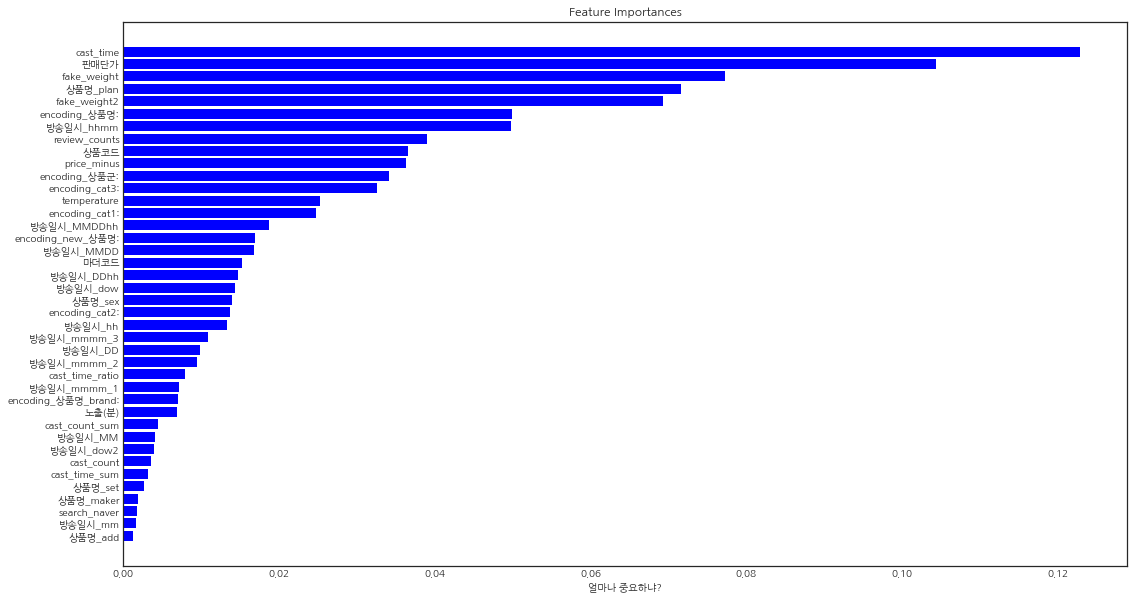

In [180]:
features = features
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('얼마나 중요하냐?')
plt.show()

#### 예측이 잘 되고 있는지 아닌지 row 하나씩 봐보겠습니다.

In [185]:
X_test = test_[['방송일시', '노출(분)','cast_time', '마더코드', '상품코드', '방송일시_hh', 'fake_weight', 'fake_weight2', '상품명', '상품군', 'cat2', 'cat3', '상품명_brand', '판매단가']]
X_test['target'] = test_['취급액']
X_test['pred'] = pred
X_test['error'] = X_test.target - X_test.pred
X_test['error_rate'] = (abs((X_test.target - X_test.pred) / X_test.target)) * 100

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [186]:
X_test.nlargest(30, 'error_rate')

,방송일시,노출(분),cast_time,마더코드,상품코드,방송일시_hh,fake_weight,fake_weight2,상품명,상품군,cat2,cat3,상품명_brand,판매단가,target,pred,error,error_rate
31894,2019-11-04 04:20:00,20.0,20.0,100623,201925,04,-4,0.0,콜라겐3.2 아임파인 (3개월),건강기능,다이어트식품,콜라겐,콜라,59900,986000,23100840.0,-22114840.0,2242.884381
14440,2019-05-17 22:40:00,13.0,53.0,100611,201893,22,-1,-1.0,푸마 여아 주니어 기능성 데일리 홈웨어세트,속옷,유아동언더웨어/잠옷,팬티,푸마,69000,282000,5882930.0,-5600930.0,1986.145390
20546,2019-07-15 21:20:00,20.0,40.0,100153,200558,21,-4,0.0,일시불 LG전자 휴대용 퓨리케어 미니 공청기,가전,계절가전,공기정화기,LG,309000,409000,7069740.0,-6660740.0,1628.542787
34193,2019-11-28 23:00:00,40.0,76.0,100623,201925,23,-4,0.0,콜라겐3.2 아임파인 (3개월),건강기능,다이어트식품,콜라겐,콜라,59900,3511000,40004840.0,-36493840.0,1039.414412
14444,2019-05-18 03:00:00,30.0,30.0,100374,201205,03,-1,0.0,USPA 여성 아동 반팔 폴로셔츠 3종,의류,남성의류,티셔츠,US,69000,268000,3039520.0,-2771520.0,1034.149254
25217,2019-08-29 17:00:00,30.0,30.0,100763,202218,17,-1,0.0,무이자 2019년 타이거 충전식 무선 예초기,생활용품,공구,예초기,타이,128000,528000,5931330.0,-5403330.0,1023.357955
36438,2019-12-20 22:40:00,17.0,37.0,100613,201874,22,-1,-1.0,푸마 드라이셀 쉐이핑 레깅스 3종,속옷,여성의류,레깅스,푸마,59000,607000,6386590.0,-5779590.0,952.156507
8511,2019-03-28 06:30:00,30.0,60.0,100240,200816,06,-4,0.0,키친아트 스마트뷰 스텐밀폐용기 9종,주방,주방용품,보관/밀폐용기,키친,89000,395000,4110570.0,-3715570.0,940.650633
23765,2019-08-14 19:20:00,20.0,40.0,100155,200556,19,-4,0.0,일시불 LG전자 매직스페이스 냉장고,가전,주방가전,냉장고,LG,1359000,3761000,36884460.0,-33123460.0,880.708854
31898,2019-11-04 05:00:00,20.0,60.0,100623,201925,05,-4,0.0,콜라겐3.2 아임파인 (3개월),건강기능,다이어트식품,콜라겐,콜라,59900,3265000,30028970.0,-26763970.0,819.723430


In [188]:
X_test[X_test.마더코드 == 100382]

,방송일시,노출(분),cast_time,마더코드,상품코드,방송일시_hh,fake_weight,fake_weight2,상품명,상품군,cat2,cat3,상품명_brand,판매단가,target,pred,error,error_rate
32075,2019-11-05 21:40:00,20.0,40.0,100382,201249,21,-1,0.0,뉴트리원 전지현 베리솔 콜라겐 구미(더블24주분+6일분),건강기능,다이어트식품,콜라겐,뉴트,238000,13332000,24626490.0,-11294490.0,84.717147
32073,2019-11-05 21:20:00,20.0,20.0,100382,201249,21,-1,0.0,뉴트리원 전지현 베리솔 콜라겐 구미(더블24주분+6일분),건강기능,다이어트식품,콜라겐,뉴트,238000,9244000,13611100.0,-4367100.0,47.242536


In [71]:
test[test.상품명.str.contains('푸마')]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
341,2020-06-04 22:20,20.0,100599,201882,푸마 순면 100% 언더셔츠 7종 데일리 패키지(2차),속옷,"79,000",NaN
342,2020-06-04 22:40,20.0,100599,201882,푸마 순면 100% 언더셔츠 7종 데일리 패키지(2차),속옷,"79,000",NaN
343,2020-06-04 23:00,20.0,100599,201882,푸마 순면 100% 언더셔츠 7종 데일리 패키지(2차),속옷,"79,000",NaN
519,2020-06-06 16:20,20.0,100599,201882,푸마 순면 100% 언더셔츠 7종 데일리 패키지(2차),속옷,"79,000",NaN
520,2020-06-06 16:40,20.0,100599,201882,푸마 순면 100% 언더셔츠 7종 데일리 패키지(2차),속옷,"79,000",NaN
521,2020-06-06 17:00,20.0,100599,201882,푸마 순면 100% 언더셔츠 7종 데일리 패키지(2차),속옷,"79,000",NaN
1597,2020-06-16 22:20,20.0,100599,201952,푸마 순면 100% 언더셔츠 7종 데일리 패키지(5차),속옷,"69,000",NaN
1598,2020-06-16 22:40,20.0,100599,201952,푸마 순면 100% 언더셔츠 7종 데일리 패키지(5차),속옷,"69,000",NaN
1599,2020-06-16 23:00,20.0,100599,201952,푸마 순면 100% 언더셔츠 7종 데일리 패키지(5차),속옷,"69,000",NaN
1766,2020-06-18 19:20,20.0,100607,201950,푸마 드라이셀 시그니처 캣 노와이어 브라 14종 패키지(14차),속옷,"129,000",NaN


In [75]:
train[train.마더코드 == 100204]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex,new_상품명,상품명_brand,fake_weight,fake_weight2,cat1,cat2,cat3,temperature,방송일시_dow,방송일시_MM,방송일시_DD,방송일시_hh,방송일시_mm,방송일시_MMDD,방송일시_DDhh,방송일시_hhmm,방송일시_MMDDhh,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,방송일시_dow2,review_counts,internet_price,price_minus,search_naver
27740,2019-09-22 20:00:00,30.0,100204,200715,(일)보루네오 델라 원목 베드룸 세트1(프레임+매트리스+화장대+협탁),가구,1349000,6640000,30.0,1,60.0,2.0,0.5,1,1,0,1,0,보루네오 델라 원목 베드룸 세트1,보루,-1,0.0,가구/인테리어,침실가구,침대,17.0,6,09,22,20,00,0922,2220,2000,092220,0,0,0,0,0,0,1349000,0
27741,2019-09-22 20:00:00,30.0,100204,200698,(무)보루네오 델라 원목 베드룸 세트1(프레임+매트리스+화장대+협탁),가구,1449000,10665000,30.0,1,60.0,2.0,0.5,2,1,0,1,0,보루네오 델라 원목 베드룸 세트1,보루,-1,0.0,가구/인테리어,침실가구,침대,17.0,6,09,22,20,00,0922,2220,2000,092220,0,0,0,0,0,0,1449000,0
27742,2019-09-22 20:00:00,30.0,100204,200716,(일)보루네오 델라 원목 베드룸 세트2(프레임+화장대+협탁),가구,1149000,2855000,30.0,1,60.0,2.0,0.5,1,1,0,1,0,보루네오 델라 원목 베드룸 세트2,보루,-4,0.0,가구/인테리어,침실가구,화장대,17.0,6,09,22,20,00,0922,2220,2000,092220,0,0,0,0,0,0,1149000,0
27744,2019-09-22 20:00:00,30.0,100204,200721,보루네오 델라 원목 베드룸 세트3(프레임+매트리스),가구,849000,4197000,30.0,1,60.0,2.0,0.5,0,1,0,1,0,보루네오 델라 원목 베드룸 세트3,보루,-4,0.0,가구/인테리어,침실가구,서랍장,17.0,6,09,22,20,00,0922,2220,2000,092220,0,0,0,0,0,0,849000,0
27745,2019-09-22 20:00:00,30.0,100204,200720,보루네오 델라 원목 거실장,가구,350000,1756000,30.0,1,60.0,2.0,0.5,0,0,0,0,0,보루네오 델라 원목 거실장,보루,-9,0.0,가구/인테리어,거실가구,TV거실장,17.0,6,09,22,20,00,0922,2220,2000,092220,0,0,0,0,0,279000,71000,1
27746,2019-09-22 20:30:00,30.0,100204,200715,(일)보루네오 델라 원목 베드룸 세트1(프레임+매트리스+화장대+협탁),가구,1349000,32998000,60.0,2,60.0,2.0,1.0,1,1,0,1,0,보루네오 델라 원목 베드룸 세트1,보루,-1,0.0,가구/인테리어,침실가구,침대,17.0,6,09,22,20,30,0922,2220,2030,092220,36000,792000,7128000,0,0,0,1349000,0
27747,2019-09-22 20:30:00,30.0,100204,200698,(무)보루네오 델라 원목 베드룸 세트1(프레임+매트리스+화장대+협탁),가구,1449000,14204000,60.0,2,60.0,2.0,1.0,2,1,0,1,0,보루네오 델라 원목 베드룸 세트1,보루,-1,0.0,가구/인테리어,침실가구,침대,17.0,6,09,22,20,30,0922,2220,2030,092220,36000,792000,7128000,0,0,0,1449000,0
27748,2019-09-22 20:30:00,30.0,100204,200716,(일)보루네오 델라 원목 베드룸 세트2(프레임+화장대+협탁),가구,1149000,5663000,60.0,2,60.0,2.0,1.0,1,1,0,1,0,보루네오 델라 원목 베드룸 세트2,보루,-4,0.0,가구/인테리어,침실가구,화장대,17.0,6,09,22,20,30,0922,2220,2030,092220,36000,792000,7128000,0,0,0,1149000,0
27749,2019-09-22 20:30:00,30.0,100204,200699,(무)보루네오 델라 원목 베드룸 세트2(프레임+화장대+협탁),가구,1249000,6149000,60.0,2,60.0,2.0,1.0,2,1,0,1,0,보루네오 델라 원목 베드룸 세트2,보루,-1,0.0,가구/인테리어,침실가구,화장대,17.0,6,09,22,20,30,0922,2220,2030,092220,36000,792000,7128000,0,0,0,1249000,0
27750,2019-09-22 20:30:00,30.0,100204,200721,보루네오 델라 원목 베드룸 세트3(프레임+매트리스),가구,849000,2125000,60.0,2,60.0,2.0,1.0,0,1,0,1,0,보루네오 델라 원목 베드룸 세트3,보루,-4,0.0,가구/인테리어,침실가구,서랍장,17.0,6,09,22,20,30,0922,2220,2030,092220,36000,792000,7128000,0,0,0,849000,0


#### 최적화 투 스테이지 모델 아이디에이션

1. 상품군: 11개
2. cat1: 9개
3. cat2: 87개
4. cat3: 249개

1년 동안 판매한 마더코드 약 700개.<br>
테스트 한 달 동안 판매한 마더코드 약 200개.<br>
트레인은 한 달 보통 100~200개 판매.

In [40]:
train[['상품명', '상품군', 'cat1', 'cat2', 'cat3']].sample(10)

,상품명,상품군,cat1,cat2,cat3
19367,시스마르스 보헤미안 소가죽 샌들+뮬 슬리퍼,잡화,패션잡화,여성신발,샌들
27839,무이자 얼리젼 밀레 푸쉬풀 도어락,생활용품,디지털/가전,생활가전,디지털도어록
18515,헤드 파이로라이트 트렁크 8종 패키지,속옷,패션의류,남성언더웨어/잠옷,팬티
21779,젠트웰 스트레치 통풍 메쉬 자켓 1종,의류,스포츠/레저,오토바이/스쿠터,오토바이의류/잡화
9697,무이자 삼성 UHD TV UN55NU7050F,가전,디지털/가전,영상가전,TV
29754,코치 플라이트백,잡화,패션잡화,남성가방,크로스백
20545,무이자 LG전자 휴대용 퓨리케어 미니 공청기,가전,디지털/가전,계절가전,공기정화기
8698,제옥스 여성 어글리스니커즈,잡화,패션잡화,여성신발,단화
6795,푸마 드라이셀 치마레깅스 3종,속옷,패션의류,여성의류,레깅스
15903,무이자 LG 휘센 씽큐 에어컨 2IN1형 FQ17V9KWA2,가전,디지털/가전,계절가전,에어컨


투 스테이지 모델의 핵심은 다음과 같습니다.
1. 모든 경우의 수를 돌리는 모델은 너무 무겁고 느리다. 물론 가장 정확할 것이다. 다만 한정된 리소스에서 최적의 결과를 내야하는 목적은 달성하지 못한다. 마치 전수조사 같은 것이다.
2. 그럼 표본을 뽑아서 모집단을 예측할 것이다.

그럼 투 스테이지 모델을 어떻게 구성할 것인가?

1. 시간별로 많이 팔린 카테고리 후보를 뽑아주는 candidate 모델 -> 유저별 87개의 cat2 에서 상위 5개를 추출
2. candidate 모델에서 추출된 후보 카테고리와 일치하는 세부 상품의 예상 매출을 뽑아주는 rank 모델 -> 유저별 상위 10개씩 추출

투 스테이지 모델을 통해서 나온 rank-driven 결과에 따라 편성을 어떻게 할 것인가?

1. unique한 상품은 그대로 고정이 될 것이다.
2. ununique한 상품들의 unique값만 모아서 매출액을 비교. 가장 높은 매출부터 rank화.
3. rank화 된 ununique한 상품은 동일한 상품을 groupby해서 가장 높은 매출이 예상되는 시간에 고정.
4. 모든 값이 고정될 때까지 반복하여 편성표 확정.

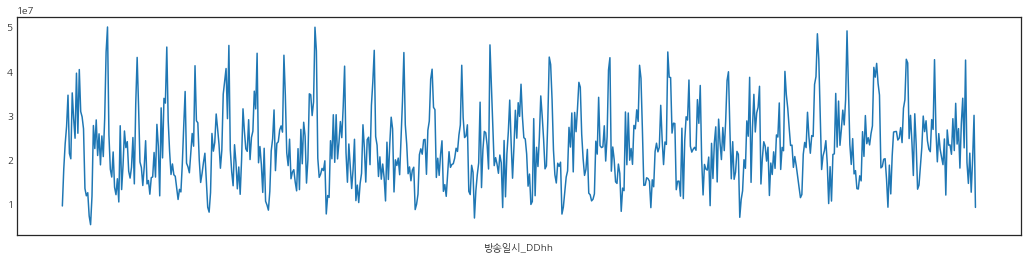

In [49]:
train.groupby('방송일시_DDhh')['취급액'].mean().plot(kind='line', figsize=(18,4))
plt.show()

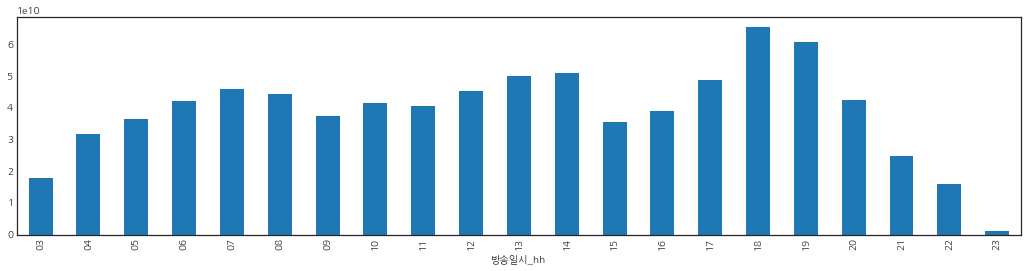

In [76]:
train.groupby('방송일시_hh')['취급액'].sum().plot(kind='bar', figsize=(18,4))
plt.show()

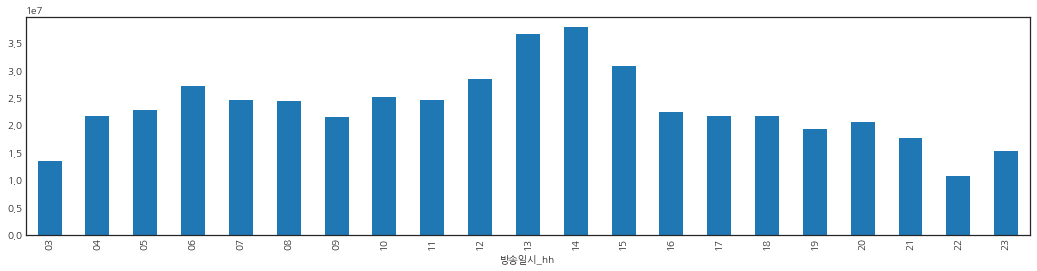

In [77]:
train.groupby('방송일시_hh')['취급액'].mean().plot(kind='bar', figsize=(18,4))
plt.show()

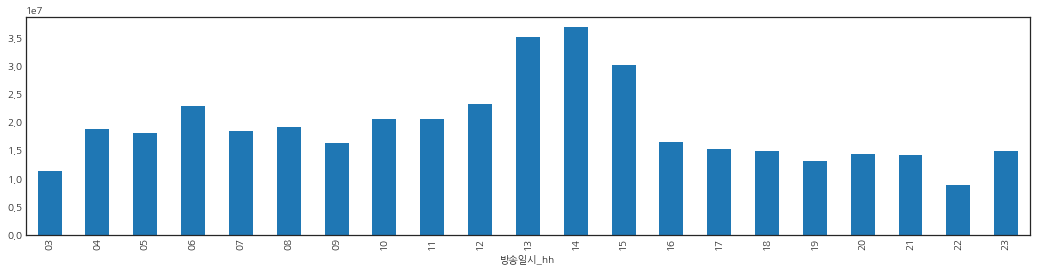

In [81]:
train.groupby('방송일시_hh')['취급액'].median().plot(kind='bar', figsize=(18,4))
plt.show()

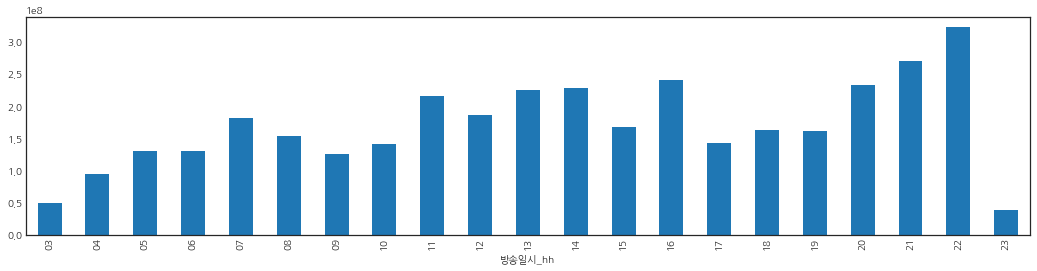

In [79]:
train.groupby('방송일시_hh')['취급액'].max().plot(kind='bar', figsize=(18,4))
plt.show()

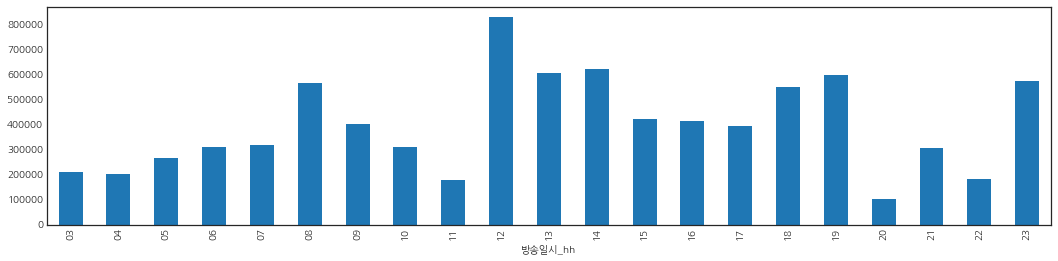

In [80]:
train.groupby('방송일시_hh')['취급액'].min().plot(kind='bar', figsize=(18,4))
plt.show()

In [52]:
train.groupby('방송일시_DDhh').sum()

,노출(분),마더코드,상품코드,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,fake_weight,ratings_mean,방송일시_dow,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3
방송일시_DDhh,,,,,,,,,,,,,,,,
0103,1100.0,5524612,11075376,19092800.0,5.340020e+08,2160.0,108,3300.0,165.0,36.000000,-73,0.118274,149,205200.0,205200.0,1209600.0
0104,1000.0,5018653,10057462,11733800.0,9.037980e+08,1920.0,96,3000.0,150.0,32.000000,-62,0.114858,176,259200.0,259200.0,2001600.0
0105,960.0,4821535,9666683,6806500.0,1.141461e+09,1980.0,99,2880.0,144.0,33.000000,-60,0.167339,139,270000.0,270000.0,1908000.0
0106,1220.0,5226283,10485452,24685900.0,1.440065e+09,2190.0,96,3120.0,138.0,36.500000,-116,0.190315,136,334800.0,334800.0,2332800.0
0107,1200.0,5323458,10675718,25145700.0,1.841607e+09,2190.0,99,3180.0,145.0,36.500000,-120,0.271195,156,415800.0,415800.0,2721600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,1360.0,6225025,12476926,83195700.0,1.342086e+09,2700.0,126,3720.0,174.0,45.000000,-121,0.264136,223,1274400.0,39506400.0,188827200.0
3119,1580.0,7923259,15872518,129510900.0,1.012984e+09,3000.0,150,4740.0,237.0,50.000000,-127,0.295990,283,1983600.0,61491600.0,351986400.0
3120,720.0,3610727,7234258,27467600.0,7.309530e+08,1500.0,75,2160.0,108.0,25.000000,-94,0.160070,139,792000.0,24552000.0,216504000.0


In [78]:
train.groupby('방송일시_MMDDhh').sum()

,노출(분),마더코드,상품코드,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,fake_weight,fake_weight2,temperature,방송일시_dow,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,review_counts,internet_price,price_minus,search_naver
방송일시_MMDDhh,,,,,,,,,,,,,,,,,,,,,
010103,120.0,602076,1206453,239400,32696000,240.0,12,360.0,18.0,4.0,-6,0.0,-48.0,6,21600,21600,21600,6,322860,-83460,6
010104,60.0,300915,602922,177000,47878000,120.0,6,180.0,9.0,2.0,-3,0.0,-24.3,3,14400,14400,14400,0,0,177000,0
010105,60.0,302424,607131,179700,99736000,120.0,6,180.0,9.0,2.0,-3,0.0,-23.4,3,18000,18000,18000,0,170730,8970,3
010106,60.0,302448,607212,237000,90973000,120.0,6,180.0,9.0,2.0,-3,0.0,-15.6,3,21600,21600,21600,0,0,237000,0
010107,60.0,302427,607185,239700,259678000,120.0,6,180.0,9.0,2.0,-3,0.0,-4.2,3,25200,25200,25200,255,172800,66900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123117,220.0,1105790,2217595,4615000,143410000,420.0,21,660.0,33.0,7.0,-46,0.0,-45.1,11,244800,7588800,91065600,6,3164430,1450570,11
123118,160.0,802624,1608156,7050000,219941000,360.0,18,480.0,24.0,6.0,-37,0.0,-35.2,8,129600,4017600,48211200,2248,6850840,199160,8
123119,40.0,200310,401045,2858000,104917000,120.0,6,120.0,6.0,2.0,-5,0.0,-9.2,2,0,0,0,1124,2987420,-129420,2


# MF

In [366]:
train_mf = train[['방송일시','cat2','취급액']]
train_mf.head()

,방송일시,cat2,취급액
0,2019-01-01 03:00:00,남성의류,2099000
1,2019-01-01 03:00:00,여성의류,4371000
2,2019-01-01 03:20:00,남성의류,3262000
3,2019-01-01 03:20:00,여성의류,6955000
4,2019-01-01 03:40:00,남성의류,6672000


In [367]:
train_mf['방송일시'] = train_mf['방송일시'].apply(lambda x: x[11:16])
train_mf.head()

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,방송일시,cat2,취급액
0,03:00,남성의류,2099000
1,03:00,여성의류,4371000
2,03:20,남성의류,3262000
3,03:20,여성의류,6955000
4,03:40,남성의류,6672000


In [368]:
ori_time = train_mf['방송일시'].unique()

In [369]:
train_mf = train_mf.groupby(['방송일시','cat2']).sum()[['취급액']].reset_index()

In [370]:
le_c = LabelEncoder()
le_c.fit(train_mf['cat2'])

le_t = LabelEncoder()
le_t.fit(train_mf['방송일시'])

LabelEncoder()

In [371]:
train_mf['cat'] = le_c.transform(train_mf['cat2'])
#data['origin_cat'] = le_c.inverse_transform(data['cat'])
del train_mf['cat2']

train_mf['time'] = le_t.transform(train_mf['방송일시'])
#data['origin_time'] = le_t.inverse_transform(data['time'])
del train_mf['방송일시']
train_mf.head()

,취급액,cat,time
0,4166000.0,0,0
1,20019000.0,1,0
2,8743000.0,3,0
3,275807000.0,4,0
4,9084000.0,6,0


In [372]:
train_mf = train_mf.pivot(index = 'time', columns = 'cat', values = '취급액')
train_mf.head()

cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4166000.0,20019000.0,NaN,8743000.0,275807000.0,NaN,9084000.0,121862000.0,NaN,NaN,NaN,7587000.0,NaN,NaN,13174000.0,74853000.0,87944000.0,NaN,NaN,NaN,NaN,NaN,8272000.0,8186000.0,91098000.0,NaN,26712000.0,NaN,NaN,NaN,NaN,8481000.0,12065000.0,NaN,72164000.0,39892000.0,NaN,NaN,37876000.0,8721000.0,137450000.0,31684000.0,NaN,NaN,NaN,40772000.0,NaN,29428000.0,53970000.0,98034000.0,4.773540e+08,5.459470e+08,NaN,NaN,NaN,NaN,6126000.0,NaN,NaN,NaN,NaN,NaN,60073000.0,NaN,NaN,NaN,NaN,NaN,20323000.0,NaN,97517000.0,325934000.0,NaN,NaN,NaN,NaN,NaN,5280000.0,30008000.0,8070000.0,5885000.0,NaN,NaN,NaN,45135000.0,19099000.0,NaN
1,NaN,7655000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22032000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.874800e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26456000.0,32700000.0,NaN,16654000.0,473248000.0,16779000.0,24530000.0,208905000.0,NaN,NaN,NaN,8283000.0,NaN,NaN,24859000.0,168108000.0,173354000.0,NaN,NaN,NaN,NaN,NaN,11624000.0,17139000.0,194352000.0,NaN,48337000.0,NaN,NaN,NaN,NaN,8787000.0,18785000.0,11235000.0,117316000.0,105848000.0,40565000.0,NaN,74417000.0,13645000.0,235828000.0,51202000.0,NaN,NaN,NaN,99865000.0,NaN,115819000.0,82827000.0,174684000.0,6.950340e+08,1.203762e+09,NaN,NaN,NaN,NaN,58765000.0,NaN,NaN,NaN,NaN,NaN,73199000.0,NaN,NaN,NaN,NaN,NaN,46498000.0,NaN,161878000.0,485364000.0,NaN,NaN,NaN,NaN,NaN,9227000.0,53667000.0,16933000.0,14269000.0,NaN,8957000.0,NaN,73771000.0,98571000.0,NaN
3,NaN,16667000.0,NaN,NaN,72912000.0,NaN,NaN,48964000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22109000.0,8551000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10283000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41768000.0,NaN,2.051070e+08,6.163400e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16161000.0,115424000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22959000.0,NaN,NaN
4,64067000.0,50264000.0,NaN,42774000.0,755727000.0,35295000.0,44807000.0,365281000.0,NaN,NaN,NaN,13113000.0,NaN,NaN,33787000.0,202749000.0,262039000.0,NaN,NaN,NaN,NaN,NaN,10220000.0,25573000.0,290655000.0,NaN,63991000.0,NaN,NaN,NaN,NaN,16007000.0,25768000.0,18725000.0,161789000.0,186857000.0,48551000.0,NaN,102847000.0,23733000.0,360284000.0,86087000.0,NaN,NaN,NaN,130642000.0,NaN,141831000.0,80206000.0,265244000.0,1.028030e+09,1.715208e+09,NaN,NaN,NaN,NaN,46313000.0,NaN,NaN,NaN,NaN,NaN,78140000.0,NaN,NaN,NaN,NaN,NaN,75431000.0,NaN,228603000.0,772455000.0,NaN,NaN,NaN,NaN,NaN,26092000.0,77203000.0,18301000.0,16429000.0,NaN,14247000.0,NaN,112887000.0,154646000.0,NaN


In [373]:
train_mf.fillna(0, inplace=True)
train_mf.head()

cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4166000.0,20019000.0,0.0,8743000.0,275807000.0,0.0,9084000.0,121862000.0,0.0,0.0,0.0,7587000.0,0.0,0.0,13174000.0,74853000.0,87944000.0,0.0,0.0,0.0,0.0,0.0,8272000.0,8186000.0,91098000.0,0.0,26712000.0,0.0,0.0,0.0,0.0,8481000.0,12065000.0,0.0,72164000.0,39892000.0,0.0,0.0,37876000.0,8721000.0,137450000.0,31684000.0,0.0,0.0,0.0,40772000.0,0.0,29428000.0,53970000.0,98034000.0,4.773540e+08,5.459470e+08,0.0,0.0,0.0,0.0,6126000.0,0.0,0.0,0.0,0.0,0.0,60073000.0,0.0,0.0,0.0,0.0,0.0,20323000.0,0.0,97517000.0,325934000.0,0.0,0.0,0.0,0.0,0.0,5280000.0,30008000.0,8070000.0,5885000.0,0.0,0.0,0.0,45135000.0,19099000.0,0.0
1,0.0,7655000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22032000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.874800e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26456000.0,32700000.0,0.0,16654000.0,473248000.0,16779000.0,24530000.0,208905000.0,0.0,0.0,0.0,8283000.0,0.0,0.0,24859000.0,168108000.0,173354000.0,0.0,0.0,0.0,0.0,0.0,11624000.0,17139000.0,194352000.0,0.0,48337000.0,0.0,0.0,0.0,0.0,8787000.0,18785000.0,11235000.0,117316000.0,105848000.0,40565000.0,0.0,74417000.0,13645000.0,235828000.0,51202000.0,0.0,0.0,0.0,99865000.0,0.0,115819000.0,82827000.0,174684000.0,6.950340e+08,1.203762e+09,0.0,0.0,0.0,0.0,58765000.0,0.0,0.0,0.0,0.0,0.0,73199000.0,0.0,0.0,0.0,0.0,0.0,46498000.0,0.0,161878000.0,485364000.0,0.0,0.0,0.0,0.0,0.0,9227000.0,53667000.0,16933000.0,14269000.0,0.0,8957000.0,0.0,73771000.0,98571000.0,0.0
3,0.0,16667000.0,0.0,0.0,72912000.0,0.0,0.0,48964000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22109000.0,8551000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10283000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41768000.0,0.0,2.051070e+08,6.163400e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16161000.0,115424000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22959000.0,0.0,0.0
4,64067000.0,50264000.0,0.0,42774000.0,755727000.0,35295000.0,44807000.0,365281000.0,0.0,0.0,0.0,13113000.0,0.0,0.0,33787000.0,202749000.0,262039000.0,0.0,0.0,0.0,0.0,0.0,10220000.0,25573000.0,290655000.0,0.0,63991000.0,0.0,0.0,0.0,0.0,16007000.0,25768000.0,18725000.0,161789000.0,186857000.0,48551000.0,0.0,102847000.0,23733000.0,360284000.0,86087000.0,0.0,0.0,0.0,130642000.0,0.0,141831000.0,80206000.0,265244000.0,1.028030e+09,1.715208e+09,0.0,0.0,0.0,0.0,46313000.0,0.0,0.0,0.0,0.0,0.0,78140000.0,0.0,0.0,0.0,0.0,0.0,75431000.0,0.0,228603000.0,772455000.0,0.0,0.0,0.0,0.0,0.0,26092000.0,77203000.0,18301000.0,16429000.0,0.0,14247000.0,0.0,112887000.0,154646000.0,0.0


In [374]:
matrix = train_mf.values
time_mean = np.mean(matrix, axis=1)
matrix_time_mean = matrix - time_mean.reshape(-1,1)

In [375]:
matrix

array([[ 4166000., 20019000.,        0., ..., 45135000., 19099000.,
               0.],
       [       0.,  7655000.,        0., ...,        0.,        0.,
               0.],
       [26456000., 32700000.,        0., ..., 73771000., 98571000.,
               0.],
       ...,
       [       0.,        0.,        0., ...,        0.,        0.,
               0.],
       [       0.,        0.,        0., ...,        0.,        0.,
        18956000.],
       [       0.,        0.,        0., ...,        0.,        0.,
               0.]])

In [377]:
pd.DataFrame(matrix_time_mean, columns = train_mf.columns).head()

cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
0,-3.002705e+07,-1.417405e+07,-3.419305e+07,-2.545005e+07,2.416140e+08,-3.419305e+07,-2.510905e+07,8.766895e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-2.660605e+07,-3.419305e+07,-3.419305e+07,-2.101905e+07,4.065995e+07,5.375095e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-2.592105e+07,-2.600705e+07,5.690495e+07,-3.419305e+07,-7.481046e+06,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-2.571205e+07,-2.212805e+07,-3.419305e+07,3.797095e+07,5.698954e+06,-3.419305e+07,-3.419305e+07,3.682954e+06,-2.547205e+07,1.032570e+08,-2.509046e+06,-3.419305e+07,-3.419305e+07,-3.419305e+07,6.578954e+06,-3.419305e+07,-4.765046e+06,1.977695e+07,6.384095e+07,4.431610e+08,5.117540e+08,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-2.806705e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,2.587995e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-1.387005e+07,-3.419305e+07,6.332395e+07,2.917410e+08,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,-2.891305e+07,-4.185046e+06,-2.612305e+07,-2.830805e+07,-3.419305e+07,-3.419305e+07,-3.419305e+07,1.094195e+07,-1.509405e+07,-3.419305e+07
1,-7.866092e+05,6.868391e+06,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,2.124539e+07,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,3.796139e+07,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05,-7.866092e+05
2,-3.786637e+07,-3.162237e+07,-6.432237e+07,-4.766837e+07,4.089256e+08,-4.754337e+07,-3.979237e+07,1.445826e+08,-6.432237e+07,-6.432237e+07,-6.432237e+07,-5.603937e+07,-6.432237e+07,-6.432237e+07,-3.946337e+07,1.037856e+08,1.090316e+08,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-5.269837e+07,-4.718337e+07,1.300296e+08,-6.432237e+07,-1.598537e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-5.553537e+07,-4.553737e+07,-5.308737e+07,5.299363e+07,4.152563e+07,-2.375737e+07,-6.432237e+07,1.009463e+07,-5.067737e+07,1.715056e+08,-1.312037e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,3.554263e+07,-6.432237e+07,5.149663e+07,1.850463e+07,1.103616e+08,6.307116e+08,1.139440e+09,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-5.557368e+06,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,8.876632e+06,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-1.782437e+07,-6.432237e+07,9.755563e+07,4.210416e+08,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-6.432237e+07,-5.509537e+07,-1.065537e+07,-4.738937e+07,-5.005337e+07,-6.432237e+07,-5.536537e+07,-6.432237e+07,9.448632e+06,3.424863e+07,-6.432237e+07
3,-7.385506e+06,9.281494e+06,-7.385506e+06,-7.385506e+06,6.552649e+07,-7.385506e+06,-7.385506e+06,4.157849e+07,-7.385506e+06,-

In [379]:
# TruncatedSVD
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(matrix_time_mean, k = 8)
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(149, 8)
(8,)
(8, 87)


In [380]:
sigma = np.diag(sigma)
sigma

array([[2.93945911e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.28849679e+09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.21520251e+09, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.76027402e+09,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.30831528e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.22535671e+10, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.68682723e+10, 0.

In [381]:
svd_matrix = np.dot(np.dot(U, sigma), Vt) + time_mean.reshape(-1,1)

In [383]:
df_svd = pd.DataFrame(svd_matrix, columns = train_mf.columns)
df_svd

cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
0,8.797878e+06,2.129950e+07,1.092014e+07,9.110695e+06,2.647895e+08,2.415461e+06,1.711941e+07,8.914649e+07,6.643690e+06,6.075806e+06,5.778635e+06,9.208307e+05,-2.354144e+07,1.700050e+06,4.314115e+07,5.025400e+07,1.755384e+08,4.239142e+07,-5.692762e+07,9.409136e+06,8.211409e+06,1.147668e+06,6.116482e+05,8.385528e+06,9.058917e+07,1.269222e+06,3.289446e+07,5.412427e+05,2.560231e+07,6.259008e+06,2.176188e+06,-2.971975e+05,2.869074e+07,8.874837e+06,2.998918e+07,3.778749e+06,2.406671e+07,5.045592e+05,3.710024e+07,7.117337e+06,5.591562e+07,8.958321e+06,3.016991e+07,7.417283e+06,4.318151e+05,1.053725e+08,2.099075e+07,1.766825e+07,1.396394e+08,9.612977e+07,4.432260e+08,5.515296e+08,2.740267e+06,1.055219e+07,-2.568249e+05,7.586770e+05,-1.507466e+07,2.166034e+06,5.156038e+05,3.904173e+05,4.482521e+06,2.979990e+06,8.536171e+06,2.089857e+05,2.964702e+06,2.852883e+06,3.103328e+06,9.703309e+05,7.367609e+06,4.001263e+05,9.908328e+07,2.335357e+08,3.628798e+07,3.699327e+05,1.026143e+06,-2.102057e+07,2.581612e+06,2.344337e+07,2.479892e+07,6.170693e+06,1.016021e+07,6.004343e+05,1.406703e+06,7.359976e+06,4.874325e+06,2.586333e+07,2.649310e+06
1,-3.700372e+05,-1.265934e+06,-7.677948e+04,-4.990252e+05,9.425536e+06,-5.758664e+05,4.754673e+05,3.216324e+06,-7.940688e+05,-5.400465e+05,-4.034503e+05,-6.304648e+05,-7.735203e+04,-6.036289e+05,3.596662e+05,1.687537e+07,1.085073e+07,3.170945e+06,1.856634e+06,-7.856988e+05,2.633031e+05,-6.227406e+05,-4.907116e+05,-2.397194e+05,3.684426e+06,-6.124169e+05,8.113068e+05,-7.140697e+05,1.934597e+05,-5.045389e+05,-5.811488e+05,-5.632724e+05,3.815445e+04,-3.164485e+05,4.237747e+05,-3.289550e+06,4.818948e+04,-6.395722e+05,3.064603e+05,-7.485854e+05,6.178426e+05,-4.047136e+05,-7.364672e+05,-3.765248e+04,-6.744255e+05,2.335293e+06,7.363178e+04,2.062417e+05,5.360216e+06,8.665478e+05,4.422005e+06,2.172653e+07,4.240519e+05,2.288721e+06,1.942844e+05,-6.358412e+05,4.962467e+06,-5.763476e+05,-5.040182e+05,-6.475046e+05,-6.333929e+05,-6.393387e+05,-3.356396e+05,-6.715032e+05,-6.029459e+05,-5.568726e+05,-5.392126e+05,-6.150053e+05,-4.407239e+05,-6.499143e+05,-1.016209e+06,8.743514e+06,-1.769743e+06,-6.511909e+05,-6.674393e+05,5.904992e+05,-6.698991e+05,-2.287698e+06,-9.886196e+05,-4.926665e+05,1.088931e+06,-6.405367e+05,-6.320904e+05,-6.064252e+05,-4.980448e+05,-1.440661e+05,-5.542549e+05
2,1.757934e+07,2.292220e+07,1.542847e+07,1.666159e+07,5.303514e+08,4.933283e+06,3.247396e+07,1.818859e+08,8.012086e+06,1.174032e+07,1.174976e+07,2.054197e+06,-3.751261e+07,3.630101e+06,8.259679e+07,1.393601e+08,3.568902e+08,1.004562e+08,-9.383773e+07,1.273817e+07,1.477244e+07,2.024730e+06,4.677199e+06,1.619724e+07,1.756777e+08,2.253643e+06,6.850708e+07,1.078543e+06,3.239466e+07,9.217272e+06,3.300511e+06,3.257624e+05,4.921183e+07,1.706960e+07,5.177137e+07,3.804886e+07,4.793383e+07,1.315903e+06,6.061083e+07,1.321361e+07,1.068706e+08,1.748508e+07,3.764049e+07,1.516199e+07,7.740241e+05,2.125068e+08,2.980445e+07,3.758771e+07,2.672741e+08,1.768000e+08,6.807796e+08,1.068733e+09,6.776471e+06,3.921355e+07,1.816074e+06,1.523883e+06,-1.417197e+06,3.335615e+06,1.793546e+06,1.020549e+06,7.999993e+06,4.393789e+06,1.691517e+07,4.202961e+05,4.862765e+06,4.344416e+06,4.814657e+06,2.233002e+06,1.428351e+07,1.020584e+06,1.434413e+08,4.657264e+08,3.609468e+07,9.155411e+05,1.987643e+06,-3.069335e+07,4.407421e+06,2.440610e+07,4.540618e+07,1.013951e+07,2.057236e+07,1.335231e+06,2.822996e+06,1.369849e+07,9.710659e+06,4.547859e+07,4.111291e+06
3,2.045331e+05,9.667245e+06,6.168216e+06,5.272478e+05,3.288824e+07,-8.618723e+05,5.892646e+06,1.486799e+07,2.594627e+06,-3.465535e+05,-2.534060e+05,-1.116793e+06,-5.619260e+06,-8.875708e+05,6.282884e+06,8.795761e+06,3.488380e+07,1.047103e+06,-9.934408e+06,3.391963e+06,3.049599e+0

In [384]:
candi = pd.DataFrame()
candi['time'] = df_svd.index

In [385]:
first = []
second = []
third = []

for i in df_svd.index:
    first.append(df_svd.loc[i].sort_values(ascending = False).index[0])
    second.append(df_svd.loc[i].sort_values(ascending = False).index[1])
    third.append(df_svd.loc[i].sort_values(ascending = False).index[2])

In [386]:
candi['first'] = first
candi['second'] = second
candi['third'] = third
candi.head()

,time,first,second,third
0,0,51,50,4
1,1,51,15,16
2,2,51,50,4
3,3,50,51,71
4,4,51,50,4


In [387]:
candi['time'] = le_t.inverse_transform(candi['time'])
candi['first'] = le_c.inverse_transform(candi['first'])
candi['second'] = le_c.inverse_transform(candi['second'])
candi['third'] = le_c.inverse_transform(candi['third'])

In [394]:
candi

,time,first,second,third
0,03:00,여성의류,여성언더웨어/잠옷,건강식품
1,03:10,여성의류,남성언더웨어/잠옷,남성의류
2,03:20,여성의류,여성언더웨어/잠옷,건강식품
3,03:30,여성언더웨어/잠옷,여성의류,주방용품
4,03:40,여성의류,여성언더웨어/잠옷,건강식품
...,...,...,...,...
144,22:30,여성언더웨어/잠옷,주방가전,남성언더웨어/잠옷
145,22:40,여성언더웨어/잠옷,여성의류,수산
146,22:50,남성언더웨어/잠옷,욕실용품,남성의류
147,23:00,여성의류,여성언더웨어/잠옷,수산


In [389]:
set(candi['first'].unique().tolist() + candi['second'].unique().tolist() + candi['third'].unique().tolist())

{'가공식품',
 '건강식품',
 '남성언더웨어/잠옷',
 '남성의류',
 '남성화장품',
 '냉동/간편조리식품',
 '농산물',
 '생활가전',
 '수산',
 '스킨케어',
 '여성가방',
 '여성언더웨어/잠옷',
 '여성의류',
 '영상가전',
 '욕실용품',
 '주방가전',
 '주방용품',
 '주얼리',
 '침구세트',
 '침실가구'}

In [390]:
len(set(candi['first'].unique().tolist() + candi['second'].unique().tolist() + candi['third'].unique().tolist()))

20

# 창고(과거 코드는 순서대로 여기에 쌓습니다.)

## 시청률 데이터 넣어줍시다

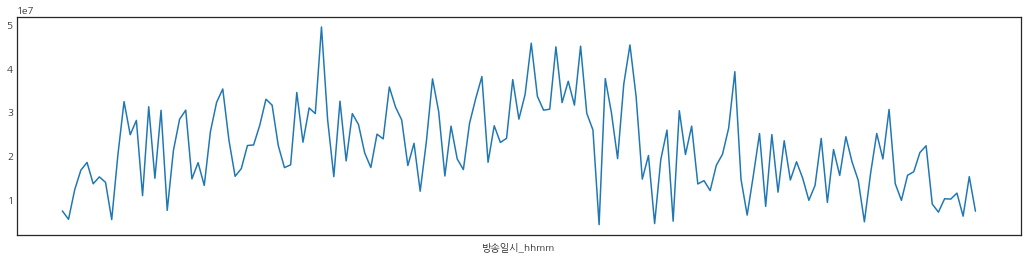

In [446]:
train.groupby('방송일시_hhmm')['취급액'].mean().plot(kind='line', figsize=(18,4))
plt.show()

In [447]:
train.groupby('방송일시_hhmm')['취급액'].mean().nsmallest(10)

방송일시_hhmm
1510    4.479500e+06
1615    4.724750e+06
2010    5.135000e+06
1635    5.282250e+06
0415    5.634750e+06
0310    5.702917e+06
2250    6.414545e+06
1815    6.661875e+06
2210    7.333167e+06
2310    7.550500e+06
Name: 취급액, dtype: float64

중요하다고 보여주는 hhmm 별 평균 시청률을 넣어주겠습니다.

In [378]:
ratings_melt.ratings_key = ratings_melt.ratings_key.astype(str)

In [266]:
ratings_melt['방송일시_hhmm'] = ratings_melt.ratings_key.apply(lambda x: x[11:13]) + ratings_melt.ratings_key.apply(lambda x: x[14:16])

In [270]:
ratings_hhmm = ratings_melt.groupby('방송일시_hhmm').mean().reset_index()

In [273]:
train = pd.merge(train, ratings_hhmm[['방송일시_hhmm', 'value']], on=['방송일시_hhmm'], how='left')

hh별 평균 시청률은 어떨까요

In [292]:
ratings_melt['방송일시_hh'] = ratings_melt.ratings_key.apply(lambda x: x[11:13])

In [294]:
ratings_hh = ratings_melt.groupby('방송일시_hh').mean().reset_index()

In [296]:
train = pd.merge(train, ratings_hh[['방송일시_hh', 'value']], on=['방송일시_hh'], how='left')

In [316]:
ratings_melt

,시간대,variable,value,ratings_key,change_label,방송일시_hhmm,방송일시_hh
0,02:00,2019-01-01,0.0,2018-12-31 23:00:00,1,2300,23
1,02:01,2019-01-01,0.0,2018-12-31 23:01:00,1,2301,23
2,02:02,2019-01-01,0.0,2018-12-31 23:02:00,1,2302,23
3,02:03,2019-01-01,0.0,2018-12-31 23:03:00,1,2303,23
4,02:04,2019-01-01,0.0,2018-12-31 23:04:00,1,2304,23
...,...,...,...,...,...,...,...
525959,01:55,2019-12-31,0.0,2019-12-30 22:55:00,1,2255,22
525960,01:56,2019-12-31,0.0,2019-12-30 22:56:00,1,2256,22
525961,01:57,2019-12-31,0.0,2019-12-30 22:57:00,1,2257,22
525962,01:58,2019-12-31,0.0,2019-12-30 22:58:00,1,2258,22


DD 별로 넣어봅시다.

In [379]:
ratings_melt['방송일시_DD'] = ratings_melt.ratings_key.apply(lambda x: x[8:10])

In [380]:
ratings_DD = ratings_melt.groupby('방송일시_DD').mean().reset_index()

In [381]:
train = pd.merge(train, ratings_DD[['방송일시_DD', 'value']], on=['방송일시_DD'], how='left')

### 2.8.3. 시청률 변수 추가

여러 시도 결과, 방송의 시작 순간 시청률을 넣어줍니다.

In [98]:
ratings = pd.read_csv(r'./tv_new.csv')

In [99]:
def outside_feature_ratings(ratings):
    # 시청률 데이터를 합치기 좋게 전처리 하는 코드입니다.
    # 합치기 좋게 행렬 축을 바꿔줍니다.
    ratings_melt = pd.melt(ratings, id_vars=['시간대'])

    # 평균 시청률이 있습니다. 없애줍니다.
    ratings_melt.drop(ratings_melt[ratings_melt['variable'].str.contains('to')].index, axis=0, inplace=True)
    ratings_melt.drop(ratings_melt[ratings_melt['시간대'].str.contains('월')].index, axis=0, inplace=True)

    # 시청률 df는 편하게 change_label 을 그냥 1로 때려박습니다.
    ratings_melt['change_label'] = 1
    
    # train, test 와 합쳐주기 위해 key 칼럼을 만들어줍니다.
    ratings_melt['ratings_key'] = pd.to_datetime((ratings_melt.variable + " " + ratings_melt.시간대))
    
    # train이 3시간 당겨져 있으니, ratings도 3시간 당겨줍니다.
    delta = datetime.timedelta(hours=3)
    ratings_melt['ratings_key'] = ratings_melt.ratings_key.apply(lambda x: x - delta)
    
    return ratings_melt

In [100]:
ratings_melt = outside_feature_ratings(ratings)

In [101]:
def outside_feature_ratings2(train):
    # 해당 방송의 시작을 알려주는 작업입니다. 마더코드의 변화에 따라 값을 줍니다.
    change = 0
    change_label = []

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            change = 1 # 방송 시작이니 1을 줍니다.
            change_label.append(change) # 그리고 어펜드.

        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            change = 0 # 기존 방송이니 0을 줍니다.
            change_label.append(change) # 그리고 어펜드.

        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            change = 1 # 방송 시작이니 1을 줍니다.
            change_label.append(change) # 그리고 어펜드.

    train['change_label'] = change_label
    
    # train의 방송일시를 datetime 으로 바꿔서 키 값으로 줍니다.
    train['ratings_key'] = pd.to_datetime(train.방송일시)
    
    return train

In [102]:
train = outside_feature_ratings2(train)

In [103]:
def outside_feature_ratings3(train, ratings_melt):
    # 시청률 데이터와 기존 데이터를 합쳐주기 위한 코드입니다.
    train = pd.merge(train, ratings_melt[['ratings_key','change_label', 'value']], on=['change_label','ratings_key'], how='left')
    
    # 방송 시작 시청률만 넣어주기 때문에 nan값이 생깁니다. 전부 ffill로 채워주면 점수가 떨어지고 0을 넣어주면 올라갑니다... 
    train.value = train.value.fillna(method='ffill')
    
    # 키값은 드랍
    train.drop('ratings_key', axis=1, inplace=True)
    # 칼럼명은 변경
    train.rename(columns = {'value':'ratings_start'}, inplace=True)
    
    return train

In [104]:
train = outside_feature_ratings3(train, ratings_melt)

In [105]:
train = train.drop('change_label', axis=1)

#### 시간대별로 따로 분석을 해서 합치면 어떻게 될까

In [37]:
train.방송일시_mm.value_counts()

00    12432
20    11613
40    11354
30     1293
50      385
10      135
45       54
15       54
35       26
05       26
Name: 방송일시_mm, dtype: int64

In [87]:
train.방송일시_mm = train.방송일시_mm.astype(np.int32)

In [119]:
train.shape

(35379, 43)

In [120]:
train_zero = train[train.방송일시_mm == 0]

In [121]:
train_back = train[train.방송일시_mm > 30]

In [122]:
train_forw = train[train.방송일시_mm <= 30]
train_forw = train_forw[train_forw.방송일시_mm != 0]

In [124]:
train_zero.shape, train_forw.shape, train_back.shape

((11454, 43), (12457, 43), (11468, 43))

In [125]:
# 예측 값 추정이 불가능한 취급액 0원인 애들 제거해줍니다.

train_zero = train_zero[train_zero.취급액 != 0]
train_forw = train_forw[train_forw.취급액 != 0]
train_back = train_back[train_back.취급액 != 0]

In [126]:
train_zero.shape, train_forw.shape, train_back.shape

((11454, 43), (12457, 43), (11468, 43))

In [129]:
# 6월 데이터로 학습을 해서 val score 를 뽑아봅니다.
train_0 = train_zero[train_zero.방송일시_MM != '06']
test_0 = train_zero[train_zero.방송일시_MM == '06']

train_30 = train_forw[train_forw.방송일시_MM != '06']
test_30 = train_forw[train_forw.방송일시_MM == '06']

train_31 = train_back[train_back.방송일시_MM != '06']
test_31 = train_back[train_back.방송일시_MM == '06']

In [130]:
train_0.shape, test_0.shape, train_30.shape, test_30.shape, train_31.shape, test_31.shape

((10549, 43), (905, 43), (11420, 43), (1037, 43), (10550, 43), (918, 43))

In [131]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

In [132]:
label_encoding(train_0, test_0, columns, number)
label_encoding(train_30, test_30, columns, number) # 6월 val 용
label_encoding(train_31, test_31, columns, number) # 6월 val 용

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [133]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train_0 = train_0[features]
y_train_0 = train_0[label]
X_test_0 = test_0[features] 
y_test_0 = test_0[label]

# 6월 학습용도 val 로 같이 봐줍니다.
X_train_30 = train_30[features] 
y_train_30 = train_30[label]
X_test_30 = test_30[features] 
y_test_30 = test_30[label]

X_train_31 = train_31[features] 
y_train_31 = train_31[label]
X_test_31 = test_31[features] 
y_test_31 = test_31[label]

In [134]:
y_train_0.shape, y_train_30.shape, y_train_31.shape

((10549,), (11420,), (10550,))

In [135]:
y_train_log_0 = np.log(y_train_0)
y_train_log_30 = np.log(y_train_30)
y_train_log_31 = np.log(y_train_31)

In [136]:
%%time
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3,
                           random_state=592)
rf.fit(X_train_0, y_train_log_0)
pred_log_0 = rf.predict(X_test_0)

Wall time: 6.26 s


In [137]:
%%time
# 로그 표준화한 값을 학습(예측용)
rf2 = RandomForestRegressor(n_jobs=3,
                           random_state=592)
rf2.fit(X_train_30, y_train_log_30)
pred_log_30 = rf2.predict(X_test_30)

Wall time: 7.15 s


In [138]:
%%time
# 로그 표준화한 값을 학습(예측용)
rf3 = RandomForestRegressor(n_jobs=3,
                           random_state=592)
rf3.fit(X_train_31, y_train_log_31)
pred_log_31 = rf3.predict(X_test_31)

Wall time: 6.53 s


In [139]:
pred_log_0_T = np.exp(1)**pred_log_0
pred_log_30_T = np.exp(1)**pred_log_30
pred_log_31_T = np.exp(1)**pred_log_31

In [140]:
pred_1 = pd.Series(pred_log_0_T, index=[y_test_0.index])
pred_2 = pd.Series(pred_log_30_T, index=[y_test_30.index])
pred_3 = pd.Series(pred_log_31_T, index=[y_test_31.index])

In [141]:
pred_final = pd.concat([pred_1, pred_2, pred_3]).sort_index()

In [142]:
mape(y_test_6, pred_final)

43.49467939954794

In [143]:
len(pred_final), len(y_test_6)

(2860, 2860)